# Voyager II

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as m
from scipy.optimize import fsolve, brentq, newton, least_squares, fmin
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
import time
import warnings
from tqdm import tqdm
import pickle
import gc

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris

solar_system_ephemeris.set("jpl")

from poliastro.bodies import *
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range
from poliastro.plotting.static import StaticOrbitPlotter
from poliastro.core.elements import rv2coe, coe2rv
from datetime import datetime

from itertools import permutations, combinations
from random import shuffle
import random
import statistics
import seaborn as sns
from IPython.display import HTML
import matplotlib.animation as animation

from poliastro.core.iod import vallado
from poliastro.core.elements import rv2coe
import datetime

import os
from pathlib import Path

from IPython.display import HTML, display
from matplotlib.animation import PillowWriter
import io
from base64 import b64encode


def show(variable, units):
    def get_var_name(var):
        for name, value in globals().items():
            if value is var:
                return name

    print(get_var_name(variable), "=", variable, units)


plt.rc("text", usetex=True)
plt.rc("font", family="serif")

In [3]:
# Create an output directory handler
class OutputManager:
    def __init__(self, base_dir="V1"):
        # Initialise the output manager with a base directory
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        print(f"Output directory set to: {self.base_dir.absolute()}")

    def save_file(self, filename, dpi=500, bbox_inches="tight", **kwargs):
        # Save a figure with consistent settings.
        # Ensure the filename has an extension
        if not any(filename.endswith(ext) for ext in [".png", ".jpg", ".pdf", ".svg"]):
            filename = f"{filename}.png"

        # Create the full path
        full_path = self.base_dir / filename

        # Save the figure
        plt.savefig(full_path, dpi=dpi, bbox_inches=bbox_inches, **kwargs)
        print(f"Figure saved to: {full_path}")

        return full_path

    def get_path(self, filename):
        """Get the full path for a file."""
        return self.base_dir / filename


# Create an instance of the output manager
output_figures = OutputManager("Voyager 2 - Figures")
output_pickle = OutputManager("Raw Results")
output_ani = OutputManager("Voyager 2 - Animations")

Output directory set to: /Users/snath2/Desktop/Aero & Astro/Year 3/IP/Final IP/Optimisation Algorithms/Voyager 2 - Figures
Output directory set to: /Users/snath2/Desktop/Aero & Astro/Year 3/IP/Final IP/Optimisation Algorithms/Raw Results
Output directory set to: /Users/snath2/Desktop/Aero & Astro/Year 3/IP/Final IP/Optimisation Algorithms/Voyager 2 - Animations


In [4]:
global_flag = False

In [5]:
testing_flag = False

In [6]:
mu_earth = Earth.k.to(u.km**3 / u.s**2).value
mu_jupiter = Jupiter.k.to(u.km**3 / u.s**2).value
mu_saturn = Saturn.k.to(u.km**3 / u.s**2).value
mu_uranus = Uranus.k.to(u.km**3 / u.s**2).value
mu_neptune = Neptune.k.to(u.km**3 / u.s**2).value
mu_sun = Sun.k.to(u.km**3 / u.s**2).value
mu_sun

132712442099.00002

In [7]:
mu = mu_sun  # Sun's gravitational parameter (km³/s²)
mu

132712442099.00002

In [8]:
# Define parula colormap (MATLAB-style) with an option to reverse
def parula_map(reverse=False):
    # RGB values
    cm_data = [
        [0.2081, 0.1663, 0.5292],
        [0.2116, 0.1898, 0.5777],
        [0.2123, 0.2138, 0.6270],
        [0.2081, 0.2386, 0.6771],
        [0.1959, 0.2645, 0.7279],
        [0.1707, 0.2919, 0.7792],
        [0.1253, 0.3242, 0.8303],
        [0.0591, 0.3598, 0.8683],
        [0.0117, 0.3875, 0.8820],
        [0.0060, 0.4086, 0.8828],
        [0.0165, 0.4266, 0.8786],
        [0.0329, 0.4430, 0.8720],
        [0.0498, 0.4586, 0.8641],
        [0.0629, 0.4737, 0.8554],
        [0.0723, 0.4887, 0.8467],
        [0.0779, 0.5040, 0.8384],
        [0.0793, 0.5200, 0.8312],
        [0.0749, 0.5375, 0.8263],
        [0.0641, 0.5570, 0.8240],
        [0.0488, 0.5772, 0.8228],
        [0.0343, 0.5966, 0.8199],
        [0.0265, 0.6137, 0.8135],
        [0.0239, 0.6287, 0.8038],
        [0.0231, 0.6418, 0.7913],
        [0.0228, 0.6535, 0.7768],
        [0.0267, 0.6642, 0.7607],
        [0.0384, 0.6743, 0.7436],
        [0.0590, 0.6838, 0.7254],
        [0.0843, 0.6928, 0.7062],
        [0.1133, 0.7015, 0.6859],
        [0.1453, 0.7098, 0.6646],
        [0.1801, 0.7177, 0.6424],
        [0.2178, 0.7250, 0.6193],
        [0.2586, 0.7317, 0.5954],
        [0.3022, 0.7376, 0.5712],
        [0.3482, 0.7424, 0.5473],
        [0.3953, 0.7459, 0.5244],
        [0.4420, 0.7481, 0.5033],
        [0.4871, 0.7491, 0.4840],
        [0.5300, 0.7491, 0.4661],
        [0.5709, 0.7485, 0.4494],
        [0.6099, 0.7473, 0.4337],
        [0.6473, 0.7456, 0.4188],
        [0.6834, 0.7435, 0.4044],
        [0.7184, 0.7411, 0.3905],
        [0.7525, 0.7384, 0.3768],
        [0.7858, 0.7356, 0.3633],
        [0.8185, 0.7327, 0.3498],
        [0.8507, 0.7299, 0.3360],
        [0.8824, 0.7274, 0.3217],
        [0.9139, 0.7258, 0.3063],
        [0.9450, 0.7261, 0.2886],
        [0.9739, 0.7314, 0.2666],
        [0.9938, 0.7455, 0.2403],
        [0.9990, 0.7653, 0.2164],
        [0.9955, 0.7861, 0.1967],
        [0.9880, 0.8066, 0.1794],
        [0.9789, 0.8271, 0.1633],
        [0.9697, 0.8481, 0.1475],
        [0.9626, 0.8705, 0.1309],
        [0.9589, 0.8949, 0.1132],
        [0.9598, 0.9218, 0.0948],
        [0.9661, 0.9514, 0.0755],
        [0.9763, 0.9831, 0.0538],
    ]

    if reverse:
        cm_data = cm_data[::-1]  # Reverse the list if specified

    return colors.ListedColormap(cm_data)

## 1) Choose the epochs $T_1$ to $T_N$, corresponding to all the planets $P_1$ to $P_N$ in the mission. This is decided later in the optimisation algorithm.

In [10]:
# Voyager II real mission timing
scale = "tt"

date_departure = "1977-08-23 11:29:11"

date_flyby_jupiter = "1979-07-09 22:29:51"
date_flyby_saturn = "1981-08-26 03:24:57"
date_flyby_uranus = "1986-08-24 17:59:47"

date_arrival = date_flyby_neptune = "1989-08-25 03:56:36"

### 1.1) Convert epochs to MJD

In [12]:
from astropy.time import Time


# e.g T_et = "1979-03-05 12:05:26"
def convert_ET(T_et):
    # Defines time scale for astropy.time of ET, which approx equal to TT
    T_tt = Time(T_et, scale="tt")
    # Calculate TDB (only 1-2 milliseconds different from ET/TT)
    T_tdb = T_tt.tdb
    # Calculates the TAI (T_tai = T_tt - 32.184s)
    T_tai = T_tt.tai
    # Calculates the JD from epoch 1st January 4713 BC at 12:00 TT
    T_jd = T_tt.jd
    # Calculates MJD
    T_mjd = T_jd - 2400000.5
    # Calculate UTC using NASA's Sprice Time Subsystem
    T_utc = T_tt.utc
    return {"TDB": T_tdb, "TAI": T_tai, "JD": T_jd, "MJD": T_mjd, "UTC": T_utc}


scale = "mjd"

date_departure_mjd = convert_ET(date_departure)["MJD"]

date_flyby_jupiter_mjd = convert_ET(date_flyby_jupiter)["MJD"]

date_flyby_saturn_mjd = convert_ET(date_flyby_saturn)["MJD"]

date_flyby_uranus_mjd = convert_ET(date_flyby_uranus)["MJD"]

date_flyby_neptune_mjd = convert_ET(date_flyby_neptune)["MJD"]

show(date_departure_mjd, "MJD")
show(date_flyby_jupiter_mjd, "MJD")
show(date_flyby_saturn_mjd, "MJD")
show(date_flyby_uranus_mjd, "MJD")
show(date_flyby_neptune_mjd, "MJD")

date_departure_mjd = 43378.478599537164 MJD
date_flyby_jupiter_mjd = 44063.93739583343 MJD
date_flyby_saturn_mjd = 44842.142326388974 MJD
date_flyby_uranus_mjd = 46666.74984953692 MJD
date_flyby_neptune_mjd = 47763.164305555634 MJD


### 1.2) Find the $\Delta t$ for each mission trajectory

In [14]:
def find_tof(start_date_days, end_date_days):
    delta_t = (end_date_days - start_date_days) * (60 * 60 * 24)
    return delta_t


delta_t_earth_jupiter = find_tof(date_departure_mjd, date_flyby_jupiter_mjd)
delta_t_jupiter_saturn = find_tof(date_flyby_jupiter_mjd, date_flyby_saturn_mjd)
delta_t_saturn_uranus = find_tof(date_flyby_saturn_mjd, date_flyby_uranus_mjd)
delta_t_uranus_neptune = find_tof(date_flyby_uranus_mjd, date_flyby_neptune_mjd)

print("Earth-Jupiter:", delta_t_earth_jupiter, "s")
print("Jupiter-Saturn:", delta_t_jupiter_saturn, "s")
print("Saturn-Uranus:", delta_t_saturn_uranus, "s")
print("Uranus-Neptune:", delta_t_uranus_neptune, "s")

Earth-Jupiter: 59223639.999997616 s
Jupiter-Saturn: 67236905.99999875 s
Saturn-Uranus: 157646089.9999827 s
Uranus-Neptune: 94730209.00001675 s


## 2) Using the known epochs $T_1$ to $T_N$, calculate their respective planetary state vectors $\{\vec{\mathbf{r}},\vec{\mathbf{V}}^{\,(\text{P})}\}$ using Algorithm 3.3.

In [16]:
def get_planet_state_vector(planet, date_time, scale):
    # Convert the date_time in MJD to modern TDB time scale
    date = Time(date_time, format="mjd", scale=scale).tdb
    # Generate the planet's ephemeris at the given time
    planet_ephem = Ephem.from_body(planet, date, plane=Planes.EARTH_ECLIPTIC)
    # Extract the position and velocity vectors
    r, v = planet_ephem.rv(date)
    r = r.to(u.km)
    v = v.to(u.km / u.s)
    return r, v


scale = "tt"
r_earth, v_earth = get_planet_state_vector(Earth, date_departure_mjd, scale)
r_jupiter, v_jupiter = get_planet_state_vector(Jupiter, date_flyby_jupiter_mjd, scale)
r_saturn, v_saturn = get_planet_state_vector(Saturn, date_flyby_saturn_mjd, scale)
r_uranus, v_uranus = get_planet_state_vector(Uranus, date_flyby_uranus_mjd, scale)
r_neptune, v_neptune = get_planet_state_vector(Neptune, date_flyby_neptune_mjd, scale)

In [17]:
print("Earth:")
display(r_earth, v_earth)
print("Jupiter:")
display(r_jupiter, v_jupiter)
print("Saturn:")
display(r_saturn, v_saturn)
print("Uranus:")
display(r_uranus, v_uranus)
print("Neptune:")
display(r_neptune, v_neptune)

Earth:


<Quantity [ 1.32030625e+08, -7.50565438e+07, -1.25679411e+04] km>

<Quantity [1.41701081e+01, 2.58268287e+01, 4.44188339e-04] km / s>

Jupiter:


<Quantity [-5.87840885e+08,  5.37248924e+08,  1.09519858e+07] km>

<Quantity [-8.96234142, -9.04257987,  0.23792779] km / s>

Saturn:


<Quantity [-1.40383659e+09, -2.91499481e+08,  6.08830203e+07] km>

<Quantity [ 1.44947246, -9.47429577,  0.10784132] km / s>

Uranus:


<Quantity [-4.27172438e+08, -2.83352195e+09, -4.98358540e+06] km>

<Quantity [ 6.68279762, -1.33268008, -0.09162107] km / s>

Neptune:


<Quantity [ 8.97426414e+08, -4.42924657e+09,  7.05247447e+07] km>

<Quantity [ 5.29199419,  1.10935555, -0.14477766] km / s>

In [18]:
r_earth, v_earth = r_earth.value, v_earth.value
r_jupiter, v_jupiter = r_jupiter.value, v_jupiter.value
r_saturn, v_saturn = r_saturn.value, v_saturn.value
r_uranus, v_uranus = r_uranus.value, v_uranus.value
r_neptune, v_neptune = r_neptune.value, v_neptune.value

## 3) Now, to define the transfer trajectory we separate them into legs: $P_1\text{-}P_2$, $P_2\text{-}P_3$, ..., $P_{N-1}\text{-}P_N$. For each leg, we can use the solution to Lambert's Problem (Algorithm 3.4) to get its transfer velocity vectors. This fully defines each leg, where for instance $P_1\text{-}P_2$ leg, we have the following parameters $\big\{\vec{\mathbf{r}}_{1}, \vec{\mathbf{r}}_{2}, \vec{\mathbf{V}}^{\,(\text{P})}_1,\vec{\mathbf{V}}^{\,(\text{P})}_2, (\vec{\mathbf{v}})_{D}, (\vec{\mathbf{v}}_{T_2})_{A}, \Delta t\big\}$.

https://docs.poliastro.space/en/stable/autoapi/poliastro/core/iod/index.html

In [20]:
# from poliastro.core.iod import vallado

# # Lambert Solver
# def lambert(r1, r2, delta_t):
#     v_d, v_a = vallado(mu_sun, r1, r2, delta_t, M=0, prograde=True, lowpath=True, numiter=1e6, rtol=1e-8)
#     return v_d, v_a

import numpy as np
from scipy.optimize import brentq, newton, least_squares

# Known parameters [r1, r2, delta_t]
mu = 1.327e11  # Sun's gravitational parameter (km^3/s^2)


# Stumpff functions
def C(z):
    if z > 0:
        return (1 - np.cos(np.sqrt(z))) / z
    elif z < 0:
        return (np.cosh(np.sqrt(-z)) - 1) / (-z)
    else:
        return 0.5


def S(z):
    if z > 0:
        return (np.sqrt(z) - np.sin(np.sqrt(z))) / (z**1.5)
    elif z < 0:
        return (np.sinh(np.sqrt(-z)) - np.sqrt(-z)) / ((-z) ** 1.5)
    else:
        return 1 / 6


# Compute y parameter
def compute_y(z, r1, r2, A):
    C_z = max(C(z), 1e-8)  # Ensure no division by zero
    return max(r1 + r2 + A * (z * S(z) - 1) / np.sqrt(C_z), 1e-8)


# Time-of-flight equation
def F_lambert(z, delta_t, r1, r2, A):
    y_val = compute_y(z, r1, r2, A)
    return ((y_val / C(z)) ** 1.5) * S(z) + A * np.sqrt(y_val) - np.sqrt(mu) * delta_t


# Lambert solver
def lambert(r1, r2, deltat):
    # Step 1: Find the delta_theta between P1 and P2
    r1_mag, r2_mag = np.linalg.norm(r1), np.linalg.norm(r2)
    delta_theta = np.arccos(np.dot(r1, r2) / (r1_mag * r2_mag))

    if np.cross(r1, r2)[2] < 0:
        delta_theta = 2 * np.pi - delta_theta

    # Step 2: Solve for the intermediate auxiliary variable z
    A = np.sin(delta_theta) * np.sqrt(r1_mag * r2_mag / (1 - np.cos(delta_theta)))

    def func(z_val):
        return F_lambert(z_val, deltat, r1_mag, r2_mag, A)

    def solver(func, z_min=-1e3, z_max=1e3, z_guess=0.01):
        try:
            z = brentq(lambda z: func(z), z_min, z_max)
        except ValueError:
            try:
                z = newton(func, z_guess)
            except RuntimeError:
                z = least_squares(func, z_guess).x[0]
        return z

    z = solver(func)
    y_val = compute_y(z, r1_mag, r2_mag, A)

    # Step 3: Compute Lagrange coefficients f, g, gdot
    f = 1 - y_val / r1_mag
    g = A * np.sqrt(y_val / mu)
    gdot = 1 - y_val / r2_mag

    v1 = (r2 - f * r1) / g
    v2 = (gdot * r2 - r1) / g
    return v1, v2


v1_d, v2_a = lambert(r_earth, r_jupiter, delta_t_earth_jupiter)
v2_d, v3_a = lambert(r_jupiter, r_saturn, delta_t_jupiter_saturn)
v3_d, v4_a = lambert(r_saturn, r_uranus, delta_t_saturn_uranus)
v4_d, v5_a = lambert(r_uranus, r_neptune, delta_t_uranus_neptune)
print(v1_d, v2_a)
print(v2_d, v3_a)
print(v3_d, v4_a)
print(v4_d, v5_a)

[16.74455318 34.95333345  2.38458348] [-9.58617521 -1.22743495 -0.35734302]
[-16.60866876 -10.4653879    0.87506523] [ -8.892451   -12.58488149   0.6225087 ]
[  3.38230315 -18.31306338  -0.30955557] [  7.28171252 -14.19004446  -0.45029021]
[ 13.96910355 -17.41059278   0.79967209] [ 13.94444629 -16.42954098   0.79276345]


In [21]:
print(np.linalg.norm(v1_d), np.linalg.norm(v2_a))
print(np.linalg.norm(v2_d), np.linalg.norm(v3_a))
print(np.linalg.norm(v3_d), np.linalg.norm(v4_a))
print(np.linalg.norm(v4_d), np.linalg.norm(v5_a))

38.83042387903412 9.671041604457056
19.65039341010871 15.422141356055736
18.62536146178326 15.955671725777824
22.336160600690874 21.563994831378054


## 4) We can now work out $\Delta V_{injection}$, the initial injection burn from $P_1$ into transfer orbit,

In [23]:
deltaV_injection = v1_d - v_earth
deltaV_injection = np.linalg.norm(deltaV_injection)
deltaV_injection

9.777779726682427

## Flyby Jupiter

### 5) Find $\Delta V_{p\,{(flyby)}}$, we must first find the hyperbolic excess velocities $\{\vec{\mathbf{v}}_{\infty_{in}},\vec{\mathbf{v}}_{\infty_{out}} \}$ at each flyby planet

### 6) Find the planet's inbound $a_{in}$ and outbound $a_{out}$ semi-major axis

### 7) Find its deflection (turning) angle $\delta$ from entering SOI to exiting SOI

#### Here, we can utilise the equation relating deflection (turning) angle $\delta$ to the outbound eccentricity $e_{out}$ of hyperbolic trajectory,

### 8) Hence, the radius of the closest approach to the planet $r_{p\,{(flyby)}}$ can be calculated

### 9) We now have all the required parameter to equate $\Delta V_{p\,{(flyby)}}$,

In [31]:
R_jupiter = 69911  # km
R_saturn = 58232  # km
R_uranus = 25362  # km
R_neptune = 24622  # km

R_jupiter_SOI = 48.2e6  # km
R_saturn_SOI = 54.5e6  # km
R_uranus_SOI = 51.9e6  # km
R_neptune_SOI = 86.2e6  # km

In [32]:
def find_deltaV_flyby(v_in, v_out, v_planet, mu_planet, R_planet, R_SOI):
    vinf_in = v_in - v_planet
    vinf_out = v_out - v_planet

    a_in = - mu_planet/np.linalg.norm(vinf_in)**2
    a_out = - mu_planet/np.linalg.norm(vinf_out)**2

    deflection = np.arccos( np.dot(vinf_in,vinf_out)/( np.linalg.norm(vinf_in) * np.linalg.norm(vinf_out) ) )

    #e_out = 1/np.sin(deflection/2)
    
    def f(e_out, a_out, a_in, deflection):
        return (a_out/a_in * (e_out - 1))*np.sin(deflection - np.arcsin(1/e_out)) - 1

    def solver_e_out(a_out, a_in, deflection, e_guess=1.1, e_min=1.01, e_max=10.0):
        try:
            e_out = brentq(lambda e: f(e, a_out, a_in, deflection), e_min, e_max)
        except ValueError:
            try:
                e_out = newton(lambda e: f(e, a_out, a_in, deflection), e_guess)
            except RuntimeError:
                e_out = least_squares(lambda e: f(e, a_out, a_in, deflection), e_guess).x[0]
        return e_out
    
    e_out = solver_e_out(a_out, a_in, deflection)

    rp = a_out*(1-e_out)

    if rp < R_planet and rp > R_SOI:  
        deltaV_flyby = 1e99
    else:
        vp_esc = np.sqrt(2*mu_planet/rp)
        
        vp = vp_flyby_in = np.sqrt( np.linalg.norm(vinf_in)**2 + (2 * mu_planet)/rp )

        if vp_flyby_in > vp_esc:
            deltaV_flyby = abs(np.sqrt( np.linalg.norm(vinf_out)**2 + (2 * mu_planet)/rp ) - np.sqrt( np.linalg.norm(vinf_in)**2 + (2 * mu_planet)/rp ) )
        else:
            deltaV_flyby = 1e99

    return deltaV_flyby, rp, vp, vp_esc, np.rad2deg(deflection)


deltaV_jupiter, rp_jupiter, vp_jupiter, vp_esc_jupiter, deflection_jupiter = find_deltaV_flyby(
    v2_a,v2_d,v_jupiter,mu_jupiter,R_jupiter, R_jupiter_SOI
)
display(deltaV_jupiter, rp_jupiter, vp_jupiter, vp_esc_jupiter, deflection_jupiter)
print()

deltaV_saturn, rp_saturn, vp_saturn, vp_esc_saturn, deflection_saturn = find_deltaV_flyby(
    v3_a, v3_d, v_saturn, mu_saturn, R_saturn, R_saturn_SOI
)
display(deltaV_saturn, rp_saturn, vp_saturn, vp_esc_saturn, deflection_saturn)
print()

deltaV_uranus, rp_uranus, vp_uranus, vp_esc_uranus, deflection_uranus = find_deltaV_flyby(
    v4_a, v4_d, v_uranus, mu_uranus, R_uranus, R_uranus_SOI
)
display(deltaV_uranus, rp_uranus, vp_uranus, vp_esc_uranus, deflection_uranus)

0.03485226340972147

2220733.0033500125

13.264161047559059

10.682600912576174

96.2960163290349

1.0288185212545642

403827.9428746656

17.457212514618856

13.706139564574247

85.73086421478894

4.086655221591039

133605.1322173773

15.891238081241008

9.313017043900006

22.164348557554597

## 10) Finally, to summate all the individual $\Delta V$ components of the initial injection and subsequent flybys we can equate,

In [34]:
deltaV_total = deltaV_injection + deltaV_jupiter + deltaV_saturn + deltaV_uranus
deltaV_total

14.928105732937752

In [35]:
(
    date_departure_mjd,
    date_flyby_jupiter_mjd,
    date_flyby_saturn_mjd,
    date_flyby_uranus_mjd,
    date_flyby_neptune_mjd,
)

(43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46666.74984953692,
 47763.164305555634)

---

## 11) From the calculated mission $\Delta V$, we can find the fuel mass $M_f$ used.

In [38]:
M0_Voyager = 2066  # kg

M0_propulsion_module = 1207  # kg
Mf_propulsion_module = 1039  # kg

M0_mission_module = 825  # kg
Mf_mission_module = 100  # kg

Mf_total_NASA = Mf_propulsion_module + Mf_mission_module

In [39]:
F = 68054  # N
t = 43  # s
g0 = 9.80665  # m/s2

# The Isp of the actual Voyager I mission - propulsion module
Isp_NASA = (F * t) / (Mf_propulsion_module * g0)
Isp_NASA, "s"

(287.2009612891239, 's')

**Specific impulse ($I_{sp}$)** is a measure of a rocket engine's efficiency, defined as the impulse (thrust per unit weight flow of propellant) delivered per unit of propellant consumed.

### My Real Simulation Data

In [42]:
def find_Isp(Mf, M0, deltaV):
    Isp = (deltaV * 1e3) / (np.log(M0 / (M0 - Mf)) * g0)
    return Isp


Isp_my_sim = find_Isp(Mf_total_NASA, M0_Voyager, deltaV_total)
Isp_my_sim, "s"

(1899.4417190615275, 's')

The difference in $I_{sp}$ of NASA data and my_sim data is due to the inherit assumption in my model (Method of Patched Conics and Lambert Transfers) -- also the unpowered gravitational assist assumption.

Also, due to the fact NASA used a 2 stage system with the propulsion system ejected after injection into Earth-Jupiter transfer orbit. This left a 825kg mission module with around 100kg of fuel on it.

In [44]:
Vex = Isp_my_sim * g0 / 1000  # km/s
Vex, "km/s"

(18.627160134234728, 'km/s')

In [45]:
M0_Voyager = M0 = 2066  # kg

In [46]:
def compute_fuel_mass(M0, Vex, deltaV):
    Mf = M0 * (1 - np.exp(-deltaV / Vex))
    return Mf


fuel_mass_total = compute_fuel_mass(M0, Vex, deltaV_total)

print(
    f"The mission deltaV of {deltaV_total:.4f} km/s caused {fuel_mass_total:.2f} kg of fuel used."
)

The mission deltaV of 14.9281 km/s caused 1139.00 kg of fuel used.


---

# Function: find_deltaV_mission()

In [49]:
def find_deltaV_mission(
    date_departure_mjd,
    date_flyby_jupiter_mjd,
    date_flyby_saturn_mjd,
    date_flyby_uranus_mjd,
    date_flyby_neptune_mjd,
):
    # Step 1 - Find delta t
    delta_t_earth_jupiter = find_tof(date_departure_mjd, date_flyby_jupiter_mjd)
    delta_t_jupiter_saturn = find_tof(date_flyby_jupiter_mjd, date_flyby_saturn_mjd)
    delta_t_saturn_uranus = find_tof(date_flyby_saturn_mjd, date_flyby_uranus_mjd)
    delta_t_uranus_neptune = find_tof(date_flyby_uranus_mjd, date_flyby_neptune_mjd)
    tof = (
        delta_t_earth_jupiter
        + delta_t_jupiter_saturn
        + delta_t_saturn_uranus
        + delta_t_uranus_neptune
    )  # s

    # Step 2 - Find planetary state vectors
    scale = "tt"
    r_earth, v_earth = get_planet_state_vector(Earth, date_departure_mjd, scale)
    r_jupiter, v_jupiter = get_planet_state_vector(
        Jupiter, date_flyby_jupiter_mjd, scale
    )
    r_saturn, v_saturn = get_planet_state_vector(Saturn, date_flyby_saturn_mjd, scale)
    r_uranus, v_uranus = get_planet_state_vector(Uranus, date_flyby_uranus_mjd, scale)
    r_neptune, v_neptune = get_planet_state_vector(
        Neptune, date_flyby_neptune_mjd, scale
    )

    r_earth, v_earth = r_earth.value, v_earth.value
    r_jupiter, v_jupiter = r_jupiter.value, v_jupiter.value
    r_saturn, v_saturn = r_saturn.value, v_saturn.value
    r_uranus, v_uranus = r_uranus.value, v_uranus.value
    r_neptune, v_neptune = r_neptune.value, v_neptune.value

    # Step 3 - Define trajectory fully using Lambert Transfer
    v1_d, v2_a = lambert(r_earth, r_jupiter, delta_t_earth_jupiter)
    v2_d, v3_a = lambert(r_jupiter, r_saturn, delta_t_jupiter_saturn)
    v3_d, v4_a = lambert(r_saturn, r_uranus, delta_t_saturn_uranus)
    v4_d, v5_a = lambert(r_uranus, r_neptune, delta_t_uranus_neptune)

    # Step 4 - Injection deltaV
    deltaV_injection = v1_d - v_earth
    deltaV_injection = np.linalg.norm(deltaV_injection)

    # Step 5 - Find deltaV of flyby
    deltaV_jupiter, rp_jupiter, vp_jupiter, vp_esc_jupiter, deflection_jupiter = find_deltaV_flyby(
    v2_a,v2_d,v_jupiter,mu_jupiter,R_jupiter, R_jupiter_SOI
    )
    
    deltaV_saturn, rp_saturn, vp_saturn, vp_esc_saturn, deflection_saturn = find_deltaV_flyby(
        v3_a, v3_d, v_saturn, mu_saturn, R_saturn, R_saturn_SOI
    )
    
    deltaV_uranus, rp_uranus, vp_uranus, vp_esc_uranus, deflection_uranus = find_deltaV_flyby(
        v4_a, v4_d, v_uranus, mu_uranus, R_uranus, R_uranus_SOI
    )

    # Step 6 - Find total deltaV of mission
    deltaV_total = deltaV_injection + deltaV_jupiter + deltaV_saturn + deltaV_uranus
    if (
        delta_t_earth_jupiter <= 0
        or delta_t_jupiter_saturn <= 0
        or delta_t_saturn_uranus <= 0
        or delta_t_uranus_neptune <= 0
    ):
        deltaV_total = np.inf

    # Step 7 - Find the fuel mass used
    fuel_mass_total = compute_fuel_mass(M0, Vex, deltaV_total)

    data_dict = {
        "deltaV_injection (km/s)": deltaV_injection,
        
        "deltaV_jupiter (km/s)": deltaV_jupiter,
        "rp_jupiter (km)": rp_jupiter,
        "vp_jupiter (km/s)": vp_jupiter,
        "vp_esc_jupiter (km/s)": vp_esc_jupiter,
        "deflection_jupiter (deg)": deflection_jupiter,

        "deltaV_saturn (km/s)": deltaV_saturn,
        "rp_saturn (km)": rp_saturn,
        "vp_saturn (km/s)": vp_saturn,
        "vp_esc_saturn (km/s)": vp_esc_saturn,
        "deflection_saturn (deg)": deflection_saturn,

        "deltaV_uranus (km/s)": deltaV_uranus,
        "rp_uranus (km)": rp_uranus,
        "vp_uranus (km/s)": vp_uranus,
        "vp_esc_uranus (km/s)": vp_esc_uranus,
        "deflection_uranus (deg)": deflection_uranus,

        "tof (days)": tof / (60 * 60 * 24),
    }

    return deltaV_total, fuel_mass_total, data_dict


deltaV_REAL, fuel_mass_REAL, data_dict_REAL = find_deltaV_mission(
    date_departure_mjd,
    date_flyby_jupiter_mjd,
    date_flyby_saturn_mjd,
    date_flyby_uranus_mjd,
    date_flyby_neptune_mjd,
)
deltaV_REAL, fuel_mass_REAL, data_dict_REAL

(14.928105732937752,
 1139.0,
 {'deltaV_injection (km/s)': 9.777779726682427,
  'deltaV_jupiter (km/s)': 0.03485226340972147,
  'rp_jupiter (km)': 2220733.0033500125,
  'vp_jupiter (km/s)': 13.264161047559059,
  'vp_esc_jupiter (km/s)': 10.682600912576174,
  'deflection_jupiter (deg)': 96.2960163290349,
  'deltaV_saturn (km/s)': 1.0288185212545642,
  'rp_saturn (km)': 403827.9428746656,
  'vp_saturn (km/s)': 17.457212514618856,
  'vp_esc_saturn (km/s)': 13.706139564574247,
  'deflection_saturn (deg)': 85.73086421478894,
  'deltaV_uranus (km/s)': 4.086655221591039,
  'rp_uranus (km)': 133605.1322173773,
  'vp_uranus (km/s)': 15.891238081241008,
  'vp_esc_uranus (km/s)': 9.313017043900006,
  'deflection_uranus (deg)': 22.164348557554597,
  'tof (days)': 4384.68570601847})

In [50]:
dates_REAL = [
    date_departure_mjd,
    date_flyby_jupiter_mjd,
    date_flyby_saturn_mjd,
    date_flyby_uranus_mjd,
    date_flyby_neptune_mjd,
]
dates_REAL

[43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46666.74984953692,
 47763.164305555634]

---

# Optimisation Algorithms

In [53]:
def MJD_to_TT_calander_date(T_mjd):
    T_TT = Time(T_mjd, format="mjd", scale="tt")  # Time object: scale='tt' format='mjd'
    return T_TT.iso


MJD_to_TT_calander_date(date_departure_mjd)

'1977-08-23 11:29:11.000'

In [54]:
convert_ET(MJD_to_TT_calander_date(date_departure_mjd))["UTC"]

<Time object: scale='utc' format='iso' value=1977-08-23 11:28:22.816>

In [55]:
change_in_time_days = 365

## Brute force Algorithm

### 1.1) Find the $\Delta t$ for each mission trajectory

In [58]:
print("Earth-Jupiter:", delta_t_earth_jupiter / (60 * 60 * 24), "days")
print("Jupiter-Saturn:", delta_t_jupiter_saturn / (60 * 60 * 24), "days")
print("Saturn-Uranus:", delta_t_saturn_uranus / (60 * 60 * 24), "days")
print("Uranus-Neptune:", delta_t_uranus_neptune / (60 * 60 * 24), "days")

Earth-Jupiter: 685.4587962962687 days
Jupiter-Saturn: 778.2049305555411 days
Saturn-Uranus: 1824.607523147948 days
Uranus-Neptune: 1096.4144560187124 days


### 1.2) Define the range for each date allowed for algorithm

In [60]:
population = spacing = 15
print("No. of Iterations:", spacing**5)

No. of Iterations: 759375


In [61]:
time_range_LIST = np.linspace(-change_in_time_days, change_in_time_days, spacing)
time_range_LIST

array([-365.        , -312.85714286, -260.71428571, -208.57142857,
       -156.42857143, -104.28571429,  -52.14285714,    0.        ,
         52.14285714,  104.28571429,  156.42857143,  208.57142857,
        260.71428571,  312.85714286,  365.        ])

In [62]:
departure_time_range_LIST = np.linspace(
    -change_in_time_days, change_in_time_days, spacing
)
departure_time_range_LIST

array([-365.        , -312.85714286, -260.71428571, -208.57142857,
       -156.42857143, -104.28571429,  -52.14285714,    0.        ,
         52.14285714,  104.28571429,  156.42857143,  208.57142857,
        260.71428571,  312.85714286,  365.        ])

In [63]:
flyby_jupiter_time_range_LIST = np.linspace(
    -change_in_time_days, change_in_time_days, spacing
)
flyby_jupiter_time_range_LIST

array([-365.        , -312.85714286, -260.71428571, -208.57142857,
       -156.42857143, -104.28571429,  -52.14285714,    0.        ,
         52.14285714,  104.28571429,  156.42857143,  208.57142857,
        260.71428571,  312.85714286,  365.        ])

In [64]:
flyby_saturn_time_range_LIST = np.linspace(
    -change_in_time_days, change_in_time_days, spacing
)
flyby_saturn_time_range_LIST

array([-365.        , -312.85714286, -260.71428571, -208.57142857,
       -156.42857143, -104.28571429,  -52.14285714,    0.        ,
         52.14285714,  104.28571429,  156.42857143,  208.57142857,
        260.71428571,  312.85714286,  365.        ])

In [65]:
flyby_uranus_time_range_LIST = np.linspace(
    -change_in_time_days, change_in_time_days, spacing
)
flyby_uranus_time_range_LIST

array([-365.        , -312.85714286, -260.71428571, -208.57142857,
       -156.42857143, -104.28571429,  -52.14285714,    0.        ,
         52.14285714,  104.28571429,  156.42857143,  208.57142857,
        260.71428571,  312.85714286,  365.        ])

In [66]:
flyby_neptune_time_range_LIST = np.linspace(
    -change_in_time_days, change_in_time_days, spacing
)
flyby_neptune_time_range_LIST

array([-365.        , -312.85714286, -260.71428571, -208.57142857,
       -156.42857143, -104.28571429,  -52.14285714,    0.        ,
         52.14285714,  104.28571429,  156.42857143,  208.57142857,
        260.71428571,  312.85714286,  365.        ])

In [67]:
deltaV_REAL  # , fuel_mass_REAL

14.928105732937752

### 1.3) Run Algorithm

In [69]:
%%time
# warnings.filterwarnings('ignore')

if global_flag:
    deltaV_list_BRUTE = []
    time_range_list_index = []
    dates_list = []

    # Start timing
    start_time = time.time()

    # Nested loops for all 5 mission epochs
    for i in tqdm(range(0, spacing)):
        date_departure_mjd_BRUTE = date_departure_mjd + time_range_LIST[i]

        for j in range(0, spacing):
            date_flyby_jupiter_mjd_BRUTE = date_flyby_jupiter_mjd + time_range_LIST[j]

            for k in range(0, spacing):
                date_flyby_saturn_mjd_BRUTE = date_flyby_saturn_mjd + time_range_LIST[k]

                for l in range(0, spacing):
                    date_flyby_uranus_mjd_BRUTE = (
                        date_flyby_uranus_mjd + time_range_LIST[l]
                    )

                    for m in range(0, spacing):
                        date_flyby_neptune_mjd_BRUTE = (
                            date_flyby_neptune_mjd + time_range_LIST[m]
                        )

                        # Store index positions
                        time_range_list_index.append([i, j, k, l, m])

                        try:
                            # Calculate delta-V for the trajectory
                            deltaV_mission = find_deltaV_mission(
                                date_departure_mjd_BRUTE,
                                date_flyby_jupiter_mjd_BRUTE,
                                date_flyby_saturn_mjd_BRUTE,
                                date_flyby_uranus_mjd_BRUTE,
                                date_flyby_neptune_mjd_BRUTE,
                            )

                            # Append results
                            deltaV_list_BRUTE.append(deltaV_mission)
                            dates_list.append(
                                [
                                    date_departure_mjd_BRUTE,
                                    date_flyby_jupiter_mjd_BRUTE,
                                    date_flyby_saturn_mjd_BRUTE,
                                    date_flyby_uranus_mjd_BRUTE,
                                    date_flyby_neptune_mjd_BRUTE,
                                    deltaV_mission,
                                ]
                            )

                        except Exception:
                            deltaV_list_BRUTE.append(
                                [1e99, 1e99, {"temp": 1e99}]
                            )  # Handle failures gracefully

    # End timing
    end_time = time.time()
    execution_time_BRUTE_FORCE = end_time - start_time

    # Print execution time
    print(f"\nExecution Time: {execution_time_BRUTE_FORCE:.4f} seconds")

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


For spacing =
For spacing = 15 --> Execution Time = 1h 15min

In [71]:
# deltaV_list_BRUTE

# Contour plot of the problem space --> look at local minima
# Holo View
# deltaV_list_BRUTE
# dates_list

In [72]:
if global_flag:
    filename_brute = output_pickle.get_path("brute_results_V2.pkl")

    results_brute = {
        "deltaV_list_BRUTE": deltaV_list_BRUTE,
        "time_range_list_index": time_range_list_index,
        "dates_list": dates_list,
        "execution_time_BRUTE_FORCE": execution_time_BRUTE_FORCE,
    }
    with open(filename_brute, "wb") as f:
        pickle.dump(results_brute, f)

In [73]:
filename_brute = output_pickle.get_path("brute_results_V2.pkl")

with open(filename_brute, "rb") as f:
    data = pickle.load(f)

deltaV_list_BRUTE = data["deltaV_list_BRUTE"]
time_range_list_index = data["time_range_list_index"]
dates_list = data["dates_list"]
execution_time_BRUTE_FORCE = data["execution_time_BRUTE_FORCE"]

if not global_flag:
    print(f"Execution Time: {execution_time_BRUTE_FORCE:.4f} seconds")

Execution Time: 4812.2316 seconds


In [74]:
time.sleep(1)  # Give the kernel a moment to catch up

In [75]:
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN = min(
    deltaV_list_BRUTE, key=lambda x: x[0]
)  # min(deltaV_list_BRUTE)
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN

(9.965627065328311,
 856.0135081245757,
 {'deltaV_injection (km/s)': 9.777779726682427,
  'deltaV_jupiter (km/s)': 0.03485226340972147,
  'rp_jupiter (km)': 2220733.0033500125,
  'vp_jupiter (km/s)': 13.264161047559059,
  'vp_esc_jupiter (km/s)': 10.682600912576174,
  'deflection_jupiter (deg)': 96.2960163290349,
  'deltaV_saturn (km/s)': 0.0819711822100011,
  'rp_saturn (km)': 385095.0255481553,
  'vp_saturn (km/s)': 17.717014962912074,
  'vp_esc_saturn (km/s)': 14.035548160975852,
  'deflection_saturn (deg)': 85.03234833966007,
  'deltaV_uranus (km/s)': 0.07102389302616174,
  'rp_uranus (km)': 121875.94940717192,
  'vp_uranus (km/s)': 17.652953215434174,
  'vp_esc_uranus (km/s)': 9.750860929686262,
  'deflection_uranus (deg)': 22.953523176610197,
  'tof (days)': 4384.68570601847})

In [76]:
data_dict_BRUTE_MIN["tof (days)"]

4384.68570601847

In [77]:
# Find the index of the minimum value
min_index = deltaV_list_BRUTE.index(min(deltaV_list_BRUTE, key=lambda x: x[0]))
min_index

379627

In [78]:
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN = deltaV_list_BRUTE[
    min_index
]
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN

(9.965627065328311,
 856.0135081245757,
 {'deltaV_injection (km/s)': 9.777779726682427,
  'deltaV_jupiter (km/s)': 0.03485226340972147,
  'rp_jupiter (km)': 2220733.0033500125,
  'vp_jupiter (km/s)': 13.264161047559059,
  'vp_esc_jupiter (km/s)': 10.682600912576174,
  'deflection_jupiter (deg)': 96.2960163290349,
  'deltaV_saturn (km/s)': 0.0819711822100011,
  'rp_saturn (km)': 385095.0255481553,
  'vp_saturn (km/s)': 17.717014962912074,
  'vp_esc_saturn (km/s)': 14.035548160975852,
  'deflection_saturn (deg)': 85.03234833966007,
  'deltaV_uranus (km/s)': 0.07102389302616174,
  'rp_uranus (km)': 121875.94940717192,
  'vp_uranus (km/s)': 17.652953215434174,
  'vp_esc_uranus (km/s)': 9.750860929686262,
  'deflection_uranus (deg)': 22.953523176610197,
  'tof (days)': 4384.68570601847})

In [79]:
change_in_time = time_range_list_index[min_index]
change_in_time

[7, 7, 7, 3, 7]

In [80]:
date_departure_mjd_BRUTE_MIN = date_departure_mjd + time_range_LIST[change_in_time[0]]
date_flyby_jupiter_mjd_BRUTE_MIN = (
    date_flyby_jupiter_mjd + time_range_LIST[change_in_time[1]]
)
date_flyby_saturn_mjd_BRUTE_MIN = (
    date_flyby_saturn_mjd + time_range_LIST[change_in_time[2]]
)
date_flyby_uranus_mjd_BRUTE_MIN = (
    date_flyby_uranus_mjd + time_range_LIST[change_in_time[3]]
)
date_flyby_neptune_mjd_BRUTE_MIN = (
    date_flyby_neptune_mjd + time_range_LIST[change_in_time[4]]
)

dates_list_BRUTE_MIN = [
    date_departure_mjd_BRUTE_MIN,
    date_flyby_jupiter_mjd_BRUTE_MIN,
    date_flyby_saturn_mjd_BRUTE_MIN,
    date_flyby_uranus_mjd_BRUTE_MIN,
    date_flyby_neptune_mjd_BRUTE_MIN,
]
dates_list_BRUTE_MIN

[43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46458.178420965494,
 47763.164305555634]

In [81]:
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN = find_deltaV_mission(*dates_list_BRUTE_MIN)
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN

(9.965627065328311,
 856.0135081245757,
 {'deltaV_injection (km/s)': 9.777779726682427,
  'deltaV_jupiter (km/s)': 0.03485226340972147,
  'rp_jupiter (km)': 2220733.0033500125,
  'vp_jupiter (km/s)': 13.264161047559059,
  'vp_esc_jupiter (km/s)': 10.682600912576174,
  'deflection_jupiter (deg)': 96.2960163290349,
  'deltaV_saturn (km/s)': 0.0819711822100011,
  'rp_saturn (km)': 385095.0255481553,
  'vp_saturn (km/s)': 17.717014962912074,
  'vp_esc_saturn (km/s)': 14.035548160975852,
  'deflection_saturn (deg)': 85.03234833966007,
  'deltaV_uranus (km/s)': 0.07102389302616174,
  'rp_uranus (km)': 121875.94940717192,
  'vp_uranus (km/s)': 17.652953215434174,
  'vp_esc_uranus (km/s)': 9.750860929686262,
  'deflection_uranus (deg)': 22.953523176610197,
  'tof (days)': 4384.68570601847})

In [82]:
change_in_dates_list_BRUTE_MIN = [
    (date_departure_mjd - date_departure_mjd_BRUTE_MIN),
    (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_BRUTE_MIN),
    (date_flyby_saturn_mjd - date_flyby_saturn_mjd_BRUTE_MIN),
    (date_flyby_uranus_mjd - date_flyby_uranus_mjd_BRUTE_MIN),
    (date_flyby_neptune_mjd - date_flyby_neptune_mjd_BRUTE_MIN),
]
change_in_dates_list_BRUTE_MIN

[0.0, 0.0, 0.0, 208.57142857142753, 0.0]

In [83]:
print(
    "Earth-Jupiter:",
    date_flyby_jupiter_mjd_BRUTE_MIN - date_departure_mjd_BRUTE_MIN,
    "days",
)
print(
    "Jupiter-Saturn:",
    date_flyby_saturn_mjd_BRUTE_MIN - date_flyby_jupiter_mjd_BRUTE_MIN,
    "days",
)
print(
    "Saturn-Uranus:",
    date_flyby_uranus_mjd_BRUTE_MIN - date_flyby_saturn_mjd_BRUTE_MIN,
    "days",
)
print(
    "Uranus-Neptune:",
    date_flyby_neptune_mjd_BRUTE_MIN - date_flyby_uranus_mjd_BRUTE_MIN,
    "days",
)

Earth-Jupiter: 685.4587962962687 days
Jupiter-Saturn: 778.2049305555411 days
Saturn-Uranus: 1616.0360945765206 days
Uranus-Neptune: 1304.98588459014 days


In [84]:
date_departure_BRUTE_MIN = MJD_to_TT_calander_date(date_departure_mjd_BRUTE_MIN)
date_flyby_jupiter_BRUTE_MIN = MJD_to_TT_calander_date(date_flyby_jupiter_mjd_BRUTE_MIN)
date_flyby_saturn_BRUTE_MIN = MJD_to_TT_calander_date(date_flyby_saturn_mjd_BRUTE_MIN)
date_flyby_uranus_BRUTE_MIN = MJD_to_TT_calander_date(
    date_flyby_uranus_mjd_BRUTE_MIN
)  # Fixed
date_flyby_neptune_BRUTE_MIN = MJD_to_TT_calander_date(
    date_flyby_neptune_mjd_BRUTE_MIN
)  # Fixed

print("Date of Departure (Min):", date_departure_BRUTE_MIN)
print("Date of Jupiter Flyby (Min):", date_flyby_jupiter_BRUTE_MIN)
print("Date of Saturn Flyby (Min):", date_flyby_saturn_BRUTE_MIN)
print("Date of Uranus Flyby (Min):", date_flyby_uranus_BRUTE_MIN)  # Fixed
print("Date of Neptune Flyby (Min):", date_flyby_neptune_BRUTE_MIN)  # Fixed

Date of Departure (Min): 1977-08-23 11:29:11.000
Date of Jupiter Flyby (Min): 1979-07-09 22:29:51.000
Date of Saturn Flyby (Min): 1981-08-26 03:24:57.000
Date of Uranus Flyby (Min): 1986-01-28 04:16:55.571
Date of Neptune Flyby (Min): 1989-08-25 03:56:36.000


In [85]:
# Extracting MJD values from the brute force results
departure_mjd = [dates_list[num][0] for num in range(0, len(dates_list))]
jupiter_flyby_mjd = [dates_list[num][1] for num in range(0, len(dates_list))]
saturn_flyby_mjd = [dates_list[num][2] for num in range(0, len(dates_list))]
uranus_flyby_mjd = [dates_list[num][3] for num in range(0, len(dates_list))]
neptune_flyby_mjd = [dates_list[num][4] for num in range(0, len(dates_list))]
deltaV_values = [dates_list[num][5][0] for num in range(0, len(dates_list))]

departure_mjd_change_in_time = [
    (element - date_departure_mjd) for element in departure_mjd
]
jupiter_flyby_mjd_change_in_time = [
    (element - date_flyby_jupiter_mjd) for element in jupiter_flyby_mjd
]
saturn_flyby_mjd_change_in_time = [
    (element - date_flyby_saturn_mjd) for element in saturn_flyby_mjd
]
uranus_flyby_mjd_change_in_time = [
    (element - date_flyby_uranus_mjd) for element in uranus_flyby_mjd
]
neptune_flyby_mjd_change_in_time = [
    (element - date_flyby_neptune_mjd) for element in neptune_flyby_mjd
]

### 1.4) Contour Graph of Problem Space

Figure saved to: Voyager 2 - Figures/voyager_II_brute_force_contour_2D.png


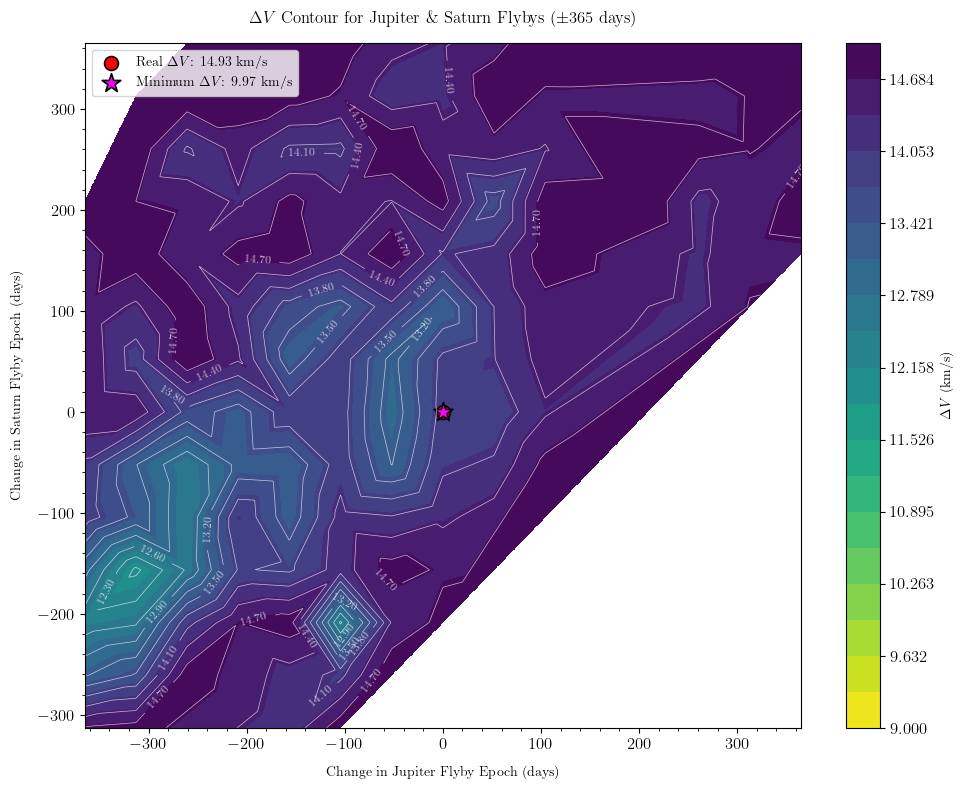

In [87]:
# Create a grid for the contour plot
max_deltav_threshold = 15  # km/s (adjust as needed)
valid_indices = [
    i for i in range(len(deltaV_values)) if deltaV_values[i] < max_deltav_threshold
]

# Extract valid data
valid_jupiter_mjd = [jupiter_flyby_mjd_change_in_time[i] for i in valid_indices]
valid_saturn_mjd = [saturn_flyby_mjd_change_in_time[i] for i in valid_indices]
valid_deltaV = [deltaV_values[i] for i in valid_indices]

# Grid sizes
jupiter_range = np.linspace(min(valid_jupiter_mjd), max(valid_jupiter_mjd), 1000)
saturn_range = np.linspace(min(valid_saturn_mjd), max(valid_saturn_mjd), 1000)

# Create meshgrid
X, Y = np.meshgrid(jupiter_range, saturn_range)

# Interpolate deltaV values to the grid using linear interpolation
Z = griddata(
    (valid_jupiter_mjd, valid_saturn_mjd), valid_deltaV, (X, Y), method="linear"
)

# Create the contour plot
fig, ax = plt.subplots(figsize=(10, 8))

# LaTeX-style text and font for better readability
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

# Set up a colormap that emphasises the minimum Delta-V
cmap = plt.cm.viridis_r
norm = colors.Normalize(vmin=np.nanmin(Z), vmax=np.nanmax(Z))

# Plot the contour
# Define contour levels within the specified range
levels = np.linspace(9, max_deltav_threshold, 20)  # 20 levels from 9 to max threshold

# Filled contour plot
contour = ax.contourf(
    X,
    Y,
    Z,
    levels=levels,
    cmap=cmap,
    norm=colors.Normalize(vmin=9, vmax=max_deltav_threshold),
)

cbar = plt.colorbar(contour, ax=ax, label=r"$\Delta V$ (km/s)")
cbar.ax.tick_params(labelsize=12)

contour_lines = ax.contour(
    X, Y, Z, levels=10, colors="white", linewidths=0.5, alpha=0.7
)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt=r"%.2f")

# Plot key mission points
ax.scatter(
    0,
    0,
    color="red",
    s=100,
    marker="o",
    edgecolors="black",
    linewidth=1.2,
    label=r"Real $\Delta V$: {:.2f} km/s".format(deltaV_REAL),
)

ax.scatter(
    date_flyby_jupiter_mjd_BRUTE_MIN - date_flyby_jupiter_mjd,
    date_flyby_saturn_mjd_BRUTE_MIN - date_flyby_saturn_mjd,
    color="fuchsia",
    s=200,
    marker="*",
    edgecolors="black",
    linewidth=1.2,
    label=r"Minimum $\Delta V$: {:.2f} km/s".format(deltaV_BRUTE_MIN),
)

# Set axis labels
ax.set_xlabel(r"Change in Jupiter Flyby Epoch (days)", labelpad=10)
ax.set_ylabel(r"Change in Saturn Flyby Epoch (days)", labelpad=10)
ax.set_title(r"$\Delta V$ Contour for Jupiter \& Saturn Flybys ($\pm$365 days)", pad=15)

# Improve grid and ticks
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Customise tick parameters
ax.tick_params(axis="both", which="major", labelsize=12)
ax.tick_params(axis="both", which="minor", labelsize=10)

plt.legend(loc="upper left")

# Adjust layout for better spacing
plt.tight_layout()
output_figures.save_file(
    "voyager_II_brute_force_contour_2D.png", dpi=500, bbox_inches="tight"
)

plt.show()
plt.close()

Figure saved to: Voyager 2 - Figures/voyager_II_brute_force_contour_3D.png


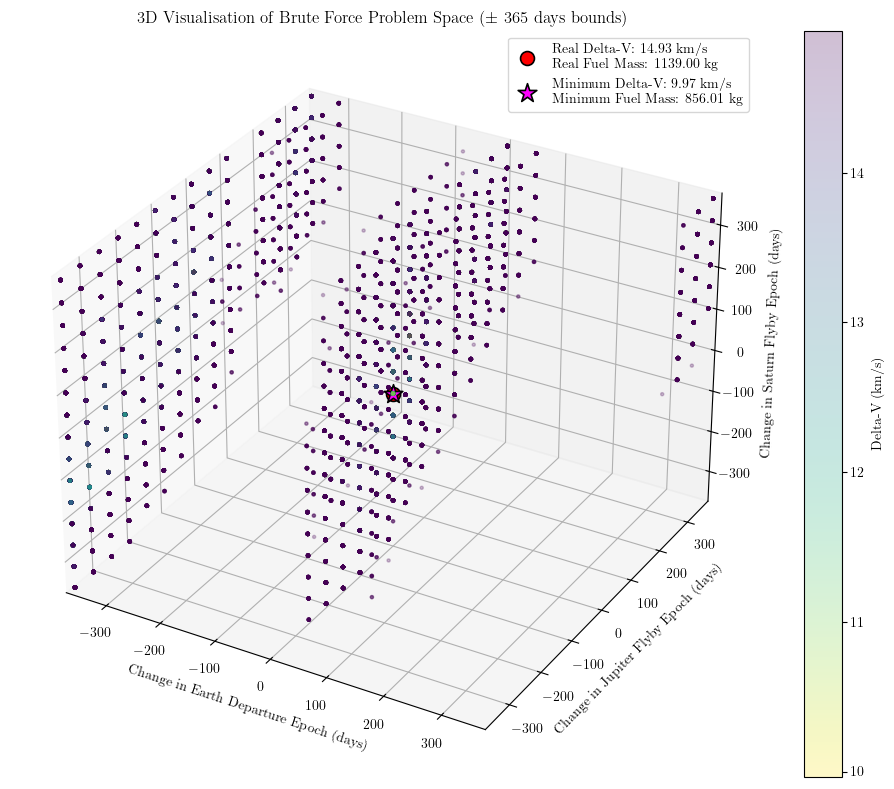

In [88]:
# Filter out any extreme values
max_deltav_threshold = 20  # km/s (adjust as needed)
valid_indices = [
    i for i in range(len(deltaV_values)) if deltaV_values[i] < max_deltav_threshold
]

# Extract valid data
valid_departure_mjd = [departure_mjd_change_in_time[i] for i in valid_indices]
valid_jupiter_mjd = [jupiter_flyby_mjd_change_in_time[i] for i in valid_indices]
valid_saturn_mjd = [saturn_flyby_mjd_change_in_time[i] for i in valid_indices]
valid_deltaV = [deltaV_values[i] for i in valid_indices]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

plt.rc("text", usetex=True)
plt.rc("font", family="serif")

# Create scatter plot with color based on delta-V 'viridis_r' 'plasma_r'
scatter = ax.scatter(
    valid_departure_mjd,
    valid_jupiter_mjd,
    valid_saturn_mjd,
    c=valid_deltaV,
    cmap="viridis_r",
    s=5,
    alpha=0.25,
    norm=colors.Normalize(vmin=min(valid_deltaV), vmax=min(valid_deltaV) * 1.5),
)

# Highlight the delta-V points
ax.scatter(
    [0],
    [0],
    [0],
    color="red",
    s=100,
    marker="o",
    edgecolors="black",
    linewidth=1.2,
    zorder=3,  # Higher zorder brings it to the front
    label=f"Real Delta-V: {deltaV_REAL:.2f} km/s\nReal Fuel Mass: {fuel_mass_REAL:.2f} kg",
)

ax.scatter(
    [date_departure_mjd_BRUTE_MIN - date_departure_mjd],
    [date_flyby_jupiter_mjd_BRUTE_MIN - date_flyby_jupiter_mjd],
    [date_flyby_saturn_mjd_BRUTE_MIN - date_flyby_saturn_mjd],
    color="fuchsia",
    s=200,
    marker="*",
    edgecolors="black",
    linewidth=1.2,
    zorder=3,  # Higher zorder brings it to the front
    label=f"Minimum Delta-V: {deltaV_BRUTE_MIN:.2f} km/s\nMinimum Fuel Mass: {fuel_mass_BRUTE_MIN:.2f} kg",
)


date_flyby_saturn_mjd_BRUTE_MIN
# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label="Delta-V (km/s)")

# Set labels and title
ax.set_xlabel("Change in Earth Departure Epoch (days)")
ax.set_ylabel("Change in Jupiter Flyby Epoch (days)")
ax.set_zlabel("Change in Saturn Flyby Epoch (days)")
ax.set_title("3D Visualisation of Brute Force Problem Space ($\pm$ 365 days bounds)")

# Set axis limits
limit = 375
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit, limit)

# Add a legend
ax.legend(loc="best")

# Show both plots
plt.tight_layout()
output_figures.save_file(
    "voyager_II_brute_force_contour_3D.png", dpi=500, bbox_inches="tight"
)

# ax.view_init(elev=30, azim=45)  # Adjust elevation & azimuth for a better view
plt.show()
plt.close()

In [89]:
gc.collect()

250

---
## Fmin Numerical Method

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html

https://jasoncantarella.com/downloads/NelderMeadProof.pdf

In [91]:
dates_REAL

[43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46666.74984953692,
 47763.164305555634]

In [92]:
%%time

if global_flag:
    iterations = []
    iteration_count = []

    # Initial guess for mission dates
    initial_guess = np.array([dates_REAL])
    
    
    def objective_function(dates):
        # Unpack date variables
        (
            date_departure_mjd,
            date_flyby_jupiter_mjd,
            date_flyby_saturn_mjd,
            date_flyby_uranus_mjd,
            date_flyby_neptune_mjd,
        ) = dates
        iteration_count.append(dates.copy())
    
        # Define search bounds
        lower_bound = initial_guess - 365
        upper_bound = initial_guess + 365
    
        # Check if any date is out of bounds
        if np.any(dates < lower_bound) or np.any(dates > upper_bound):
            return np.inf  # Assign a high penalty for out-of-bounds solutions
    
        try:
            # Compute Delta-V for the given dates
            deltaV, fuel_mass, data_dict = find_deltaV_mission(
                date_departure_mjd,
                date_flyby_jupiter_mjd,
                date_flyby_saturn_mjd,
                date_flyby_uranus_mjd,
                date_flyby_neptune_mjd,
            )
    
            # Store the iteration history
            iterations.append(dates.copy())
    
        except Exception as e:
            print(f"Error in simulation: {e}")
            return np.inf  # Assign a high penalty for failed evaluations
    
        return deltaV  # Minimize Delta-V
    
    
    # Start timing the optimisation
    start_time = time.time()
    
    # Optimise using `fmin` (Simplex method)
    optimal_dates = fmin(objective_function, initial_guess, disp=True, maxiter=2000)

    iteration_count = len(iteration_count)
    
    # Extract the optimised departure and flyby dates
    (
        date_departure_mjd_FMIN,
        date_flyby_jupiter_mjd_FMIN,
        date_flyby_saturn_mjd_FMIN,
        date_flyby_uranus_mjd_FMIN,
        date_flyby_neptune_mjd_FMIN,
    ) = optimal_dates
    
    # Compute Delta-V at optimissed dates
    deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN = find_deltaV_mission(*optimal_dates)
    
    # Display results
    print(f"\nMinimum Delta-V: {deltaV_FMIN:.4f} km/s")
    print(f"Optimal Departure Date (MJD): {date_departure_mjd_FMIN:.2f}")
    print(f"Optimal Jupiter Flyby Date (MJD): {date_flyby_jupiter_mjd_FMIN:.2f}")
    print(f"Optimal Saturn Flyby Date (MJD): {date_flyby_saturn_mjd_FMIN:.2f}")
    print(f"Optimal Uranus Flyby Date (MJD): {date_flyby_uranus_mjd_FMIN:.2f}")
    print(f"Optimal Neptune Flyby Date (MJD): {date_flyby_neptune_mjd_FMIN:.2f}")
    
    # Convert MJD dates to calendar dates
    print("\nIn calendar dates:")
    print(f"Departure: {MJD_to_TT_calander_date(date_departure_mjd_FMIN)}")
    print(f"Jupiter flyby: {MJD_to_TT_calander_date(date_flyby_jupiter_mjd_FMIN)}")
    print(f"Saturn flyby: {MJD_to_TT_calander_date(date_flyby_saturn_mjd_FMIN)}")
    print(f"Uranus flyby: {MJD_to_TT_calander_date(date_flyby_uranus_mjd_FMIN)}")
    print(f"Neptune flyby: {MJD_to_TT_calander_date(date_flyby_neptune_mjd_FMIN)}")
    
    # End timing
    execution_time_FMIN = time.time() - start_time
    print(f"\nExecution Time: {execution_time_FMIN:.4f} seconds")
    print(f"No. of Iterations: {iteration_count}")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [93]:
if global_flag:
    filename_brute = output_pickle.get_path("fmin_results_V2.pkl")
    
    results_brute = {
        "optimal_dates": optimal_dates,
        "execution_time_FMIN": execution_time_FMIN,
        "iterations": iterations,
        "iteration_count": iteration_count
        
    }
    with open(filename_brute, "wb") as f:
        pickle.dump(results_brute, f)

In [94]:
filename_brute = output_pickle.get_path("fmin_results_V2.pkl")

with open(filename_brute, "rb") as f:
    data = pickle.load(f)

optimal_dates = data["optimal_dates"]
execution_time_FMIN = data["execution_time_FMIN"]
iterations = data["iterations"]
iteration_count = data["iteration_count"]

if not global_flag:
    # Extract the optimised departure and flyby dates
    (
        date_departure_mjd_FMIN,
        date_flyby_jupiter_mjd_FMIN,
        date_flyby_saturn_mjd_FMIN,
        date_flyby_uranus_mjd_FMIN,
        date_flyby_neptune_mjd_FMIN,
    ) = optimal_dates
    
    # Compute Delta-V at optimissed dates
    deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN = find_deltaV_mission(*optimal_dates)
    
    # Display results
    print(f"\nMinimum Delta-V: {deltaV_FMIN:.4f} km/s")
    print(f"Optimal Departure Date (MJD): {date_departure_mjd_FMIN:.2f}")
    print(f"Optimal Jupiter Flyby Date (MJD): {date_flyby_jupiter_mjd_FMIN:.2f}")
    print(f"Optimal Saturn Flyby Date (MJD): {date_flyby_saturn_mjd_FMIN:.2f}")
    print(f"Optimal Uranus Flyby Date (MJD): {date_flyby_uranus_mjd_FMIN:.2f}")
    print(f"Optimal Neptune Flyby Date (MJD): {date_flyby_neptune_mjd_FMIN:.2f}")
    
    # Convert MJD dates to calendar dates
    print("\nIn calendar dates:")
    print(f"Departure: {MJD_to_TT_calander_date(date_departure_mjd_FMIN)}")
    print(f"Jupiter flyby: {MJD_to_TT_calander_date(date_flyby_jupiter_mjd_FMIN)}")
    print(f"Saturn flyby: {MJD_to_TT_calander_date(date_flyby_saturn_mjd_FMIN)}")
    print(f"Uranus flyby: {MJD_to_TT_calander_date(date_flyby_uranus_mjd_FMIN)}")
    print(f"Neptune flyby: {MJD_to_TT_calander_date(date_flyby_neptune_mjd_FMIN)}")
    
    print(f"\nExecution Time: {execution_time_FMIN:.4f} seconds")
    print(f"No. of Iterations: {iteration_count}")


Minimum Delta-V: 9.3713 km/s
Optimal Departure Date (MJD): 43388.97
Optimal Jupiter Flyby Date (MJD): 44119.21
Optimal Saturn Flyby Date (MJD): 44971.48
Optimal Uranus Flyby Date (MJD): 46706.76
Optimal Neptune Flyby Date (MJD): 48128.16

In calendar dates:
Departure: 1977-09-02 23:16:50.675
Jupiter flyby: 1979-09-03 05:06:38.181
Saturn flyby: 1982-01-02 11:28:33.046
Uranus flyby: 1986-10-03 18:21:11.480
Neptune flyby: 1990-08-25 03:56:35.928

Execution Time: 5.9432 seconds
No. of Iterations: 1443


In [95]:
# iterations

In [96]:
deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN = find_deltaV_mission(
    date_departure_mjd_FMIN,
    date_flyby_jupiter_mjd_FMIN,
    date_flyby_saturn_mjd_FMIN,
    date_flyby_uranus_mjd_FMIN,
    date_flyby_neptune_mjd_FMIN,
)
deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN

(9.37125750134365,
 816.7817510508315,
 {'deltaV_injection (km/s)': 9.35789550243903,
  'deltaV_jupiter (km/s)': 0.0009168183205279234,
  'rp_jupiter (km)': 2802517.371817503,
  'vp_jupiter (km/s)': 11.834271643601488,
  'vp_esc_jupiter (km/s)': 9.50935412829766,
  'deflection_jupiter (deg)': 94.14765367850407,
  'deltaV_saturn (km/s)': 2.6201263381153694e-11,
  'rp_saturn (km)': 516702.31495290494,
  'vp_saturn (km/s)': 15.304134784770053,
  'vp_esc_saturn (km/s)': 12.11694480065466,
  'deflection_saturn (deg)': 84.29926641857209,
  'deltaV_uranus (km/s)': 0.012445180557890012,
  'rp_uranus (km)': 171918.01181510068,
  'vp_uranus (km/s)': 15.542222697049406,
  'vp_esc_uranus (km/s)': 8.209964483111364,
  'deflection_uranus (deg)': 20.471397443524044,
  'tof (days)': 4739.194273761466})

In [97]:
print("Earth-Jupiter:", date_flyby_jupiter_mjd_FMIN - date_departure_mjd_FMIN, "days")
print(
    "Jupiter-Saturn:", date_flyby_saturn_mjd_FMIN - date_flyby_jupiter_mjd_FMIN, "days"
)
print("Saturn-Uranus:", date_flyby_uranus_mjd_FMIN - date_flyby_saturn_mjd_FMIN, "days")
print(
    "Uranus-Neptune:", date_flyby_neptune_mjd_FMIN - date_flyby_uranus_mjd_FMIN, "days"
)

Earth-Jupiter: 730.2429109525983 days
Jupiter-Saturn: 852.2652183495811 days
Saturn-Uranus: 1735.2865559484926 days
Uranus-Neptune: 1421.3995885107943 days


In [98]:
dates_list_FMIN = [
    date_departure_mjd_FMIN,
    date_flyby_jupiter_mjd_FMIN,
    date_flyby_saturn_mjd_FMIN,
    date_flyby_uranus_mjd_FMIN,
    date_flyby_neptune_mjd_FMIN,
]
dates_list_FMIN

[43388.97003095798,
 44119.21294191058,
 44971.47816026016,
 46706.76471620865,
 48128.164304719445]

In [99]:
change_in_dates_list_FMIN = [
    (date_departure_mjd - date_departure_mjd_FMIN),
    (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_FMIN),
    (date_flyby_saturn_mjd - date_flyby_saturn_mjd_FMIN),
    (date_flyby_uranus_mjd - date_flyby_uranus_mjd_FMIN),
    (date_flyby_neptune_mjd - date_flyby_neptune_mjd_FMIN),
]
change_in_dates_list_FMIN

[-10.491431420814479,
 -55.2755460771441,
 -129.33583387118415,
 -40.01486667172867,
 -364.99999916381057]

In [100]:
date_departure_FMIN = MJD_to_TT_calander_date(date_departure_mjd_FMIN)
date_flyby_jupiter_FMIN = MJD_to_TT_calander_date(date_flyby_jupiter_mjd_FMIN)
date_flyby_saturn_FMIN = MJD_to_TT_calander_date(date_flyby_saturn_mjd_FMIN)
date_flyby_uranus_FMIN = MJD_to_TT_calander_date(date_flyby_uranus_mjd_FMIN)
date_flyby_neptune_FMIN = MJD_to_TT_calander_date(date_flyby_neptune_mjd_FMIN)

print("Date of Departure (Min):", date_departure_FMIN)
print("Date of Jupiter Flyby (Min):", date_flyby_jupiter_FMIN)
print("Date of Saturn Flyby (Min):", date_flyby_saturn_FMIN)
print("Date of Uranus Flyby (Min):", date_flyby_uranus_FMIN)  # Fixed
print("Date of Neptune Flyby (Min):", date_flyby_neptune_FMIN)  # Fixed

Date of Departure (Min): 1977-09-02 23:16:50.675
Date of Jupiter Flyby (Min): 1979-09-03 05:06:38.181
Date of Saturn Flyby (Min): 1982-01-02 11:28:33.046
Date of Uranus Flyby (Min): 1986-10-03 18:21:11.480
Date of Neptune Flyby (Min): 1990-08-25 03:56:35.928


### Contour Graph of Problem Space

Figure saved to: Voyager 2 - Figures/voyager_II_fmin_contour_3D.png


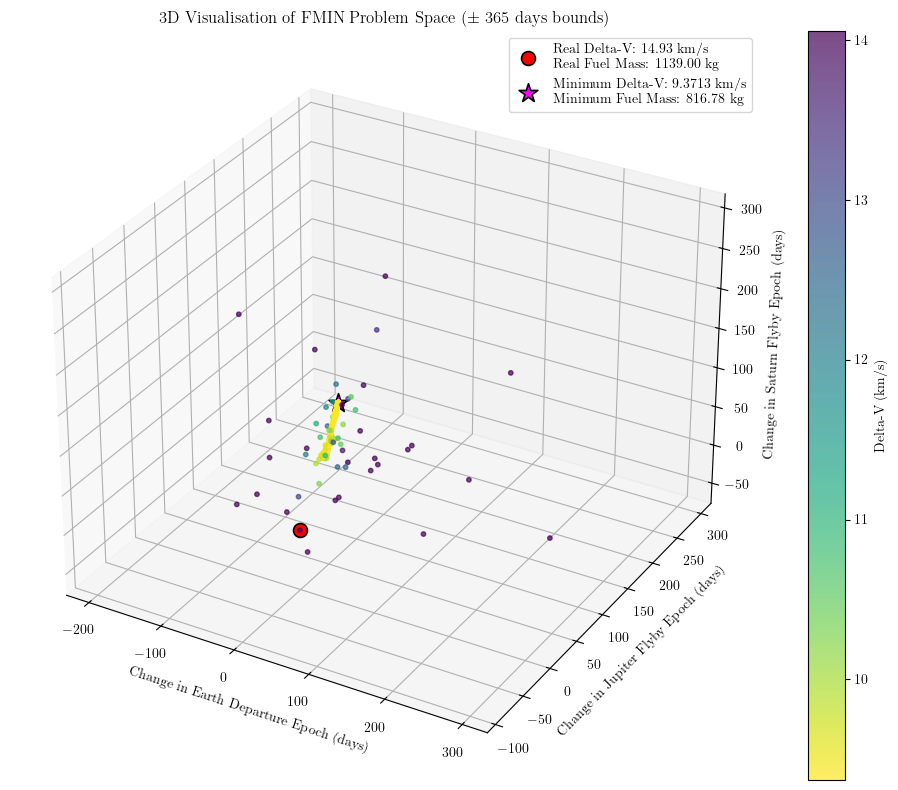

In [102]:
# Extract the dates from the iterations list
departure_dates_FMIN = np.array([iter[0] for iter in iterations])
jupiter_flyby_dates_FMIN = np.array([iter[1] for iter in iterations])
saturn_flyby_dates_FMIN = np.array([iter[2] for iter in iterations])

# Calculate the corresponding deltaV values for the iterations
deltaV_values_FMIN = []
for dates in iterations:
    try:
        deltaV, _, _ = find_deltaV_mission(*dates)
    except Exception:
        deltaV_values_FMIN.append(np.inf)
        continue
    deltaV_values_FMIN.append(deltaV)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

plt.rc("text", usetex=True)
plt.rc("font", family="serif")

# Scatter plot with color based on deltaV
scatter = ax.scatter(
    departure_dates_FMIN - date_departure_mjd,
    jupiter_flyby_dates_FMIN - date_flyby_jupiter_mjd,
    saturn_flyby_dates_FMIN - date_flyby_saturn_mjd,
    c=deltaV_values_FMIN,
    cmap="viridis_r",
    s=10,
    alpha=0.7,
    norm=plt.Normalize(
        vmin=min(deltaV_values_FMIN), vmax=min(deltaV_values_FMIN) * 1.5
    ),
)

# ax.plot(departure_dates_FMIN - date_departure_mjd, jupiter_flyby_dates_FMIN - date_flyby_jupiter_mjd, saturn_flyby_dates_FMIN - date_flyby_saturn_mjd,
#        linestyle='-', color='g', markersize=6, linewidth=0.5, alpha=0.5)

ax.scatter(
    [0],
    [0],
    [0],
    color="red",
    s=100,
    marker="o",
    edgecolors="black",
    linewidth=1.2,
    zorder=3,  # Higher zorder brings it to the front
    label=f"Real Delta-V: {deltaV_REAL:.2f} km/s\nReal Fuel Mass: {fuel_mass_REAL:.2f} kg",
)

ax.scatter(
    date_departure_mjd_FMIN - date_departure_mjd,
    date_flyby_jupiter_mjd_FMIN - date_flyby_jupiter_mjd,
    date_flyby_saturn_mjd_FMIN - date_flyby_saturn_mjd,
    color="fuchsia",
    s=200,
    marker="*",
    edgecolors="black",
    linewidth=1.2,
    zorder=3,  # Higher zorder brings it to the front
    label=f"Minimum Delta-V: {deltaV_FMIN:.4f} km/s\nMinimum Fuel Mass: {fuel_mass_FMIN:.2f} kg",
)


# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label="Delta-V (km/s)")

# Set labels and title
ax.set_xlabel("Change in Earth Departure Epoch (days)")
ax.set_ylabel("Change in Jupiter Flyby Epoch (days)")
ax.set_zlabel("Change in Saturn Flyby Epoch (days)")
ax.set_title("3D Visualisation of FMIN Problem Space ($\pm$ 365 days bounds)")

ax.legend(loc="best")

# Set axis limits
# limit = 375
# ax.set_xlim(-limit, limit)
# ax.set_ylim(-limit, limit)
# ax.set_zlim(-limit, limit)

# Show the plot
plt.tight_layout()
output_figures.save_file("voyager_II_fmin_contour_3D.png", dpi=500, bbox_inches="tight")

plt.show()
plt.close()

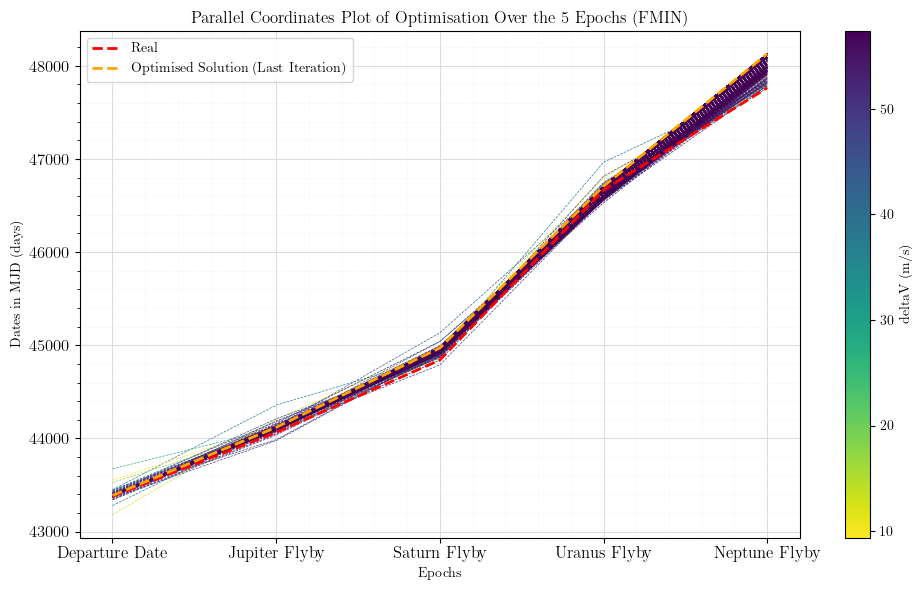

In [103]:
df = pd.DataFrame(
    iterations,
    columns=[
        "Departure Date",
        "Jupiter Flyby",
        "Saturn Flyby",
        "Uranus Flyby",
        "Neptune Flyby",
    ],
)

# Calculate the corresponding deltaV values for the iterations
deltaV_values_FMIN = []
for dates in iterations:
    try:
        deltaV, _, _ = find_deltaV_mission(
            *dates
        )  # Assuming find_deltaV_mission function is defined
    except Exception:
        deltaV_values_FMIN.append(np.inf)
        continue
    deltaV_values_FMIN.append(deltaV)

# Create an index for the iterations and add deltaV values to the DataFrame
df["deltaV"] = deltaV_values_FMIN
df["Iteration"] = df.index

# Set up the colour map for the lines based on deltaV values
norm = Normalize(vmin=np.min(deltaV_values_FMIN), vmax=np.max(deltaV_values_FMIN))
colors = plt.cm.viridis(norm(deltaV_values_FMIN))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the parallel coordinates plot with dashed lines
for i, row in df.iterrows():
    ax.plot(
        df.columns[:-2], row[:-2], linestyle="--", linewidth=0.5, color=colors[i]
    )  # Use color based on deltaV

ax.plot(
    df.columns[:-2], dates_REAL, linestyle="--", color="red", linewidth=2, label="Real"
)  # Highlighted line

# Highlight the last iteration
last_iteration = df.iloc[-1]
ax.plot(
    df.columns[:-2],
    last_iteration[:-2],
    linestyle="--",
    color="orange",
    linewidth=2,
    label="Optimised Solution (Last Iteration)",
)  # Highlighted line

# Add colour bar for deltaV
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="deltaV (m/s)")

# Set title and labels
ax.set_title("Parallel Coordinates Plot of Optimisation Over the 5 Epochs (FMIN)")
ax.set_xlabel("Epochs")
ax.set_ylabel("Dates in MJD (days)")

# Improve grid and ticks
ax.grid(which="major", color="#DDDDDD", linewidth=0.8)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)
ax.minorticks_on()

# Customise tick parameters
ax.tick_params(axis="both", which="major", labelsize=12)
ax.tick_params(axis="both", which="minor", labelsize=10)

ax.tick_params(axis="x", which="minor", length=0)

# Add legend for last iteration
ax.legend()

# Adjust layout for tightness
plt.tight_layout()

# Show the plot
plt.show()
plt.close()

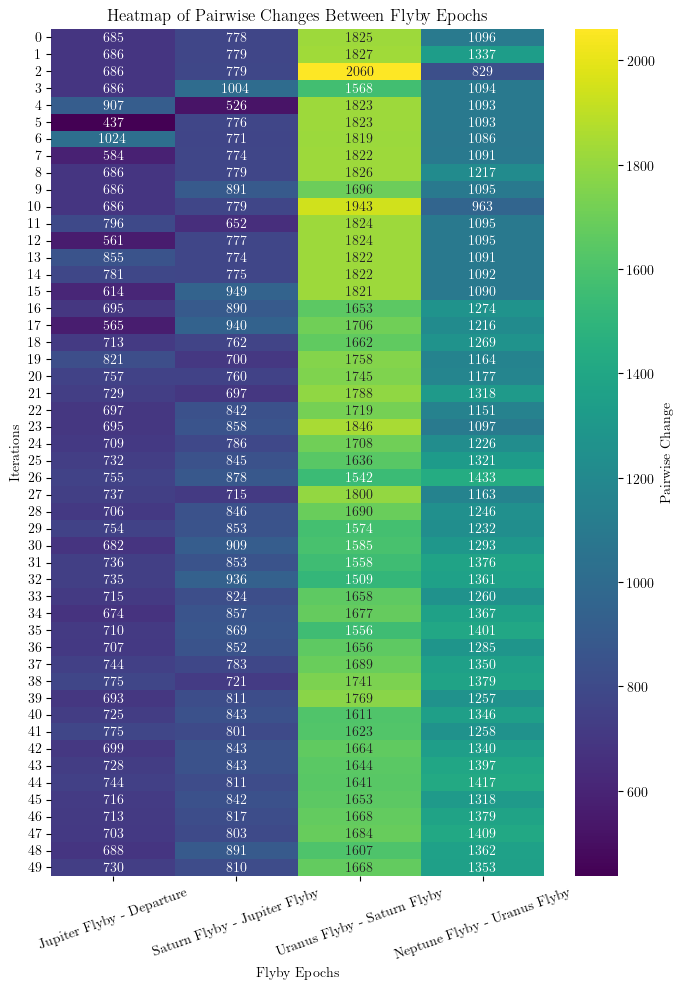

In [104]:
df_chosen = df.head(50)

# Select relevant columns
df_pairwise = df_chosen[
    ["Departure Date", "Jupiter Flyby", "Saturn Flyby", "Uranus Flyby", "Neptune Flyby"]
]

# Compute pairwise differences
pairwise_changes = df_pairwise.diff(axis=1)

# Rename columns to match desired format
pairwise_changes.columns = [
    "Departure",
    "Jupiter Flyby - Departure",
    "Saturn Flyby - Jupiter Flyby",
    "Uranus Flyby - Saturn Flyby",
    "Neptune Flyby - Uranus Flyby",
]

pairwise_changes = pairwise_changes.iloc[:, 1:]

# Compute the absolute values of the differences
# pairwise_changes = pairwise_changes.abs()


def format_annotation(val):
    if val < 1e-3:
        return f"{val:.2e}"
    else:
        return f"{int(val)}"


# Create a heatmap of pairwise changes for the last 50 iterations
# Plot the data
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

fig, ax = plt.subplots(figsize=(7, 10))
sns.heatmap(
    pairwise_changes,
    annot=True,
    fmt=".0f",
    cmap="viridis",
    cbar_kws={"label": "Pairwise Change"},
    annot_kws={"size": 10},
)

# Update annotations with custom format
for text in plt.gca().texts:
    text.set_text(format_annotation(float(text.get_text())))

plt.xticks(rotation=20)
plt.yticks(rotation=0)

plt.title("Heatmap of Pairwise Changes Between Flyby Epochs")
plt.xlabel("Flyby Epochs")
plt.ylabel("Iterations")

# ax.minorticks_on()
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)

ax.tick_params(axis="x", which="minor", length=0)

# Show the plot
plt.tight_layout()
plt.show()
plt.close()

In [105]:
df.columns[:]

Index(['Departure Date', 'Jupiter Flyby', 'Saturn Flyby', 'Uranus Flyby',
       'Neptune Flyby', 'deltaV', 'Iteration'],
      dtype='object')

In [106]:
[
    (date_departure_mjd - date_departure_mjd_FMIN),
    (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_FMIN),
    (date_flyby_saturn_mjd - date_flyby_saturn_mjd_FMIN),
    (date_flyby_uranus_mjd - date_flyby_uranus_mjd_FMIN),
    (date_flyby_neptune_mjd - date_flyby_neptune_mjd_FMIN),
]

[-10.491431420814479,
 -55.2755460771441,
 -129.33583387118415,
 -40.01486667172867,
 -364.99999916381057]

---
## Genetic Algorithm (GA)

In [108]:
change_in_time_days = 365

min_departure_date = date_departure_mjd - change_in_time_days
max_departure_date = date_departure_mjd + change_in_time_days

min_flyby_jupiter = date_flyby_jupiter_mjd - change_in_time_days
max_flyby_jupiter = date_flyby_jupiter_mjd + change_in_time_days

min_flyby_saturn = date_flyby_saturn_mjd - change_in_time_days
max_flyby_saturn = date_flyby_saturn_mjd + change_in_time_days

min_flyby_uranus = date_flyby_uranus_mjd - change_in_time_days
max_flyby_uranus = date_flyby_uranus_mjd + change_in_time_days

min_flyby_neptune = date_flyby_neptune_mjd - change_in_time_days
max_flyby_neptune = date_flyby_saturn_mjd + change_in_time_days

### Step 1: Generate Initial Population

In [110]:
# Step 1: Generate Initial Population
def initial_population(n_population):
    # Generates initial population within mission constraints.
    population = []
    population.append(dates_REAL)

    # Add interval to generate population
    for num in range(n_population - 1):
        date_departure_pop = random.uniform(min_departure_date, max_departure_date)
        date_flyby_jupiter_pop = random.uniform(min_flyby_jupiter, max_flyby_jupiter)
        date_flyby_saturn_pop = random.uniform(min_flyby_saturn, max_flyby_saturn)
        date_flyby_uranus_pop = random.uniform(min_flyby_uranus, max_flyby_uranus)
        date_flyby_neptune_pop = random.uniform(min_flyby_neptune, max_flyby_neptune)

        # Ensure chronological order of mission events
        dates_ordered = np.sort(
            [
                date_departure_pop,
                date_flyby_jupiter_pop,
                date_flyby_saturn_pop,
                date_flyby_uranus_pop,
                date_flyby_neptune_pop,
            ]
        )

        population.append(dates_ordered)

    return population


initial_population(5)

[[43378.478599537164,
  44063.93739583343,
  44842.142326388974,
  46666.74984953692,
  47763.164305555634],
 array([43502.95484609, 43890.3749806 , 45043.49266218, 46720.21840574,
        46765.88643557]),
 array([43385.88131106, 44274.0090128 , 45029.61246835, 46644.60876701,
        47245.48935758]),
 array([43622.86142104, 43713.5942421 , 44943.66920403, 46030.75359904,
        46864.67555203]),
 array([43432.16362692, 44383.94554112, 44497.79573543, 46899.39602534,
        46970.01638267])]

### Step 2: Evaluation [Fitness Function (Objective Function)]

In [112]:
# Step 2: Evaluation - Fitness Function (Objective Function)
def fitness(individual):
    # Evaluates fitness based on deltaV_total minimisation
    try:
        (
            date_departure_mjd,
            date_flyby_jupiter_mjd,
            date_flyby_saturn_mjd,
            date_flyby_uranus_mjd,
            date_flyby_neptune_mjd,
        ) = individual
        deltaV, fuel_mass, data_dict = find_deltaV_mission(*individual)
    except Exception:
        deltaV = 1e6  # Assign a large penalty for infeasible solutions

    return 1 / (deltaV + 1e-6)  # Avoid division by zero

### Step 3: Sort Population by Fitness

In [114]:
def sort_population_by_fitness(population, fitness_scores, n_population):
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Sort by highest fitness
    population = [
        population[i] for i in sorted_indices[:n_population]
    ]  # Ensures length population is 'n_population'
    return population

### Step 4: Elitism (Optional)

In [116]:
def elitism(population, n_elite):
    elite_individuals = population[:n_elite]
    return elite_individuals

### Step 5: Selection

#### Tournament Selection

In [119]:
def tournament_selection(population, fitness_scores, tournament_size=3):
    # Select random individuals for the tournament
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)

    # Find the best individual in the tournament
    tournament_fitness = [fitness_scores[i] for i in selected_indices]
    winner_idx = selected_indices[np.argmax(tournament_fitness)]

    return population[winner_idx]

#### Roulette Wheel Selection

In [121]:
def roulette_wheel_selection(population, fitness_values):
    # Calculate the normalised selection probability for each individual
    selection_prob = fitness_values / sum(fitness_values)
    # Calculate cumulative sum of fitness probabilities
    cum_sum = selection_prob.cumsum()
    # Generate a random number between 0 and 1
    r = random.random()
    # Find the first index where cumulative sum exceeds random number
    selected_index = np.where(cum_sum >= r)[0][0]
    return population[selected_index]


pop = initial_population(20)
# Evaluate fitness function
fitness_scores = np.array([fitness(ind) for ind in pop])
# Sorts population by fitness value
pop = sort_population_by_fitness(pop, fitness_scores, 20)

roulette_wheel_selection(pop, fitness_scores)

array([43493.61825414, 44088.16241705, 44534.3915214 , 46600.69647592,
       47336.11939387])

### Step 6: Crossover

#### Simulated Binary Crossover (SBX)

https://pymoo.org/operators/crossover.html

In [124]:
def sbx_crossover(parent_1, parent_2, eta):
    offspring_1 = parent_1[:]
    offspring_2 = parent_2[:]

    for i in range(len(parent_1)):
        u = random.random()
        if u <= 0.5:
            beta = (2 * u) ** (1 / (eta + 1))
        else:
            beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))

        # Generate offspring
        offspring_1[i] = 0.5 * ((1 + beta) * parent_1[i] + (1 - beta) * parent_2[i])
        offspring_2[i] = 0.5 * ((1 - beta) * parent_1[i] + (1 + beta) * parent_2[i])

    # Ensure chronological order (if values represent time-based sequences)
    # offspring_1 = np.sort(offspring_1)
    # offspring_2 = np.sort(offspring_2)

    return offspring_1, offspring_2

### Step 7: Mutation (Random Perturbations)

In [126]:
def gaussian_mutation(individual):
    # Create a copy to avoid modifying the original
    mutated = individual.copy()
    temp = mutated

    # Define bounds for each parameter
    bounds = [
        [min_departure_date, max_departure_date],
        [min_flyby_jupiter, max_flyby_jupiter],
        [min_flyby_saturn, max_flyby_saturn],
        [min_flyby_uranus, max_flyby_uranus],
        [min_flyby_neptune, max_flyby_neptune],
    ]

    # Select random index to mutate
    index = random.randint(0, 4)

    # Calculate parameter range
    param_range = bounds[index][1] - bounds[index][0]

    # Apply Gaussian mutation with standard deviation proportional to parameter range
    sigma = 0.05 * param_range  # 5% of the parameter range
    delta = random.gauss(0, sigma)
    mutated[index] += delta

    # Ensure value stays within bounds
    if mutated[index] < bounds[index][0] or mutated[index] > bounds[index][1]:
        mutated[index] = temp[index]

    # Ensure sequential order
    # mutated = np.sort(mutated)

    return mutated

### Step 8: Running GA

1. Initialise population
2. Sort population
3. Start Loop
4. Evaluate fitness
5. Select parents (roulette wheel)
6. Crossover (SBX or copy)
7. Mutation
8. Combine Offspring & Elite Individuals
9. Filter for constraints
10. Sort & truncate population 
11. Elitism (store best individuals)
12. Does it satisfy termination condition
13. If NO, then repeat loop. If YES, end loop
14. Store best (optimal) individual solution

In [128]:
def run_genetic_algorithm(
    n_population,
    n_elite,
    crossover_per,
    mutation_per,
    n_generations,
    population_per_generation,
):

    population = initial_population(n_population)  # Generate initial population

    # Evaluate fitness function
    fitness_scores_temp = np.array([fitness(ind) for ind in population])
    # Sorts population by fitness value
    population_temp = sort_population_by_fitness(
        population, fitness_scores_temp, n_population
    )

    population_per_generation.append(population_temp)
    elite_individuals = []

    for generation in range(0, n_generations):
        start_time = time.time()
        # Evaluate fitness function
        fitness_scores = np.array([fitness(ind) for ind in population])

        # Sorts population by fitness value
        population = sort_population_by_fitness(
            population, fitness_scores, n_population
        )

        # Print progress
        best_individual = population[0]
        best_deltaV, best_fuel_mass, _ = find_deltaV_mission(*best_individual)
        print(
            f"Generation {generation}: Best Delta-V = {best_deltaV:.6f} km/s, Fitness = {fitness(best_individual):.6f}"
        )

        # Apply elitism - preserve the best individuals
        if n_elite != 0:
            elite_individuals = elitism(population, n_elite)

        # Select parents for potential crossover - select enough for the whole population
        parents_list = []
        for i in range(n_population):
            parents_list.append(tournament_selection(population, fitness_scores))

        # Perform crossover with crossover probability
        offspring_list = []
        for i in range(0, len(parents_list) - 1, 2):
            # Apply crossover based on crossover probability
            if random.random() < crossover_per:
                offspring_1, offspring_2 = sbx_crossover(
                    parents_list[i], parents_list[i + 1], eta=1.5
                )
            else:
                # If no crossover, children are exact copies of parents
                offspring_1, offspring_2 = parents_list[i][:], parents_list[i + 1][:]

            offspring_list.extend([offspring_1, offspring_2])

        # Perform mutation
        for i in range(len(offspring_list)):
            if random.random() < mutation_per:
                offspring_list[i] = gaussian_mutation(offspring_list[i])

        # Combine elite individuals, parents and offspring
        mixed_population = offspring_list + elite_individuals

        # Filter solutions that meet the mission constraints
        mixed_population = [
            ind
            for ind in mixed_population
            if np.abs(ind[0] - date_departure_mjd) <= change_in_time_days
            and np.abs(ind[1] - date_flyby_jupiter_mjd) <= change_in_time_days
            and np.abs(ind[2] - date_flyby_saturn_mjd) <= change_in_time_days
            and np.abs(ind[3] - date_flyby_uranus_mjd) <= change_in_time_days
            and np.abs(ind[4] - date_flyby_neptune_mjd) <= change_in_time_days
        ]

        # Ensure population is not empty (if all individuals were filtered out)
        if not mixed_population:
            mixed_population = (
                offspring_list + elite_individuals
            )  # Restore full population if filtering removed all

        # Ensure population size remains constant (selection 'n_population' best individuals)
        fitness_scores = np.array([fitness(ind) for ind in mixed_population])
        population = sort_population_by_fitness(
            mixed_population, fitness_scores, n_population
        )

        # Store current population
        population_per_generation.append(population)

        end_time = time.time()
        # print(end_time - start_time)

    # Return the best-found solution
    best_individual = population[0]
    best_list = best_deltaV, best_fuel_mass, best_data = find_deltaV_mission(
        *best_individual
    )
    print(
        f"Generation {n_generations}: Best Delta-V = {best_deltaV:.6f} km/s, Fitness = {fitness(best_individual):.6f}"
    )

    print("\nFinal Optimised Solution:")
    print(f"Departure Date (MJD): {best_individual[0]:.2f}")
    print(f"Jupiter Flyby Date (MJD): {best_individual[1]:.2f}")
    print(f"Saturn Flyby Date (MJD): {best_individual[2]:.2f}")
    print(f"Uranus Flyby Date (MJD): {best_individual[3]:.2f}")
    print(f"Neptune Flyby Date (MJD): {best_individual[4]:.2f}")
    print(f"Total deltaV: {best_deltaV:.6f} km/s")

    return best_individual, best_list, population_per_generation

In [129]:
# n_population = 2000
# n_elite = 5
# crossover_per = 0.9
# mutation_per = 0.35
# n_generations = 25

# n_population = 2500
# n_elite = 10
# crossover_per = 0.9
# mutation_per = 0.3
# n_generations = 300

n_population = 500
n_elite = 25
crossover_per = 0.9
mutation_per = 0.1
n_generations = 100

In [130]:
%%time

if global_flag:
    # Start timing
    start_time = time.time()

    # Run the Genetic Algorithm
    best_individual, best_mission_data, population_per_generation = (
        run_genetic_algorithm(
            n_population, n_elite, crossover_per, mutation_per, n_generations, []
        )
    )
    print()
    # End timing
    end_time = time.time()
    execution_time_GA = end_time - start_time
    print(f"\nExecution Time: {execution_time_GA:.4f} seconds\n")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [131]:
if global_flag:
    filename_GA = output_pickle.get_path("ga_results_V2.pkl")

    results_GA = {
        "Best Individual": best_individual,
        "Best Mission Data": best_mission_data,
        "Population Per Generation": population_per_generation,
        "execution_time_GA": execution_time_GA,
    }

    with open(filename_GA, "wb") as f:
        pickle.dump(results_GA, f)

In [132]:
filename_GA = output_pickle.get_path("ga_results_V2.pkl")

with open(filename_GA, "rb") as f:
    data = pickle.load(f)

best_individual = data["Best Individual"]
best_mission_data = data["Best Mission Data"]
population_per_generation = data["Population Per Generation"]
execution_time_GA = data["execution_time_GA"]

if not global_flag:
    for gen in range(len(population_per_generation)):
        best_individual = population_per_generation[gen][0]
        best_deltaV, best_fuel_mass, _ = find_deltaV_mission(*best_individual)
        print(
            f"Generation {gen}: Best Delta-V = {best_deltaV:.6f} km/s, Fitness = {fitness(best_individual):.6f}"
        )

    # Return the best-found solution
    best_individual = population_per_generation[-1][0]
    best_list = best_deltaV, best_fuel_mass, best_data = find_deltaV_mission(
        *best_individual
    )
    print(
        f"Generation {n_generations}: Best Delta-V = {best_deltaV:.6f} km/s, Fitness = {fitness(best_individual):.6f}"
    )

    print("\nFinal Optimised Solution:")
    print(f"Departure Date (MJD): {best_individual[0]:.2f}")
    print(f"Jupiter Flyby Date (MJD): {best_individual[1]:.2f}")
    print(f"Saturn Flyby Date (MJD): {best_individual[2]:.2f}")
    print(f"Total deltaV: {best_deltaV:.6f} km/s")

    print(f"\nExecution Time: {execution_time_GA:.4f} seconds\n")

Generation 0: Best Delta-V = 14.928106 km/s, Fitness = 0.066988
Generation 1: Best Delta-V = 14.928106 km/s, Fitness = 0.066988
Generation 2: Best Delta-V = 12.171653 km/s, Fitness = 0.082158
Generation 3: Best Delta-V = 10.979255 km/s, Fitness = 0.091081
Generation 4: Best Delta-V = 10.830302 km/s, Fitness = 0.092334
Generation 5: Best Delta-V = 10.528690 km/s, Fitness = 0.094979
Generation 6: Best Delta-V = 10.400745 km/s, Fitness = 0.096147
Generation 7: Best Delta-V = 10.400745 km/s, Fitness = 0.096147
Generation 8: Best Delta-V = 10.254958 km/s, Fitness = 0.097514
Generation 9: Best Delta-V = 10.145931 km/s, Fitness = 0.098562
Generation 10: Best Delta-V = 9.978617 km/s, Fitness = 0.100214
Generation 11: Best Delta-V = 9.860274 km/s, Fitness = 0.101417
Generation 12: Best Delta-V = 9.763277 km/s, Fitness = 0.102425
Generation 13: Best Delta-V = 9.697365 km/s, Fitness = 0.103121
Generation 14: Best Delta-V = 9.694029 km/s, Fitness = 0.103156
Generation 15: Best Delta-V = 9.663997 k

In [133]:
time.sleep(1)  # Give the kernel a moment to catch up

In [134]:
best_solutions_per_generation = [element[0] for element in population_per_generation]
best_solutions_per_generation, len(best_solutions_per_generation)

([[43378.478599537164,
   44063.93739583343,
   44842.142326388974,
   46666.74984953692,
   47763.164305555634],
  [43378.478599537164,
   44063.93739583343,
   44842.142326388974,
   46666.74984953692,
   47763.164305555634],
  [43378.478599537164,
   44063.93739583343,
   44842.142326388974,
   46666.74984953692,
   47981.8062217132],
  [43378.47859953716,
   44063.937395833425,
   44842.142326388974,
   46666.74984953692,
   48108.17228927156],
  [43380.60786216057,
   44064.400161146266,
   44842.264786479944,
   46665.05604759058,
   48106.165751008855],
  [43380.513251448036,
   44064.3643038285,
   44897.949681409606,
   46673.23139408088,
   48102.51838058172],
  [43380.661547474985,
   44088.80465928217,
   44902.4336607131,
   46678.85006022333,
   48090.66642582516],
  [43380.661547474985,
   44088.80465928217,
   44902.4336607131,
   46678.85006022333,
   48090.66642582516],
  [43380.672439204194,
   44093.14110672443,
   44957.30009146939,
   46681.00827084314,
   48121.7

In [135]:
dates_REAL

[43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46666.74984953692,
 47763.164305555634]

### GA Result Analysis

In [137]:
deltaV_GA, fuel_mass_GA, data_dict_GA = find_deltaV_mission(*best_individual)
deltaV_GA, fuel_mass_GA, data_dict_GA

(9.36152032789823,
 816.1285632058713,
 {'deltaV_injection (km/s)': 9.361520326659656,
  'deltaV_jupiter (km/s)': 7.18996417958806e-10,
  'rp_jupiter (km)': 2770004.045423409,
  'vp_jupiter (km/s)': 11.901891880948948,
  'vp_esc_jupiter (km/s)': 9.56500003203136,
  'deflection_jupiter (deg)': 94.25132811528943,
  'deltaV_saturn (km/s)': 2.1593926646801265e-10,
  'rp_saturn (km)': 507478.59536726406,
  'vp_saturn (km/s)': 15.441204304495137,
  'vp_esc_saturn (km/s)': 12.22656521092557,
  'deflection_saturn (deg)': 84.34962634943922,
  'deltaV_uranus (km/s)': 3.03638003629203e-10,
  'rp_uranus (km)': 168233.3340319893,
  'vp_uranus (km/s)': 15.670785764613605,
  'vp_esc_uranus (km/s)': 8.299385590522153,
  'deflection_uranus (deg)': 20.627619471411386,
  'tof (days)': 4716.798433988326})

In [138]:
date_departure_mjd_GA = best_individual[0]
date_flyby_jupiter_mjd_GA = best_individual[1]
date_flyby_saturn_mjd_GA = best_individual[2]
date_flyby_uranus_mjd_GA = best_individual[3]
date_flyby_neptune_mjd_GA = best_individual[4]

print(f"Difference for date_departure: {date_departure_mjd_GA - date_departure_mjd}")
print(
    f"Difference for date_flyby_jupiter: {date_flyby_jupiter_mjd_GA - date_flyby_jupiter_mjd}"
)
print(
    f"Difference for date_flyby_saturn: {date_flyby_saturn_mjd_GA - date_flyby_saturn_mjd}"
)
print(
    f"Difference for date_flyby_uranus: {date_flyby_uranus_mjd_GA - date_flyby_uranus_mjd}"
)
print(
    f"Difference for date_flyby_neptune: {date_flyby_neptune_mjd_GA - date_flyby_neptune_mjd}\n"
)

change_in_dates_list_GA = [
    (date_departure_mjd - date_departure_mjd_GA),
    (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_GA),
    (date_flyby_saturn_mjd - date_flyby_saturn_mjd_GA),
    (date_flyby_uranus_mjd - date_flyby_uranus_mjd_GA),
    (date_flyby_neptune_mjd - date_flyby_neptune_mjd_GA),
]
change_in_dates_list_GA

Difference for date_departure: 10.330942864602548
Difference for date_flyby_jupiter: 52.3680094810843
Difference for date_flyby_saturn: 121.6322707088766
Difference for date_flyby_uranus: 23.88140782364644
Difference for date_flyby_neptune: 342.4436708344583



[-10.330942864602548,
 -52.3680094810843,
 -121.6322707088766,
 -23.88140782364644,
 -342.4436708344583]

In [139]:
print("Earth-Jupiter:", date_flyby_jupiter_mjd_GA - date_departure_mjd_GA, "days")
print("Jupiter-Saturn:", date_flyby_saturn_mjd_GA - date_flyby_jupiter_mjd_GA, "days")
print("Saturn-Uranus:", date_flyby_uranus_mjd_GA - date_flyby_saturn_mjd_GA, "days")
print("Uranus-Neptune:", date_flyby_neptune_mjd_GA - date_flyby_uranus_mjd_GA, "days")

Earth-Jupiter: 727.4958629127505 days
Jupiter-Saturn: 847.4691917833334 days
Saturn-Uranus: 1726.856660262718 days
Uranus-Neptune: 1414.9767190295242 days


In [140]:
date_departure_GA = MJD_to_TT_calander_date(date_departure_mjd_GA)
date_flyby_jupiter_GA = MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA)
date_flyby_saturn_GA = MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA)
date_flyby_uranus_GA = MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA)
date_flyby_neptune_GA = MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA)

print("Date of Departure (Min):", MJD_to_TT_calander_date(date_departure_mjd_GA))

print(
    "Date of Jupiter Flyby (Min):", MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA)
)

print("Date of Saturn Flyby (Min):", MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA))

print("Date of Uranus Flyby (Min):", MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA))

print(
    "Date of Neptune Flyby (Min):", MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA)
)

[
    date_departure_GA,
    date_flyby_jupiter_GA,
    date_flyby_saturn_GA,
    date_flyby_uranus_GA,
    date_flyby_neptune_GA,
]

Date of Departure (Min): 1977-09-02 19:25:44.464
Date of Jupiter Flyby (Min): 1979-08-31 07:19:47.019
Date of Saturn Flyby (Min): 1981-12-25 18:35:25.189
Date of Uranus Flyby (Min): 1986-09-17 15:09:00.636
Date of Neptune Flyby (Min): 1990-08-02 14:35:29.160


['1977-09-02 19:25:44.464',
 '1979-08-31 07:19:47.019',
 '1981-12-25 18:35:25.189',
 '1986-09-17 15:09:00.636',
 '1990-08-02 14:35:29.160']

In [141]:
GA_list = [
    date_departure_mjd_GA,
    date_flyby_jupiter_mjd_GA,
    date_flyby_saturn_mjd_GA,
    date_flyby_uranus_mjd_GA,
    date_flyby_neptune_mjd_GA,
]
GA_list

[43388.80954240177,
 44116.30540531452,
 44963.77459709785,
 46690.63125736057,
 48105.60797639009]

#### Objective Function vs No. of Generations

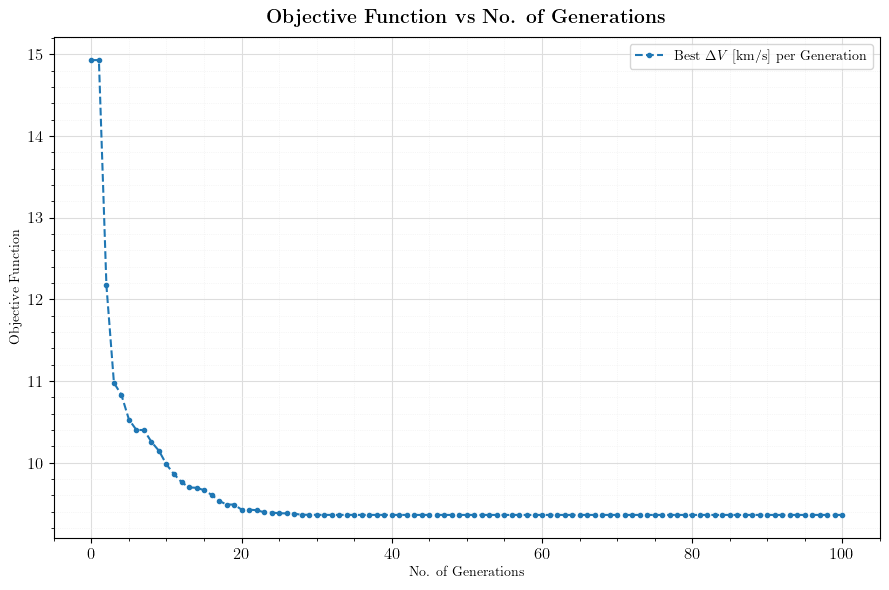

In [143]:
generations = list(range(len(best_solutions_per_generation)))  # X-axis (Generation numbers)
deltaV_values_GA = []  # Y-axis (Best Delta V per generation)

for solution in best_solutions_per_generation:
    best_deltaV, best_fuel_mass, _ = find_deltaV_mission(*solution)  # Compute Delta V for each best solution
    deltaV_values_GA.append(best_deltaV)

# Plot the data
fig, ax = plt.subplots(figsize=(9, 6))

plt.plot(generations[:], deltaV_values_GA[:], marker='.', linestyle='--', label="Best $\Delta V$ [km/s] per Generation")

plt.xlabel("No. of Generations")
plt.ylabel("Objective Function")

plt.title(r"\textbf{Objective Function vs No. of Generations}", pad=10, fontsize=14)

plt.legend(loc="best")

# Improve grid and ticks
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.tight_layout()

# Show plot
plt.show()

#### Fitness Function vs No. of Generations

Figure saved to: Voyager 2 - Figures/voyager_I_GA_fitness_function.png


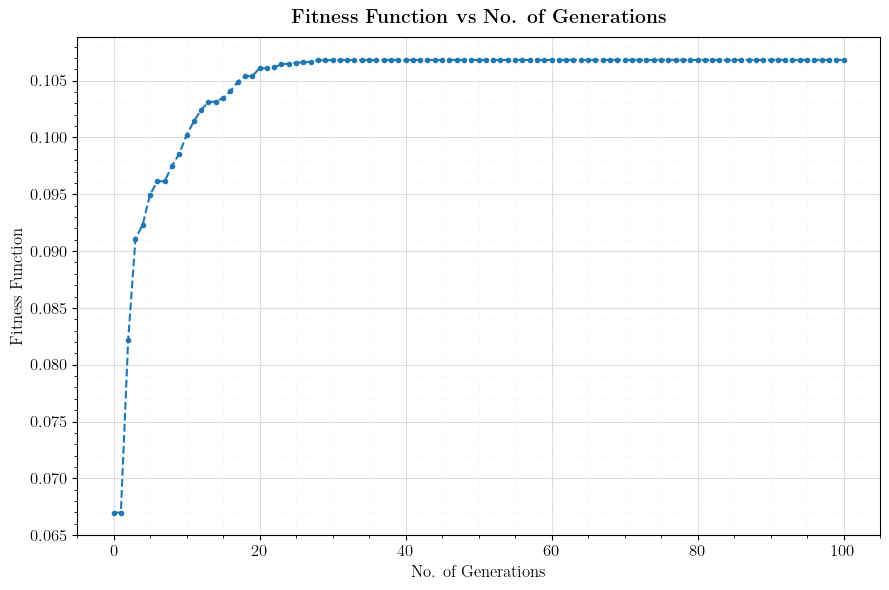

In [145]:
fitness_values_deltaV = 1/np.array(deltaV_values_GA)

fig, ax = plt.subplots(figsize=(9, 6))

plt.plot(generations, fitness_values_deltaV, marker='.', linestyle='--', label="Fitness Function $(1/\Delta V)$ per Generation")

plt.xlabel("No. of Generations", fontsize=12)
plt.ylabel("Fitness Function", fontsize=12)

plt.title(r"\textbf{Fitness Function vs No. of Generations}", pad=10, fontsize=14)

# Improve grid and ticks
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Customise tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.tight_layout()

output_figures.save_file("voyager_I_GA_fitness_function.png", dpi=500, bbox_inches="tight")

# Show plot
plt.show()

#### Objective \& Fitness

Figure saved to: Voyager 2 - Figures/voyager_II_GA_fitness_objective.png


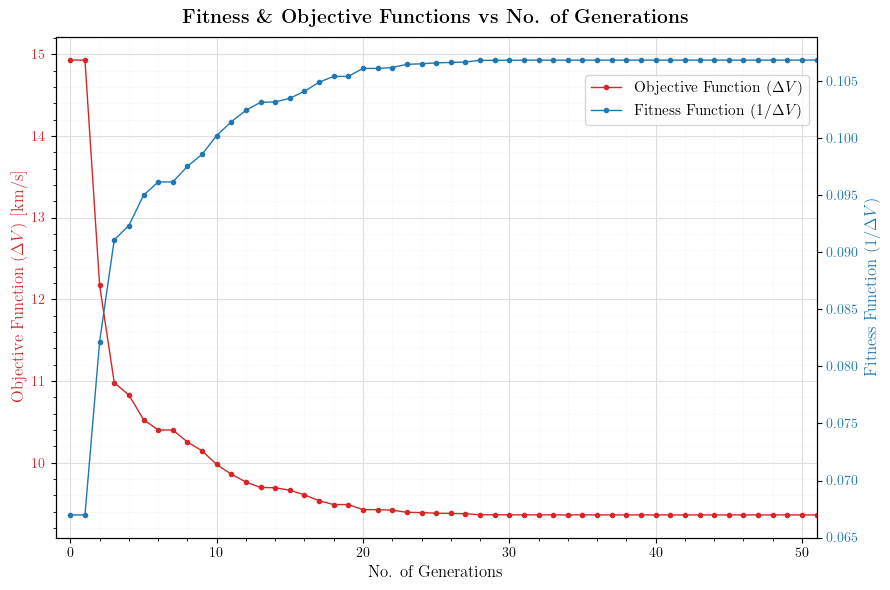

In [147]:
fig, ax1 = plt.subplots(figsize=(9, 6))

# Plot objective value on primary axis (left)
color1 = 'tab:red'
ax1.set_xlabel('No. of Generations', fontsize=12)
ax1.set_ylabel('Objective Function $(\\Delta V)$ [km/s]', fontsize=12, color=color1)
line1 = ax1.plot(generations, deltaV_values_GA, marker='.', linestyle='-', linewidth=1,
                color=color1, label='Objective Function $(\\Delta V)$')
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis (right) for fitness value
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Fitness Function $(1/\\Delta V)$', fontsize=12, color=color2)
line2 = ax2.plot(generations, fitness_values_deltaV, marker='.', linestyle='-', linewidth=1,
               color=color2, label='Fitness Function $(1/\\Delta V)$')
ax2.tick_params(axis='y', labelcolor=color2)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(1, 0.94), fontsize=11)

ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax1.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax1.minorticks_on()

plt.title(r'\textbf{Fitness \& Objective Functions vs No. of Generations}', 
          pad=10, fontsize=14)

#ax1.set_ylim(1/0.1068, 1/0.1028)  # For objective function (ΔV)
#ax2.set_ylim(0.103, 0.1072)  # For fitness function (1/ΔV)

ax1.set_xlim(-1, 51)

plt.tight_layout()
output_figures.save_file("voyager_II_GA_fitness_objective.png", dpi=500, bbox_inches="tight")

# Show plot
plt.show()

In [148]:
gc.collect()

15921

## GA Results --> Fmin

In [150]:
%%time 

if global_flag:
    iterations = []
    iteration_count = []

    # Start timing
    start_time = time.time()
    
    # Run optimisation using `fmin` with manual bounds enforcement
    optimal_dates = fmin(
        objective_function,
        GA_list,
        disp=True,
        xtol=1e-9,
        ftol=1e-9,
        maxiter=1e6,
        maxfun=1e6,
    )

    iteration_count = len(iteration_count)
    
    # Extract optimised dates
    (
        date_departure_mjd_GA_FMIN_COMBINED,
        date_flyby_jupiter_mjd_GA_FMIN_COMBINED,
        date_flyby_saturn_mjd_GA_FMIN_COMBINED,
        date_flyby_uranus_mjd_GA_FMIN_COMBINED,
        date_flyby_neptune_mjd_GA_FMIN_COMBINED,
    ) = optimal_dates
    
    # Compute Delta-V and fuel mass at optimised dates
    deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED = (
        find_deltaV_mission(*optimal_dates)
    )
    
    # Display results
    print(f"\nMinimum Delta-V: {deltaV_GA_FMIN_COMBINED:.4f} km/s")
    print(f"Optimal Departure Date (MJD): {date_departure_mjd_GA_FMIN_COMBINED:.2f}")
    print(
        f"Optimal Jupiter Flyby Date (MJD): {date_flyby_jupiter_mjd_GA_FMIN_COMBINED:.2f}"
    )
    print(f"Optimal Saturn Flyby Date (MJD): {date_flyby_saturn_mjd_GA_FMIN_COMBINED:.2f}")
    print(f"Optimal Uranus Flyby Date (MJD): {date_flyby_uranus_mjd_GA_FMIN_COMBINED:.2f}")
    print(
        f"Optimal Neptune Flyby Date (MJD): {date_flyby_neptune_mjd_GA_FMIN_COMBINED:.2f}"
    )
    
    # Convert MJD dates to calendar dates
    print("\nIn calendar dates:")
    print(f"Departure: {MJD_to_TT_calander_date(date_departure_mjd_GA_FMIN_COMBINED)}")
    print(
        f"Jupiter flyby: {MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA_FMIN_COMBINED)}"
    )
    print(
        f"Saturn flyby: {MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA_FMIN_COMBINED)}"
    )
    print(
        f"Uranus flyby: {MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA_FMIN_COMBINED)}"
    )
    print(
        f"Neptune flyby: {MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA_FMIN_COMBINED)}"
    )
    
    # End timing
    execution_time_GA_FMIN_COMBINED = time.time() - start_time
    print(f"\nExecution Time: {execution_time_GA_FMIN_COMBINED:.4f} seconds")
    print(f"No. of Iterations: {iteration_count}")

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 8.34 µs


In [151]:
if global_flag:
    filename_brute = output_pickle.get_path("ga_+_fmin_results_V2.pkl")
    
    results_brute = {
        "optimal_dates": optimal_dates,
        "execution_time_GA_FMIN_COMBINED": execution_time_GA_FMIN_COMBINED,
        "iteration_count": iteration_count
        
    }
    with open(filename_brute, "wb") as f:
        pickle.dump(results_brute, f)

In [152]:
filename_brute = output_pickle.get_path("ga_+_fmin_results_V2.pkl")

with open(filename_brute, "rb") as f:
    data = pickle.load(f)

optimal_dates = data["optimal_dates"]
execution_time_GA_FMIN_COMBINED = data["execution_time_GA_FMIN_COMBINED"]
iteration_count = data["iteration_count"]

if not global_flag:
    # Extract optimised dates
    (
        date_departure_mjd_GA_FMIN_COMBINED,
        date_flyby_jupiter_mjd_GA_FMIN_COMBINED,
        date_flyby_saturn_mjd_GA_FMIN_COMBINED,
        date_flyby_uranus_mjd_GA_FMIN_COMBINED,
        date_flyby_neptune_mjd_GA_FMIN_COMBINED,
    ) = optimal_dates
    
    # Compute Delta-V and fuel mass at optimised dates
    deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED = (
        find_deltaV_mission(*optimal_dates)
    )
    
    # Display results
    print(f"\nMinimum Delta-V: {deltaV_GA_FMIN_COMBINED:.4f} km/s")
    print(f"Optimal Departure Date (MJD): {date_departure_mjd_GA_FMIN_COMBINED:.2f}")
    print(
        f"Optimal Jupiter Flyby Date (MJD): {date_flyby_jupiter_mjd_GA_FMIN_COMBINED:.2f}"
    )
    print(f"Optimal Saturn Flyby Date (MJD): {date_flyby_saturn_mjd_GA_FMIN_COMBINED:.2f}")
    print(f"Optimal Uranus Flyby Date (MJD): {date_flyby_uranus_mjd_GA_FMIN_COMBINED:.2f}")
    print(
        f"Optimal Neptune Flyby Date (MJD): {date_flyby_neptune_mjd_GA_FMIN_COMBINED:.2f}"
    )
    
    # Convert MJD dates to calendar dates
    print("\nIn calendar dates:")
    print(f"Departure: {MJD_to_TT_calander_date(date_departure_mjd_GA_FMIN_COMBINED)}")
    print(
        f"Jupiter flyby: {MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA_FMIN_COMBINED)}"
    )
    print(
        f"Saturn flyby: {MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA_FMIN_COMBINED)}"
    )
    print(
        f"Uranus flyby: {MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA_FMIN_COMBINED)}"
    )
    print(
        f"Neptune flyby: {MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA_FMIN_COMBINED)}"
    )
    
    print(f"\nExecution Time: {execution_time_GA_FMIN_COMBINED:.4f} seconds")
    print(f"No. of Iterations: {iteration_count}")


Minimum Delta-V: 9.3580 km/s
Optimal Departure Date (MJD): 43388.87
Optimal Jupiter Flyby Date (MJD): 44119.07
Optimal Saturn Flyby Date (MJD): 44970.95
Optimal Uranus Flyby Date (MJD): 46705.60
Optimal Neptune Flyby Date (MJD): 48127.84

In calendar dates:
Departure: 1977-09-02 20:59:15.045
Jupiter flyby: 1979-09-03 01:38:02.079
Saturn flyby: 1982-01-01 22:47:12.250
Uranus flyby: 1986-10-02 14:31:04.214
Neptune flyby: 1990-08-24 20:04:15.847

Execution Time: 15.0133 seconds
No. of Iterations: 3303


In [153]:
deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED = (
    find_deltaV_mission(*optimal_dates)
)
deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED

(9.358046430397152,
 815.8954449993682,
 {'deltaV_injection (km/s)': 9.358037063778704,
  'deltaV_jupiter (km/s)': 8.953961387447862e-06,
  'rp_jupiter (km)': 2800740.34130855,
  'vp_jupiter (km/s)': 11.837743359432663,
  'vp_esc_jupiter (km/s)': 9.51237042590936,
  'deflection_jupiter (deg)': 94.15970492764589,
  'deltaV_saturn (km/s)': 9.521272659185342e-13,
  'rp_saturn (km)': 516021.4711421794,
  'vp_saturn (km/s)': 15.314127824503991,
  'vp_esc_saturn (km/s)': 12.124935773829252,
  'deflection_saturn (deg)': 84.30292432886259,
  'deltaV_uranus (km/s)': 4.126561083950264e-07,
  'rp_uranus (km)': 171822.4661678232,
  'vp_uranus (km/s)': 15.549357779710983,
  'vp_esc_uranus (km/s)': 8.212246831191617,
  'deflection_uranus (deg)': 20.479259426751486,
  'tof (days)': 4738.961814830298})

In [154]:
print(
    "Earth-Jupiter:",
    date_flyby_jupiter_mjd_GA_FMIN_COMBINED - date_departure_mjd_GA_FMIN_COMBINED,
    "days",
)
print(
    "Jupiter-Saturn:",
    date_flyby_saturn_mjd_GA_FMIN_COMBINED - date_flyby_jupiter_mjd_GA_FMIN_COMBINED,
    "days",
)
print(
    "Saturn-Uranus:",
    date_flyby_uranus_mjd_GA_FMIN_COMBINED - date_flyby_saturn_mjd_GA_FMIN_COMBINED,
    "days",
)
print(
    "Uranus-Neptune:",
    date_flyby_neptune_mjd_GA_FMIN_COMBINED - date_flyby_uranus_mjd_GA_FMIN_COMBINED,
    "days",
)

Earth-Jupiter: 730.1935999267444 days
Jupiter-Saturn: 851.8813677157596 days
Saturn-Uranus: 1734.655462556082 days
Uranus-Neptune: 1422.231384631712 days


In [155]:
change_in_dates_list_GA_FMIN_COMBINED = [
    (date_departure_mjd - date_departure_mjd_GA_FMIN_COMBINED),
    (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_GA_FMIN_COMBINED),
    (date_flyby_saturn_mjd - date_flyby_saturn_mjd_GA_FMIN_COMBINED),
    (date_flyby_uranus_mjd - date_flyby_uranus_mjd_GA_FMIN_COMBINED),
    (date_flyby_neptune_mjd - date_flyby_neptune_mjd_GA_FMIN_COMBINED),
]
change_in_dates_list_GA_FMIN_COMBINED

[-10.395880153591861,
 -55.130683784067514,
 -128.807120944286,
 -38.85506035241997,
 -364.6719889654196]

In [156]:
date_departure_GA_FMIN_COMBINED = MJD_to_TT_calander_date(
    date_departure_mjd_GA_FMIN_COMBINED
)
date_flyby_jupiter_GA_FMIN_COMBINED = MJD_to_TT_calander_date(
    date_flyby_jupiter_mjd_GA_FMIN_COMBINED
)
date_flyby_saturn_GA_FMIN_COMBINED = MJD_to_TT_calander_date(
    date_flyby_saturn_mjd_GA_FMIN_COMBINED
)
date_flyby_uranus_GA_FMIN_COMBINED = MJD_to_TT_calander_date(
    date_flyby_uranus_mjd_GA_FMIN_COMBINED
)
date_flyby_neptune_GA_FMIN_COMBINED = MJD_to_TT_calander_date(
    date_flyby_neptune_mjd_GA_FMIN_COMBINED
)

print(
    "Date of Departure (Min):",
    MJD_to_TT_calander_date(date_departure_mjd_GA_FMIN_COMBINED),
)
print(
    "Date of Jupiter Flyby (Min):",
    MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA_FMIN_COMBINED),
)
print(
    "Date of Saturn Flyby (Min):",
    MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA_FMIN_COMBINED),
)
print(
    "Date of Uranus Flyby (Min):",
    MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA_FMIN_COMBINED),
)
print(
    "Date of Neptune Flyby (Min):",
    MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA_FMIN_COMBINED),
)

Date of Departure (Min): 1977-09-02 20:59:15.045
Date of Jupiter Flyby (Min): 1979-09-03 01:38:02.079
Date of Saturn Flyby (Min): 1982-01-01 22:47:12.250
Date of Uranus Flyby (Min): 1986-10-02 14:31:04.214
Date of Neptune Flyby (Min): 1990-08-24 20:04:15.847


In [157]:
[date_departure_BRUTE_MIN, date_flyby_jupiter_BRUTE_MIN, date_flyby_saturn_BRUTE_MIN, 
                        date_flyby_uranus_BRUTE_MIN, date_flyby_neptune_BRUTE_MIN, 
                        deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN, execution_time_BRUTE_FORCE]

['1977-08-23 11:29:11.000',
 '1979-07-09 22:29:51.000',
 '1981-08-26 03:24:57.000',
 '1986-01-28 04:16:55.571',
 '1989-08-25 03:56:36.000',
 9.965627065328311,
 856.0135081245757,
 {'deltaV_injection (km/s)': 9.777779726682427,
  'deltaV_jupiter (km/s)': 0.03485226340972147,
  'rp_jupiter (km)': 2220733.0033500125,
  'vp_jupiter (km/s)': 13.264161047559059,
  'vp_esc_jupiter (km/s)': 10.682600912576174,
  'deflection_jupiter (deg)': 96.2960163290349,
  'deltaV_saturn (km/s)': 0.0819711822100011,
  'rp_saturn (km)': 385095.0255481553,
  'vp_saturn (km/s)': 17.717014962912074,
  'vp_esc_saturn (km/s)': 14.035548160975852,
  'deflection_saturn (deg)': 85.03234833966007,
  'deltaV_uranus (km/s)': 0.07102389302616174,
  'rp_uranus (km)': 121875.94940717192,
  'vp_uranus (km/s)': 17.652953215434174,
  'vp_esc_uranus (km/s)': 9.750860929686262,
  'deflection_uranus (deg)': 22.953523176610197,
  'tof (days)': 4384.68570601847},
 4812.23163485527]

## Save Dates

In [159]:
if not testing_flag:
    # Create a dictionary with all results
    all_results = {
        "real": [date_departure, date_flyby_jupiter, date_flyby_saturn, date_flyby_uranus, date_flyby_neptune, 
                deltaV_REAL, fuel_mass_REAL, data_dict_REAL],
        
        "brute_force": [date_departure_BRUTE_MIN, date_flyby_jupiter_BRUTE_MIN, date_flyby_saturn_BRUTE_MIN, 
                        date_flyby_uranus_BRUTE_MIN, date_flyby_neptune_BRUTE_MIN, 
                        deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN, 
                        change_in_dates_list_BRUTE_MIN, execution_time_BRUTE_FORCE],
        
        "fmin": [date_departure_FMIN, date_flyby_jupiter_FMIN, date_flyby_saturn_FMIN, 
                 date_flyby_uranus_FMIN, date_flyby_neptune_FMIN,
                 deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN, 
                 change_in_dates_list_FMIN, execution_time_FMIN],
        
        "ga": [date_departure_GA, date_flyby_jupiter_GA, date_flyby_saturn_GA, 
               date_flyby_uranus_GA, date_flyby_neptune_GA,
               deltaV_GA, fuel_mass_GA, data_dict_GA, 
               change_in_dates_list_GA, execution_time_GA],
        
        "ga_fmin_combined": [date_departure_GA_FMIN_COMBINED, date_flyby_jupiter_GA_FMIN_COMBINED, 
                             date_flyby_saturn_GA_FMIN_COMBINED, date_flyby_uranus_GA_FMIN_COMBINED, 
                             date_flyby_neptune_GA_FMIN_COMBINED,
                             deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED, 
                             change_in_dates_list_GA_FMIN_COMBINED, execution_time_GA_FMIN_COMBINED]
    }
    
    # Save all results to a single pickle file
    filename = output_pickle.get_path("voyager2_mission_dates.pkl")
    with open(filename, "wb") as f:
        pickle.dump(all_results, f)
    
    print(f"Saved all mission dates to {filename}")

Saved all mission dates to Raw Results/voyager2_mission_dates.pkl


In [160]:
filename = output_pickle.get_path("voyager2_mission_dates.pkl")
# Read the data back from the pickle file
with open(filename, "rb") as f:
    loaded_results = pickle.load(f)
    
print("\nLoaded data from pickle file:")
for method, data in loaded_results.items():
    print(f"\n{method.upper()} mission dates:")
    print(f"  Departure:     {data[0]}")
    print(f"  Jupiter flyby: {data[1]}")
    print(f"  Saturn flyby:  {data[2]}")
    print(f"  Uranus flyby:  {data[3]}")
    print(f"  Neptune flyby: {data[4]}")
    print(f"  Delta V:       {data[5]:.6f} km/s")
    print(f"  Fuel Mass:     {data[6]:.3f} kg")
    if len(data) > 8:
        print(f"  Depature change in date:     {data[-2][0]}")
        print(f"  Jupiter change in date:     {data[-2][1]}")
        print(f"  Saturn change in date:     {data[-2][2]}")
        print(f"  Uranus change in date:     {data[-2][1]}")
        print(f"  Neptune change in date:     {data[-2][2]}")
        print(f"  Execution Time:     {data[-1]:.3f} s")
    print()
    for i in data[7]:
        print(f"  {i}: {data[7][i]}")

print()

for method, data in loaded_results.items():
    print(f"{method.upper()}:")
    print(f"  Delta V:       {data[5]:.6f} km/s")

# Real Mission dates and data
date_departure, date_flyby_jupiter, date_flyby_saturn, date_flyby_uranus, date_flyby_neptune = loaded_results["real"][:5]
deltaV_REAL, fuel_mass_REAL, data_dict_REAL = loaded_results["real"][5:]

# Brute Force Algorithm dates and data
date_departure_BRUTE_MIN, date_flyby_jupiter_BRUTE_MIN, date_flyby_saturn_BRUTE_MIN, date_flyby_uranus_BRUTE_MIN, date_flyby_neptune_BRUTE_MIN = loaded_results["brute_force"][:5]
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN, change_in_dates_list_BRUTE_MIN, execution_time_BRUTE_FORCE = loaded_results["brute_force"][5:]

# FMIN Algorithm dates
date_departure_FMIN, date_flyby_jupiter_FMIN, date_flyby_saturn_FMIN, date_flyby_uranus_FMIN, date_flyby_neptune_FMIN = loaded_results["fmin"][:5]
deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN, change_in_dates_list_FMIN, execution_time_FMIN = loaded_results["fmin"][5:]

# Genetic Algorithm dates
date_departure_GA, date_flyby_jupiter_GA, date_flyby_saturn_GA, date_flyby_uranus_GA, date_flyby_neptune_GA = loaded_results["ga"][:5]
deltaV_GA, fuel_mass_GA, data_dict_GA, change_in_dates_list_GA, execution_time_GA = loaded_results["ga"][5:]

# Combined GA + FMIN dates
date_departure_GA_FMIN_COMBINED, date_flyby_jupiter_GA_FMIN_COMBINED, date_flyby_saturn_GA_FMIN_COMBINED, date_flyby_uranus_GA_FMIN_COMBINED, date_flyby_neptune_GA_FMIN_COMBINED = loaded_results["ga_fmin_combined"][:5]
deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED, change_in_dates_list_GA_FMIN_COMBINED, execution_time_GA_FMIN_COMBINED = loaded_results["ga_fmin_combined"][5:]


Loaded data from pickle file:

REAL mission dates:
  Departure:     1977-08-23 11:29:11
  Jupiter flyby: 1979-07-09 22:29:51
  Saturn flyby:  1981-08-26 03:24:57
  Uranus flyby:  1986-08-24 17:59:47
  Neptune flyby: 1989-08-25 03:56:36
  Delta V:       14.928106 km/s
  Fuel Mass:     1139.000 kg

  deltaV_injection (km/s): 9.777779726682427
  deltaV_jupiter (km/s): 0.03485226340972147
  rp_jupiter (km): 2220733.0033500125
  vp_jupiter (km/s): 13.264161047559059
  vp_esc_jupiter (km/s): 10.682600912576174
  deflection_jupiter (deg): 96.2960163290349
  deltaV_saturn (km/s): 1.0288185212545642
  rp_saturn (km): 403827.9428746656
  vp_saturn (km/s): 17.457212514618856
  vp_esc_saturn (km/s): 13.706139564574247
  deflection_saturn (deg): 85.73086421478894
  deltaV_uranus (km/s): 4.086655221591039
  rp_uranus (km): 133605.1322173773
  vp_uranus (km/s): 15.891238081241008
  vp_esc_uranus (km/s): 9.313017043900006
  deflection_uranus (deg): 22.164348557554597
  tof (days): 4384.68570601847

B

# Graph

In [162]:
def plot_VoyagerII(
    date_departure,
    date_flyby_jupiter,
    date_flyby_saturn,
    date_flyby_uranus,
    date_flyby_neptune,
    colour,
    label_suffix,
):

    # Convert input dates to Astropy Time in TDB scale
    date_departure = Time(date_departure, scale="tt").tdb
    date_flyby_jupiter = Time(date_flyby_jupiter, scale="tt").tdb
    date_flyby_saturn = Time(date_flyby_saturn, scale="tt").tdb
    date_flyby_uranus = Time(date_flyby_uranus, scale="tt").tdb
    date_flyby_neptune = Time(date_flyby_neptune, scale="tt").tdb

    date_arrival = date_flyby_neptune

    # Define planetary ephemerides
    earth = Ephem.from_body(
        Earth, time_range(date_departure, end=date_arrival, periods=500)
    )  # , plane=Planes.EARTH_ECLIPTIC)
    ss_earth = Orbit.from_ephem(Sun, earth, date_departure)

    jupiter = Ephem.from_body(
        Jupiter, time_range(date_departure, end=date_arrival, periods=500)
    )  # , plane=Planes.EARTH_ECLIPTIC)
    ss_jupiter = Orbit.from_ephem(Sun, jupiter, date_flyby_jupiter)

    saturn = Ephem.from_body(
        Saturn, time_range(date_departure, end=date_arrival, periods=500)
    )  # , plane=Planes.EARTH_ECLIPTIC)
    ss_saturn = Orbit.from_ephem(Sun, saturn, date_flyby_saturn)

    uranus = Ephem.from_body(
        Uranus, time_range(date_departure, end=date_arrival, periods=500)
    )  # , plane=Planes.EARTH_ECLIPTIC)
    ss_uranus = Orbit.from_ephem(Sun, uranus, date_flyby_uranus)

    neptune = Ephem.from_body(
        Neptune, time_range(date_departure, end=date_arrival, periods=500)
    )  # , plane=Planes.EARTH_ECLIPTIC)
    ss_neptune = Orbit.from_ephem(Sun, neptune, date_arrival)

    # Solving for maneuver to Jupiter
    man_flyby_jupiter = Maneuver.lambert(ss_earth, ss_jupiter)
    ic1 = ss_earth.apply_maneuver(man_flyby_jupiter)
    ic1_end = ic1.propagate(date_flyby_jupiter)

    # Solving for maneuver to Saturn
    man_flyby_saturn = Maneuver.lambert(ic1_end, ss_saturn)
    ic2 = ic1_end.apply_maneuver(man_flyby_saturn)
    ic2_end = ic2.propagate(date_flyby_saturn)

    # Solving for maneuver to Uranus
    man_uranus = Maneuver.lambert(ic2_end, ss_uranus)
    ic3 = ic2_end.apply_maneuver(man_uranus)
    ic3_end = ic3.propagate(date_flyby_uranus)

    # Solving for maneuver to Neptune
    man_neptune = Maneuver.lambert(ic3_end, ss_neptune)
    ic4 = ic3_end.apply_maneuver(man_neptune)
    ic4_end = ic4.propagate(date_arrival)

    # Plot Earth's position at departure
    plotter.plot_body_orbit(
        Earth, date_departure, label=f"Earth Departure {label_suffix}", trail=True
    )

    # Plot cruise to Jupiter
    plotter.plot_maneuver(
        ss_earth,
        man_flyby_jupiter,
        label=f"Cruise to Jupiter {label_suffix}",
        color=colour,
    )

    # Plot Jupiter's position at flyby
    plotter.plot_body_orbit(
        Jupiter, date_flyby_jupiter, label=f"Jupiter Flyby {label_suffix}", trail=True
    )

    # Plot cruise to Saturn
    plotter.plot_maneuver(
        ic1_end,
        man_flyby_saturn,
        label=f"Cruise to Saturn {label_suffix}",
        color=colour,
    )

    # Plot Saturn's position at arrival
    plotter.plot_body_orbit(
        Saturn, date_flyby_saturn, label=f"Saturn Arrival {label_suffix}", trail=True
    )

    # Plot cruise to Uranus
    plotter.plot_maneuver(
        ic2_end, man_uranus, label=f"Cruise to Uranus {label_suffix}", color=colour
    )

    # Plot Uranus's position at arrival
    plotter.plot_body_orbit(
        Uranus, date_flyby_uranus, label=f"Uranus Arrival {label_suffix}", trail=True
    )

    # Plot cruise to Neptune
    plotter.plot_maneuver(
        ic3_end, man_neptune, label=f"Cruise to Neptune {label_suffix}", color=colour
    )

    # Plot Neptune's position at arrival
    plotter.plot_body_orbit(
        Neptune, date_flyby_neptune, label=f"Neptune Arrival {label_suffix}", trail=True
    )

### 2-Axis

Figure saved to: Voyager 2 - Figures/voyager_II_trajectory_km_AU.png


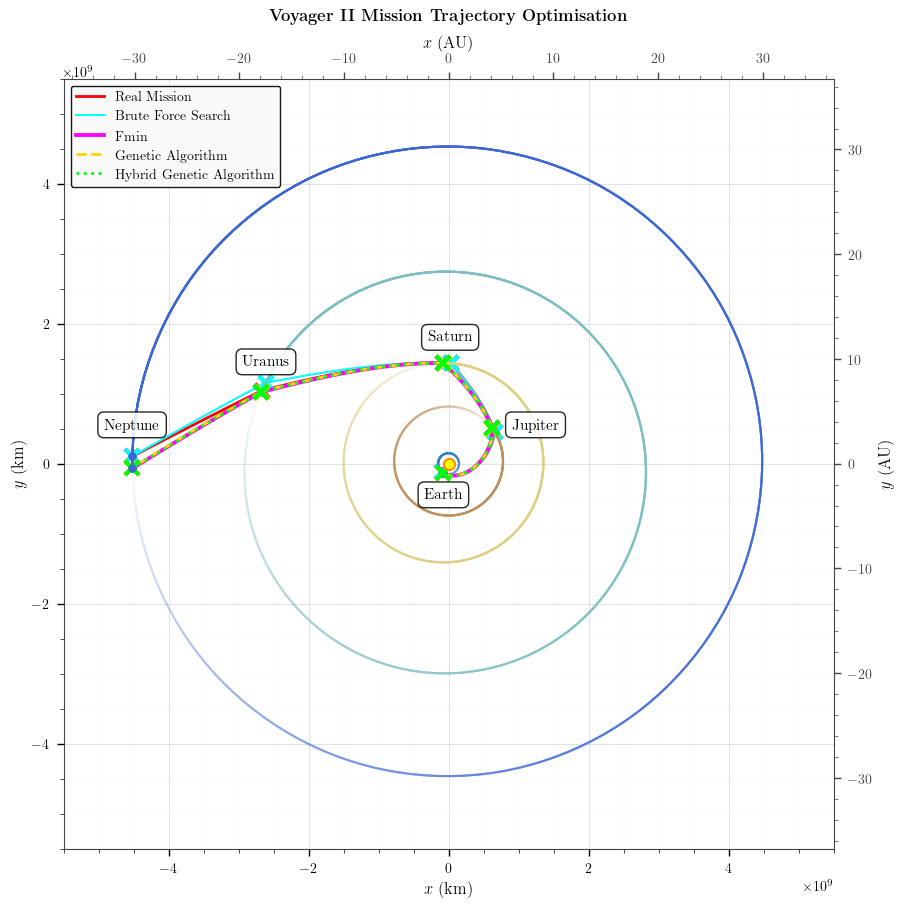

In [164]:
# Define different line styles for each plot
colours = {
    "Real Mission": "red",
    "Brute Force Algorithm": "cyan",
    "FMIN": "magenta",
    "GA": "gold",
    "GA + FMIN": "lime",
}

# Distinct line styles to prevent visual merging
line_styles = {
    "Real Mission": "-",              
    "Brute Force Algorithm": "-",    
    "FMIN": "-",                     
    "GA": '--',#(0, (5, 1)),               
    "GA + FMIN": ":",              
}

# Define different line widths for clarity
line_widths = {
    "Real Mission": 2,
    "Brute Force Algorithm": 1.5,
    "FMIN": 2.75,
    "GA": 2,
    "GA + FMIN": 2,
}

plt.rc("text", usetex=True)
plt.rc("font", family="serif")

# Create figure and axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
plotter = StaticOrbitPlotter(ax)

# Plot both missions on the same graph
plot_VoyagerII(
    date_departure,
    date_flyby_jupiter,
    date_flyby_saturn,
    date_flyby_uranus,
    date_flyby_neptune,
    colours["Real Mission"],
    label_suffix="(Real Mission)",
)

plot_VoyagerII(
    date_departure_BRUTE_MIN,
    date_flyby_jupiter_BRUTE_MIN,
    date_flyby_saturn_BRUTE_MIN,
    date_flyby_uranus_BRUTE_MIN,
    date_flyby_neptune_BRUTE_MIN,
    colours["Brute Force Algorithm"],
    label_suffix="(Brute Force Algorithm)",
)

plot_VoyagerII(
    date_departure_FMIN,
    date_flyby_jupiter_FMIN,
    date_flyby_saturn_FMIN,
    date_flyby_uranus_FMIN,
    date_flyby_neptune_FMIN,
    colours["FMIN"],
    label_suffix="(FMIN)",
)

plot_VoyagerII(
    date_departure_GA,
    date_flyby_jupiter_GA,
    date_flyby_saturn_GA,
    date_flyby_uranus_GA,
    date_flyby_neptune_GA,
    colours["GA"],
    label_suffix="(GA)",
)

plot_VoyagerII(
    date_departure_GA_FMIN_COMBINED,
    date_flyby_jupiter_GA_FMIN_COMBINED,
    date_flyby_saturn_GA_FMIN_COMBINED,
    date_flyby_uranus_GA_FMIN_COMBINED,
    date_flyby_neptune_GA_FMIN_COMBINED,
    colours["GA + FMIN"],
    label_suffix="(GA + FMIN)",
)

# Set fixed limits for primary axis
limit = 5.5e9
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_aspect("equal")  # Square aspect ratio

# Conversion factor (1 AU = 149,597,870.691 km)
km_to_AU = 1 / 149597870.691

# Create second set of axes for AU scale
# These won't be linked to the primary axes in the problematic way
ax_top = fig.add_axes(ax.get_position(), frameon=False)
ax_top.xaxis.tick_top()
ax_top.yaxis.tick_right()
ax_top.set_xlim(ax.get_xlim()[0] * km_to_AU, ax.get_xlim()[1] * km_to_AU)
ax_top.set_ylim(ax.get_ylim()[0] * km_to_AU, ax.get_ylim()[1] * km_to_AU)

# Improve axis labels with LaTeX formatting
ax.set_xlabel(r"$x$ (km)", fontsize=12)
ax.set_ylabel(r"$y$ (km)", fontsize=12)
ax_top.set_xlabel(r"$x$ (AU)", fontsize=12)
ax_top.set_ylabel(r"$y$ (AU)", fontsize=12)
ax_top.xaxis.set_label_position("top")
ax_top.yaxis.set_label_position("right")

# # Add grid
ax.grid(which="major", color="#CCCCCC", linewidth=0.5, linestyle="-", alpha=0.8)
ax.grid(which="minor", color="#DDDDDD", linewidth=0.25, linestyle=":", alpha=0.5)
ax.minorticks_on()
ax_top.grid(False)
ax_top.minorticks_on()

# Customise tick parameters
ax.tick_params(axis="both", which="major", labelsize=10, width=1, length=5, pad=5)
ax.tick_params(axis="both", which="minor", labelsize=8, width=0.5, length=3)
ax_top.tick_params(
    axis="both", which="major", labelsize=10, width=1, length=5, pad=5, colors="#444444"
)
ax_top.tick_params(
    axis="both", which="minor", labelsize=8, width=0.5, length=3, colors="#444444"
)

# Improved title with LaTeX formatting
plt.title(r"\textbf{Voyager II Mission Trajectory Optimisation}", pad=10)


# Function to update AU axes when primary axes change
def update_au_axes(event=None):
    ax_top.set_xlim(ax.get_xlim()[0] * km_to_AU, ax.get_xlim()[1] * km_to_AU)
    ax_top.set_ylim(ax.get_ylim()[0] * km_to_AU, ax.get_ylim()[1] * km_to_AU)
    fig.canvas.draw_idle()


# Connect the update function to the 'xlim_changed' and 'ylim_changed' events
ax.callbacks.connect("xlim_changed", update_au_axes)
ax.callbacks.connect("ylim_changed", update_au_axes)

# Apply line styles
for line in ax.get_lines():
    label = line.get_label()
    for key in line_styles:
        if key in label:
            line.set_linestyle(line_styles[key])
            line.set_linewidth(line_widths[key])

# Create custom legend
handles = [
    Line2D(
        [0],
        [0],
        color=colours["Real Mission"],
        ls=line_styles["Real Mission"],
        lw=line_widths["Real Mission"],
        label="Real Mission",
    ),
    Line2D(
        [0],
        [0],
        color=colours["Brute Force Algorithm"],
        ls=line_styles["Brute Force Algorithm"],
        lw=line_widths["Brute Force Algorithm"],
        label="Brute Force Search",
    ),
    Line2D(
        [0],
        [0],
        color=colours["FMIN"],
        ls=line_styles["FMIN"],
        lw=line_widths["FMIN"],
        label="Fmin",
    ),
    Line2D(
        [0],
        [0],
        color=colours["GA"],
        ls=line_styles["GA"],
        lw=line_widths["GA"],
        label="Genetic Algorithm",
    ),
    Line2D(
        [0],
        [0],
        color=colours["GA + FMIN"],
        ls=line_styles["GA + FMIN"],
        lw=line_widths["GA + FMIN"],
        label="Hybrid Genetic Algorithm",
    ),
]

# Sun
ax.plot(
    0,
    0,
    "o",
    markersize=8,
    markerfacecolor="#FFFF00",
    markeredgecolor="#FF8C00",
    markeredgewidth=1.5,
    zorder=100,
)

# Add legend with improved styling
legend = ax.legend(
    handles=handles,
    loc="upper left",
    ncol=1,
    frameon=True,
    edgecolor="black",
    fontsize=10,  # title=r"\textbf{Optimisation Methods}",
    title_fontsize=11,
)
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_facecolor("#F9F9F9")

# Planet colors
planet_colors = {
    "Earth": "#3366FF",  # Blue
    "Jupiter": "#FF9933",  # Orange
    "Saturn": "#FFCC33",  # Yellow
}

# Use the new label positions provided
planet_label_positions = {
    "Earth": (-0.35e9, -0.5e9),
    "Jupiter": (0.9e9, 0.5e9),
    "Saturn": (-0.3e9, 1.75e9),
    "Uranus": (-2.95e9, 1.4e9),
    "Neptune": (-4.925e9, 0.5e9),
}

# Add each planet marker and label
for planet, position in planet_label_positions.items():
    x, y = position

    # Use the absolute positions for labels instead of offsets
    label_x, label_y = planet_label_positions[planet]

    # Improved annotation style
    bbox_props = dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.85)
    ax.annotate(
        planet,
        xy=(x, y),  # Position of the planet
        xytext=(label_x, label_y),  # Absolute position for the label
        textcoords="data",  # Changed from 'offset points' to 'data'
        bbox=bbox_props,
        fontsize=11,
        fontweight="bold",
        zorder=101,  # Ensure labels appear on top of everything
    )  # Add arrow connecting label to planet

# Add a thin border around the plot for a more professional look
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("#444444")

output_figures.save_file(
    "voyager_II_trajectory_km_AU.png", dpi=500, bbox_inches="tight"
)

# Show plot
plt.show()
plt.close()

### 2-Axis Zoomed

Figure saved to: Voyager 2 - Figures/voyager_II_trajectory_zoom.png


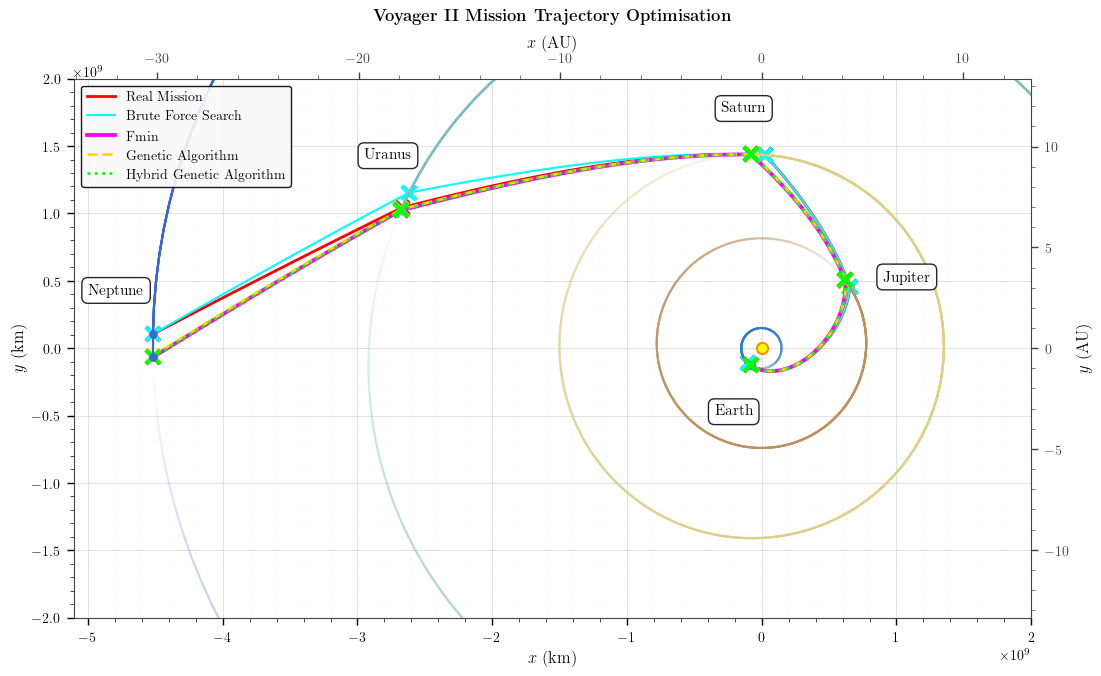

In [166]:
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

fig, ax = plt.subplots(figsize=(9, 7))
plotter = StaticOrbitPlotter(ax)

# Plot both missions on the same graph
plot_VoyagerII(
    date_departure,
    date_flyby_jupiter,
    date_flyby_saturn,
    date_flyby_uranus,
    date_flyby_neptune,
    colours["Real Mission"],
    label_suffix="(Real Mission)",
)

plot_VoyagerII(
    date_departure_BRUTE_MIN,
    date_flyby_jupiter_BRUTE_MIN,
    date_flyby_saturn_BRUTE_MIN,
    date_flyby_uranus_BRUTE_MIN,
    date_flyby_neptune_BRUTE_MIN,
    colours["Brute Force Algorithm"],
    label_suffix="(Brute Force Algorithm)",
)

plot_VoyagerII(
    date_departure_FMIN,
    date_flyby_jupiter_FMIN,
    date_flyby_saturn_FMIN,
    date_flyby_uranus_FMIN,
    date_flyby_neptune_FMIN,
    colours["FMIN"],
    label_suffix="(FMIN)",
)

plot_VoyagerII(
    date_departure_GA,
    date_flyby_jupiter_GA,
    date_flyby_saturn_GA,
    date_flyby_uranus_GA,
    date_flyby_neptune_GA,
    colours["GA"],
    label_suffix="(GA)",
)

plot_VoyagerII(
    date_departure_GA_FMIN_COMBINED,
    date_flyby_jupiter_GA_FMIN_COMBINED,
    date_flyby_saturn_GA_FMIN_COMBINED,
    date_flyby_uranus_GA_FMIN_COMBINED,
    date_flyby_neptune_GA_FMIN_COMBINED,
    colours["GA + FMIN"],
    label_suffix="(GA + FMIN)",
)

# Set fixed limits for primary axis
plt.xlim(-5.1e9, 2e9)
plt.ylim(-2e9, 2e9)
ax.set_aspect("equal")  # Square aspect ratio

# Conversion factor (1 AU = 149,597,870.691 km)
km_to_AU = 1 / 149597870.691

# Create second set of axes for AU scale
# These won't be linked to the primary axes in the problematic way
ax_top = fig.add_axes(ax.get_position(), frameon=False)
ax_top.xaxis.tick_top()
ax_top.yaxis.tick_right()
ax_top.set_xlim(ax.get_xlim()[0] * km_to_AU, ax.get_xlim()[1] * km_to_AU)
ax_top.set_ylim(ax.get_ylim()[0] * km_to_AU, ax.get_ylim()[1] * km_to_AU)

# Improve axis labels with LaTeX formatting
ax.set_xlabel(r"$x$ (km)", fontsize=12)
ax.set_ylabel(r"$y$ (km)", fontsize=12)
ax_top.set_xlabel(r"$x$ (AU)", fontsize=12)
ax_top.set_ylabel(r"$y$ (AU)", fontsize=12)
ax_top.xaxis.set_label_position("top")
ax_top.yaxis.set_label_position("right")

# # Add grid
ax.grid(which="major", color="#CCCCCC", linewidth=0.5, linestyle="-", alpha=0.8)
ax.grid(which="minor", color="#DDDDDD", linewidth=0.25, linestyle=":", alpha=0.5)
ax.minorticks_on()
ax_top.grid(False)
ax_top.minorticks_on()

# Customise tick parameters
ax.tick_params(axis="both", which="major", labelsize=10, width=1, length=5, pad=5)
ax.tick_params(axis="both", which="minor", labelsize=8, width=0.5, length=3)
ax_top.tick_params(
    axis="both", which="major", labelsize=10, width=1, length=5, pad=5, colors="#444444"
)
ax_top.tick_params(
    axis="both", which="minor", labelsize=8, width=0.5, length=3, colors="#444444"
)

# Improved title with LaTeX formatting
plt.title(r"\textbf{Voyager II Mission Trajectory Optimisation}", pad=10)


# Function to update AU axes when primary axes change
def update_au_axes(event=None):
    ax_top.set_xlim(ax.get_xlim()[0] * km_to_AU, ax.get_xlim()[1] * km_to_AU)
    ax_top.set_ylim(ax.get_ylim()[0] * km_to_AU, ax.get_ylim()[1] * km_to_AU)
    fig.canvas.draw_idle()


# Connect the update function to the 'xlim_changed' and 'ylim_changed' events
ax.callbacks.connect("xlim_changed", update_au_axes)
ax.callbacks.connect("ylim_changed", update_au_axes)

# Apply line styles
for line in ax.get_lines():
    label = line.get_label()
    for key in line_styles:
        if key in label:
            line.set_linestyle(line_styles[key])
            line.set_linewidth(line_widths[key])

# Create custom legend
handles = [
    Line2D(
        [0],
        [0],
        color=colours["Real Mission"],
        ls=line_styles["Real Mission"],
        lw=line_widths["Real Mission"],
        label="Real Mission",
    ),
    Line2D(
        [0],
        [0],
        color=colours["Brute Force Algorithm"],
        ls=line_styles["Brute Force Algorithm"],
        lw=line_widths["Brute Force Algorithm"],
        label="Brute Force Search",
    ),
    Line2D(
        [0],
        [0],
        color=colours["FMIN"],
        ls=line_styles["FMIN"],
        lw=line_widths["FMIN"],
        label="Fmin",
    ),
    Line2D(
        [0],
        [0],
        color=colours["GA"],
        ls=line_styles["GA"],
        lw=line_widths["GA"],
        label="Genetic Algorithm",
    ),
    Line2D(
        [0],
        [0],
        color=colours["GA + FMIN"],
        ls=line_styles["GA + FMIN"],
        lw=line_widths["GA + FMIN"],
        label="Hybrid Genetic Algorithm",
    ),
]

# Sun
ax.plot(
    0,
    0,
    "o",
    markersize=8,
    markerfacecolor="#FFFF00",
    markeredgecolor="#FF8C00",
    markeredgewidth=1.5,
    zorder=100,
)

# Add legend with improved styling
legend = ax.legend(
    handles=handles,
    loc="upper left",
    ncol=1,
    frameon=True,
    edgecolor="black",
    fontsize=10,  # title=r"\textbf{Optimisation Methods}",
    title_fontsize=11,
)
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_facecolor("#F9F9F9")

# Planet colors
planet_colors = {
    "Earth": "#3366FF",  # Blue
    "Jupiter": "#FF9933",  # Orange
    "Saturn": "#FFCC33",  # Yellow
}

# Use the new label positions provided
planet_label_positions = {
    "Earth": (-0.35e9, -0.5e9),
    "Jupiter": (0.9e9, 0.5e9),
    "Saturn": (-0.3e9, 1.75e9),
    "Uranus": (-2.95e9, 1.4e9),
    "Neptune": (-5e9, 0.4e9),
}

# Add each planet marker and label
for planet, position in planet_label_positions.items():
    x, y = position

    # Use the absolute positions for labels instead of offsets
    label_x, label_y = planet_label_positions[planet]

    # Improved annotation style
    bbox_props = dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.85)
    ax.annotate(
        planet,
        xy=(x, y),  # Position of the planet
        xytext=(label_x, label_y),  # Absolute position for the label
        textcoords="data",  # Changed from 'offset points' to 'data'
        bbox=bbox_props,
        fontsize=11,
        fontweight="bold",
        zorder=101,  # Ensure labels appear on top of everything
    )  # Add arrow connecting label to planet

# Add a thin border around the plot for a more professional look
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("#444444")

output_figures.save_file("voyager_II_trajectory_zoom.png", dpi=500, bbox_inches="tight")

# Show plot
plt.show()
plt.close()

## Final DeltaV \& Fuel Mass

In [168]:
deltaV_REAL, fuel_mass_REAL, data_dict_REAL

(14.928105732937752,
 1139.0,
 {'deltaV_injection (km/s)': 9.777779726682427,
  'deltaV_jupiter (km/s)': 0.03485226340972147,
  'rp_jupiter (km)': 2220733.0033500125,
  'vp_jupiter (km/s)': 13.264161047559059,
  'vp_esc_jupiter (km/s)': 10.682600912576174,
  'deflection_jupiter (deg)': 96.2960163290349,
  'deltaV_saturn (km/s)': 1.0288185212545642,
  'rp_saturn (km)': 403827.9428746656,
  'vp_saturn (km/s)': 17.457212514618856,
  'vp_esc_saturn (km/s)': 13.706139564574247,
  'deflection_saturn (deg)': 85.73086421478894,
  'deltaV_uranus (km/s)': 4.086655221591039,
  'rp_uranus (km)': 133605.1322173773,
  'vp_uranus (km/s)': 15.891238081241008,
  'vp_esc_uranus (km/s)': 9.313017043900006,
  'deflection_uranus (deg)': 22.164348557554597,
  'tof (days)': 4384.68570601847})

In [169]:
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN

(9.965627065328311,
 856.0135081245757,
 {'deltaV_injection (km/s)': 9.777779726682427,
  'deltaV_jupiter (km/s)': 0.03485226340972147,
  'rp_jupiter (km)': 2220733.0033500125,
  'vp_jupiter (km/s)': 13.264161047559059,
  'vp_esc_jupiter (km/s)': 10.682600912576174,
  'deflection_jupiter (deg)': 96.2960163290349,
  'deltaV_saturn (km/s)': 0.0819711822100011,
  'rp_saturn (km)': 385095.0255481553,
  'vp_saturn (km/s)': 17.717014962912074,
  'vp_esc_saturn (km/s)': 14.035548160975852,
  'deflection_saturn (deg)': 85.03234833966007,
  'deltaV_uranus (km/s)': 0.07102389302616174,
  'rp_uranus (km)': 121875.94940717192,
  'vp_uranus (km/s)': 17.652953215434174,
  'vp_esc_uranus (km/s)': 9.750860929686262,
  'deflection_uranus (deg)': 22.953523176610197,
  'tof (days)': 4384.68570601847})

In [170]:
deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN

(9.37125750134365,
 816.7817510508315,
 {'deltaV_injection (km/s)': 9.35789550243903,
  'deltaV_jupiter (km/s)': 0.0009168183205279234,
  'rp_jupiter (km)': 2802517.371817503,
  'vp_jupiter (km/s)': 11.834271643601488,
  'vp_esc_jupiter (km/s)': 9.50935412829766,
  'deflection_jupiter (deg)': 94.14765367850407,
  'deltaV_saturn (km/s)': 2.6201263381153694e-11,
  'rp_saturn (km)': 516702.31495290494,
  'vp_saturn (km/s)': 15.304134784770053,
  'vp_esc_saturn (km/s)': 12.11694480065466,
  'deflection_saturn (deg)': 84.29926641857209,
  'deltaV_uranus (km/s)': 0.012445180557890012,
  'rp_uranus (km)': 171918.01181510068,
  'vp_uranus (km/s)': 15.542222697049406,
  'vp_esc_uranus (km/s)': 8.209964483111364,
  'deflection_uranus (deg)': 20.471397443524044,
  'tof (days)': 4739.194273761466})

In [171]:
deltaV_GA, fuel_mass_GA, data_dict_GA

(9.36152032789823,
 816.1285632058713,
 {'deltaV_injection (km/s)': 9.361520326659656,
  'deltaV_jupiter (km/s)': 7.18996417958806e-10,
  'rp_jupiter (km)': 2770004.045423409,
  'vp_jupiter (km/s)': 11.901891880948948,
  'vp_esc_jupiter (km/s)': 9.56500003203136,
  'deflection_jupiter (deg)': 94.25132811528943,
  'deltaV_saturn (km/s)': 2.1593926646801265e-10,
  'rp_saturn (km)': 507478.59536726406,
  'vp_saturn (km/s)': 15.441204304495137,
  'vp_esc_saturn (km/s)': 12.22656521092557,
  'deflection_saturn (deg)': 84.34962634943922,
  'deltaV_uranus (km/s)': 3.03638003629203e-10,
  'rp_uranus (km)': 168233.3340319893,
  'vp_uranus (km/s)': 15.670785764613605,
  'vp_esc_uranus (km/s)': 8.299385590522153,
  'deflection_uranus (deg)': 20.627619471411386,
  'tof (days)': 4716.798433988326})

In [172]:
deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED

(9.358046430397152,
 815.8954449993682,
 {'deltaV_injection (km/s)': 9.358037063778704,
  'deltaV_jupiter (km/s)': 8.953961387447862e-06,
  'rp_jupiter (km)': 2800740.34130855,
  'vp_jupiter (km/s)': 11.837743359432663,
  'vp_esc_jupiter (km/s)': 9.51237042590936,
  'deflection_jupiter (deg)': 94.15970492764589,
  'deltaV_saturn (km/s)': 9.521272659185342e-13,
  'rp_saturn (km)': 516021.4711421794,
  'vp_saturn (km/s)': 15.314127824503991,
  'vp_esc_saturn (km/s)': 12.124935773829252,
  'deflection_saturn (deg)': 84.30292432886259,
  'deltaV_uranus (km/s)': 4.126561083950264e-07,
  'rp_uranus (km)': 171822.4661678232,
  'vp_uranus (km/s)': 15.549357779710983,
  'vp_esc_uranus (km/s)': 8.212246831191617,
  'deflection_uranus (deg)': 20.479259426751486,
  'tof (days)': 4738.961814830298})

In [173]:
deltaVs = {
    "REAL": deltaV_REAL,
    "Brute Force": deltaV_BRUTE_MIN,
    "Fmin": deltaV_FMIN,
    "Genetic Algorithm": deltaV_GA,
    "GA + Fmin": deltaV_GA_FMIN_COMBINED,
}

for method in deltaVs:
    print(f"{method}: {deltaVs[method]:.4f} km/s")

REAL: 14.9281 km/s
Brute Force: 9.9656 km/s
Fmin: 9.3713 km/s
Genetic Algorithm: 9.3615 km/s
GA + Fmin: 9.3580 km/s


In [174]:
data_dict_REAL

{'deltaV_injection (km/s)': 9.777779726682427,
 'deltaV_jupiter (km/s)': 0.03485226340972147,
 'rp_jupiter (km)': 2220733.0033500125,
 'vp_jupiter (km/s)': 13.264161047559059,
 'vp_esc_jupiter (km/s)': 10.682600912576174,
 'deflection_jupiter (deg)': 96.2960163290349,
 'deltaV_saturn (km/s)': 1.0288185212545642,
 'rp_saturn (km)': 403827.9428746656,
 'vp_saturn (km/s)': 17.457212514618856,
 'vp_esc_saturn (km/s)': 13.706139564574247,
 'deflection_saturn (deg)': 85.73086421478894,
 'deltaV_uranus (km/s)': 4.086655221591039,
 'rp_uranus (km)': 133605.1322173773,
 'vp_uranus (km/s)': 15.891238081241008,
 'vp_esc_uranus (km/s)': 9.313017043900006,
 'deflection_uranus (deg)': 22.164348557554597,
 'tof (days)': 4384.68570601847}

In [175]:
deltaV_injection_list = {
    "REAL": data_dict_REAL["deltaV_injection (km/s)"],
    "Brute Force": data_dict_BRUTE_MIN["deltaV_injection (km/s)"],
    "Fmin": data_dict_FMIN["deltaV_injection (km/s)"],
    "Genetic Algorithm": data_dict_GA["deltaV_injection (km/s)"],
    "GA + Fmin": data_dict_GA_FMIN_COMBINED["deltaV_injection (km/s)"],
}

for method in deltaV_injection_list:
    print(f"{method}: {deltaV_injection_list[method]:.4f} km/s")

REAL: 9.7778 km/s
Brute Force: 9.7778 km/s
Fmin: 9.3579 km/s
Genetic Algorithm: 9.3615 km/s
GA + Fmin: 9.3580 km/s


In [176]:
deltaV_jupiter_flyby_list = {
    "REAL": data_dict_REAL["deltaV_jupiter (km/s)"],
    "Brute Force": data_dict_BRUTE_MIN["deltaV_jupiter (km/s)"],
    "Fmin": data_dict_FMIN["deltaV_jupiter (km/s)"],
    "Genetic Algorithm": data_dict_GA["deltaV_jupiter (km/s)"],
    "GA + Fmin": data_dict_GA_FMIN_COMBINED["deltaV_jupiter (km/s)"],
}

for method in deltaV_jupiter_flyby_list:
    print(f"{method}: {deltaV_jupiter_flyby_list[method]} km/s")

REAL: 0.03485226340972147 km/s
Brute Force: 0.03485226340972147 km/s
Fmin: 0.0009168183205279234 km/s
Genetic Algorithm: 7.18996417958806e-10 km/s
GA + Fmin: 8.953961387447862e-06 km/s


In [177]:
deltaV_saturn_flyby_list = {
    "REAL": data_dict_REAL["deltaV_saturn (km/s)"],
    "Brute Force": data_dict_BRUTE_MIN["deltaV_saturn (km/s)"],
    "Fmin": data_dict_FMIN["deltaV_saturn (km/s)"],
    "Genetic Algorithm": data_dict_GA["deltaV_saturn (km/s)"],
    "GA + Fmin": data_dict_GA_FMIN_COMBINED["deltaV_saturn (km/s)"],
}

for method in deltaV_saturn_flyby_list:
    print(f"{method}: {deltaV_saturn_flyby_list[method]} km/s")

REAL: 1.0288185212545642 km/s
Brute Force: 0.0819711822100011 km/s
Fmin: 2.6201263381153694e-11 km/s
Genetic Algorithm: 2.1593926646801265e-10 km/s
GA + Fmin: 9.521272659185342e-13 km/s


In [178]:
deltaV_uranus_flyby_list = {
    "REAL": data_dict_REAL["deltaV_uranus (km/s)"],
    "Brute Force": data_dict_BRUTE_MIN["deltaV_uranus (km/s)"],
    "Fmin": data_dict_FMIN["deltaV_uranus (km/s)"],
    "Genetic Algorithm": data_dict_GA["deltaV_uranus (km/s)"],
    "GA + Fmin": data_dict_GA_FMIN_COMBINED["deltaV_uranus (km/s)"],
}

for method in deltaV_uranus_flyby_list:
    print(f"{method}: {deltaV_uranus_flyby_list[method]} km/s")

REAL: 4.086655221591039 km/s
Brute Force: 0.07102389302616174 km/s
Fmin: 0.012445180557890012 km/s
Genetic Algorithm: 3.03638003629203e-10 km/s
GA + Fmin: 4.126561083950264e-07 km/s


In [179]:
tof_list = {
    "REAL": data_dict_REAL["tof (days)"],
    "Brute Force": data_dict_BRUTE_MIN["tof (days)"],
    "Fmin": data_dict_FMIN["tof (days)"],
    "Genetic Algorithm": data_dict_GA["tof (days)"],
    "GA + Fmin": data_dict_GA_FMIN_COMBINED["tof (days)"],
}

for method in tof_list:
    print(f"{method}: {tof_list[method]:.2f} days")

REAL: 4384.69 days
Brute Force: 4384.69 days
Fmin: 4739.19 days
Genetic Algorithm: 4716.80 days
GA + Fmin: 4738.96 days


In [180]:
fuel_mass_values = {
    "REAL": fuel_mass_REAL,
    "Brute Force": fuel_mass_BRUTE_MIN,
    "Fmin": fuel_mass_FMIN,
    "Genetic Algorithm": fuel_mass_GA,
    "GA + Fmin": fuel_mass_GA_FMIN_COMBINED,
}

for method in fuel_mass_values:
    print(f"{method}: {fuel_mass_values[method]:.2f} kg")

REAL: 1139.00 kg
Brute Force: 856.01 kg
Fmin: 816.78 kg
Genetic Algorithm: 816.13 kg
GA + Fmin: 815.90 kg


In [181]:
execution_time_dict = {
    "Brute Force": execution_time_BRUTE_FORCE,
    "Fmin": execution_time_FMIN,
    "Genetic Algorithm": execution_time_GA,
    "GA + Fmin": execution_time_GA_FMIN_COMBINED,
}

for method, time in execution_time_dict.items():
    print(f"{method}: {time:.2f} seconds")

Brute Force: 4812.23 seconds
Fmin: 5.94 seconds
Genetic Algorithm: 634.50 seconds
GA + Fmin: 15.01 seconds


In [182]:
from datetime import datetime

def format_dates_to_standard(date_list):
    formatted_dates = {}
    
    for method in date_list:
        # Check if the date is already a datetime object
        if isinstance(date_list[method], datetime):
            formatted_date = date_list[method].strftime("%d/%m/%Y %H:%M:%S")
        else:
            try:
                # Try to parse the string into a datetime object
                format_string = "%Y-%m-%d %H:%M:%S.%f" if "." in str(date_list[method]) else "%Y-%m-%d %H:%M"
                dt = datetime.strptime(str(date_list[method]), format_string)
                formatted_date = dt.strftime("%d/%m/%Y %H:%M:%S")
            except ValueError:
                # If parsing fails, keep the original value
                formatted_date = str(date_list[method])
                print(f"Warning: Could not parse date for {method}: {date_list[method]}")
        
        formatted_dates[method] = formatted_date
    
    return formatted_dates

In [183]:
date_departure_list = {
    "REAL": date_departure,
    "Brute Force": date_departure_BRUTE_MIN,
    "Fmin": date_departure_FMIN,
    "Genetic Algorithm": date_departure_GA,
    "GA + Fmin": date_departure_GA_FMIN_COMBINED,
}

for method in date_departure_list:
    print(f"{method}: {date_departure_list[method]}")

print()

format_dates_to_standard(date_departure_list)

REAL: 1977-08-23 11:29:11
Brute Force: 1977-08-23 11:29:11.000
Fmin: 1977-09-02 23:16:50.675
Genetic Algorithm: 1977-09-02 19:25:44.464
GA + Fmin: 1977-09-02 20:59:15.045



{'REAL': '1977-08-23 11:29:11',
 'Brute Force': '23/08/1977 11:29:11',
 'Fmin': '02/09/1977 23:16:50',
 'Genetic Algorithm': '02/09/1977 19:25:44',
 'GA + Fmin': '02/09/1977 20:59:15'}

In [184]:
date_flyby_jupiter_list = {
    "REAL": date_flyby_jupiter,
    "Brute Force": date_flyby_jupiter_BRUTE_MIN,
    "Fmin": date_flyby_jupiter_FMIN,
    "Genetic Algorithm": date_flyby_jupiter_GA,
    "GA + Fmin": date_flyby_jupiter_GA_FMIN_COMBINED,
}

for method in date_flyby_jupiter_list:
    print(f"{method}: {date_flyby_jupiter_list[method]}")

print()

format_dates_to_standard(date_flyby_jupiter_list)

REAL: 1979-07-09 22:29:51
Brute Force: 1979-07-09 22:29:51.000
Fmin: 1979-09-03 05:06:38.181
Genetic Algorithm: 1979-08-31 07:19:47.019
GA + Fmin: 1979-09-03 01:38:02.079



{'REAL': '1979-07-09 22:29:51',
 'Brute Force': '09/07/1979 22:29:51',
 'Fmin': '03/09/1979 05:06:38',
 'Genetic Algorithm': '31/08/1979 07:19:47',
 'GA + Fmin': '03/09/1979 01:38:02'}

In [185]:
date_flyby_saturn_list = {
    "REAL": date_flyby_saturn,
    "Brute Force": date_flyby_saturn_BRUTE_MIN,
    "Fmin": date_flyby_saturn_FMIN,
    "Genetic Algorithm": date_flyby_saturn_GA,
    "GA + Fmin": date_flyby_saturn_GA_FMIN_COMBINED,
}

for method in date_flyby_saturn_list:
    print(f"{method}: {date_flyby_saturn_list[method]}")

print()

format_dates_to_standard(date_flyby_saturn_list)

REAL: 1981-08-26 03:24:57
Brute Force: 1981-08-26 03:24:57.000
Fmin: 1982-01-02 11:28:33.046
Genetic Algorithm: 1981-12-25 18:35:25.189
GA + Fmin: 1982-01-01 22:47:12.250



{'REAL': '1981-08-26 03:24:57',
 'Brute Force': '26/08/1981 03:24:57',
 'Fmin': '02/01/1982 11:28:33',
 'Genetic Algorithm': '25/12/1981 18:35:25',
 'GA + Fmin': '01/01/1982 22:47:12'}

In [186]:
date_flyby_uranus_list = {
    "REAL": date_flyby_uranus,
    "Brute Force": date_flyby_uranus_BRUTE_MIN,
    "Fmin": date_flyby_uranus_FMIN,
    "Genetic Algorithm": date_flyby_uranus_GA,
    "GA + Fmin": date_flyby_uranus_GA_FMIN_COMBINED,
}

for method in date_flyby_uranus_list:
    print(f"{method}: {date_flyby_uranus_list[method]}")

print()

format_dates_to_standard(date_flyby_uranus_list)

REAL: 1986-08-24 17:59:47
Brute Force: 1986-01-28 04:16:55.571
Fmin: 1986-10-03 18:21:11.480
Genetic Algorithm: 1986-09-17 15:09:00.636
GA + Fmin: 1986-10-02 14:31:04.214



{'REAL': '1986-08-24 17:59:47',
 'Brute Force': '28/01/1986 04:16:55',
 'Fmin': '03/10/1986 18:21:11',
 'Genetic Algorithm': '17/09/1986 15:09:00',
 'GA + Fmin': '02/10/1986 14:31:04'}

In [187]:
date_flyby_neptune_list = {
    "REAL": date_flyby_neptune,
    "Brute Force": date_flyby_neptune_BRUTE_MIN,
    "Fmin": date_flyby_neptune_FMIN,
    "Genetic Algorithm": date_flyby_neptune_GA,
    "GA + Fmin": date_flyby_neptune_GA_FMIN_COMBINED,
}

for method in date_flyby_neptune_list:
    print(f"{method}: {date_flyby_neptune_list[method]}")

print()

format_dates_to_standard(date_flyby_neptune_list)

REAL: 1989-08-25 03:56:36
Brute Force: 1989-08-25 03:56:36.000
Fmin: 1990-08-25 03:56:35.928
Genetic Algorithm: 1990-08-02 14:35:29.160
GA + Fmin: 1990-08-24 20:04:15.847



{'REAL': '1989-08-25 03:56:36',
 'Brute Force': '25/08/1989 03:56:36',
 'Fmin': '25/08/1990 03:56:35',
 'Genetic Algorithm': '02/08/1990 14:35:29',
 'GA + Fmin': '24/08/1990 20:04:15'}

In [188]:
#change_in_dates_list_GA

### Comparsion Table

In [190]:
methods = ["REAL", "Brute Force", "Fmin", "Genetic Algorithm", "GA + Fmin"]

In [191]:
data = {
    "Total Delta-V (km/s)": [deltaVs[method] for method in methods],
    "Injection Delta-V (km/s)": [deltaV_injection_list[method] for method in methods],
    "Jupiter Flyby Delta-V (km/s)": [deltaV_jupiter_flyby_list[method] for method in methods],
    "Saturn Flyby Delta-V (km/s)": [deltaV_saturn_flyby_list[method] for method in methods],
    "Uranus Flyby Delta-V (km/s)": [deltaV_uranus_flyby_list[method] for method in methods],
    "Total Fuel Mass (kg)": [fuel_mass_values[method] for method in methods],
    "TOF (days)": [tof_list[method] for method in methods],
    "Departure Change (days)": np.array(
        [
            0,
            change_in_dates_list_BRUTE_MIN[0],
            change_in_dates_list_FMIN[0],
            change_in_dates_list_GA[0],
            change_in_dates_list_GA_FMIN_COMBINED[0],
        ]
    )
    * (-1),
    "Jupiter Flyby Change (days)": np.array(
        [
            0,
            change_in_dates_list_BRUTE_MIN[1],
            change_in_dates_list_FMIN[1],
            change_in_dates_list_GA[1],
            change_in_dates_list_GA_FMIN_COMBINED[1],
        ]
    )
    * (-1),
    "Saturn Flyby Change (days)": np.array(
        [
            0,
            change_in_dates_list_BRUTE_MIN[2],
            change_in_dates_list_FMIN[2],
            change_in_dates_list_GA[2],
            change_in_dates_list_GA_FMIN_COMBINED[2],
        ]
    )
    * (-1),
    "Uranus Flyby Change (days)": np.array(
        [
            0,
            change_in_dates_list_BRUTE_MIN[3],
            change_in_dates_list_FMIN[3],
            change_in_dates_list_GA[3],
            change_in_dates_list_GA_FMIN_COMBINED[3],
        ]
    )
    * (-1),
    "Neptune Flyby Change (days)": np.array(
        [
            0,
            change_in_dates_list_BRUTE_MIN[4],
            change_in_dates_list_FMIN[4],
            change_in_dates_list_GA[4],
            change_in_dates_list_GA_FMIN_COMBINED[4],
        ]
    )
    * (-1),
    "Execution Time (s)": [execution_time_dict.get(method, None) for method in methods],
}

df = pd.DataFrame(data, index=methods)
df

,Total Delta-V (km/s),Injection Delta-V (km/s),Jupiter Flyby Delta-V (km/s),Saturn Flyby Delta-V (km/s),Uranus Flyby Delta-V (km/s),Total Fuel Mass (kg),TOF (days),Departure Change (days),Jupiter Flyby Change (days),Saturn Flyby Change (days),Uranus Flyby Change (days),Neptune Flyby Change (days),Execution Time (s)
REAL,14.928106,9.777780,3.485226e-02,1.028819e+00,4.086655e+00,1139.000000,4384.685706,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,NaN
Brute Force,9.965627,9.777780,3.485226e-02,8.197118e-02,7.102389e-02,856.013508,4384.685706,-0.000000,-0.000000,-0.000000,-208.571429,-0.000000,4812.231635
Fmin,9.371258,9.357896,9.168183e-04,2.620126e-11,1.244518e-02,816.781751,4739.194274,10.491431,55.275546,129.335834,40.014867,364.999999,5.943193
Genetic Algorithm,9.361520,9.361520,7.189964e-10,2.159393e-10,3.036380e-10,816.128563,4716.798434,10.330943,52.368009,121.632271,23.881408,342.443671,634.499403
GA + Fmin,9.358046,9.358037,8.953961e-06,9.521273e-13,4.126561e-07,815.895445,4738.961815,10.395880,55.130684,128.807121,38.855060,364.671989,15.013292


In [192]:
df = pd.DataFrame(data, index=methods)
df_transposed = df.transpose()
#df_transposed.to_csv("voyager2_mission_comparison.csv")
df_transposed

,REAL,Brute Force,Fmin,Genetic Algorithm,GA + Fmin
Total Delta-V (km/s),14.928106,9.965627,9.371258e+00,9.361520e+00,9.358046e+00
Injection Delta-V (km/s),9.777780,9.777780,9.357896e+00,9.361520e+00,9.358037e+00
Jupiter Flyby Delta-V (km/s),0.034852,0.034852,9.168183e-04,7.189964e-10,8.953961e-06
Saturn Flyby Delta-V (km/s),1.028819,0.081971,2.620126e-11,2.159393e-10,9.521273e-13
Uranus Flyby Delta-V (km/s),4.086655,0.071024,1.244518e-02,3.036380e-10,4.126561e-07
Total Fuel Mass (kg),1139.000000,856.013508,8.167818e+02,8.161286e+02,8.158954e+02
TOF (days),4384.685706,4384.685706,4.739194e+03,4.716798e+03,4.738962e+03
Departure Change (days),-0.000000,-0.000000,1.049143e+01,1.033094e+01,1.039588e+01
Jupiter Flyby Change (days),-0.000000,-0.000000,5.527555e+01,5.236801e+01,5.513068e+01
Saturn Flyby Change (days),-0.000000,-0.000000,1.293358e+02,1.216323e+02,1.288071e+02


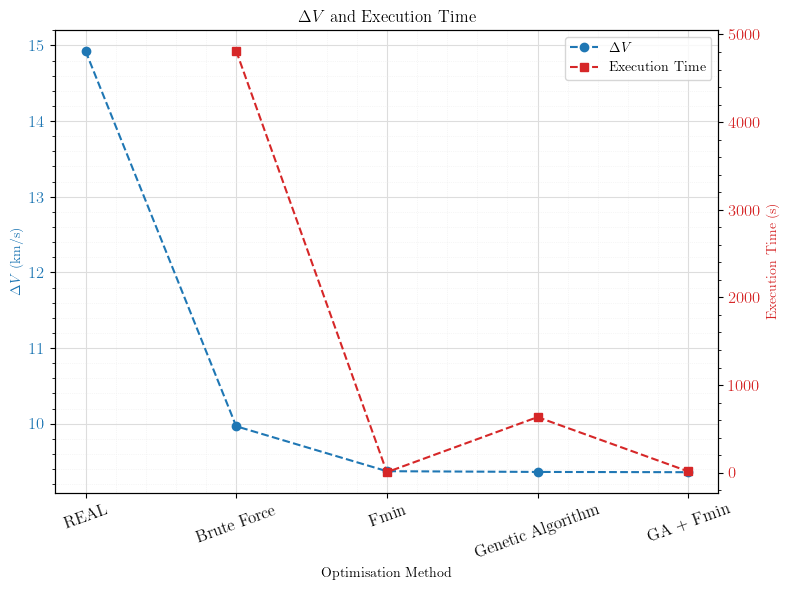

In [193]:
# Apply LaTeX styling
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

deltaV_values_method = [deltaVs[name] for name in methods]
execution_methods = [m for m in methods if m in execution_time_dict]
execution_times = [execution_time_dict[name] for name in execution_methods]

# Convert to numpy arrays for plotting
deltaV_values_method = np.array(deltaV_values_method, dtype=float)
execution_times = np.array(execution_times, dtype=float)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot delta-V
ax1.set_xlabel("Optimisation Method")
ax1.set_ylabel("$\Delta V$ (km/s)", color="tab:blue")
ax1.plot(
    methods,
    deltaV_values_method,
    marker="o",
    linestyle="--",
    color="tab:blue",
    label="$\Delta V$",
)
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, ha="center", rotation=20, fontsize=12)

# Secondary axis for execution time
ax2 = ax1.twinx()
ax2.set_ylabel("Execution Time (s)", color="tab:red")
ax2.plot(
    execution_methods,
    execution_times,
    marker="s",
    linestyle="--",
    color="tab:red",
    label="Execution Time",
)
ax2.tick_params(axis="y", labelcolor="tab:red")

# Add legends
ax1.legend(
    loc="upper right",
    handles=ax1.lines + ax2.lines,
    labels=["$\Delta V$", "Execution Time"],
)

# Improve grid and ticks
ax1.grid(which="major", color="#DDDDDD", linewidth=0.8)
ax1.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax1.minorticks_on()
ax2.minorticks_on()
ax1.tick_params(axis="both", which="major", labelsize=12)
ax2.tick_params(axis="both", which="major", labelsize=12)

ax1.tick_params(axis="x", which="minor", length=0)

# ax1.set_ylim(9.3,10.4)
# ax2.set_ylim(0,500)

# Show title
plt.title("$\Delta V$ and Execution Time")
plt.tight_layout()
plt.show()
plt.close()

Figure saved to: Voyager 2 - Figures/voyager_II_time_execution_comparison.png


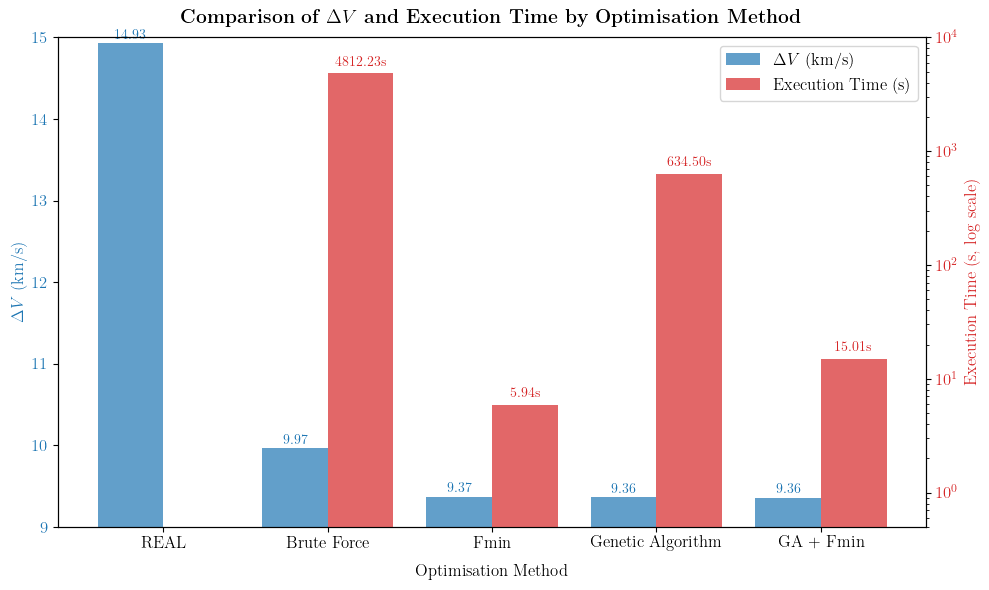

In [194]:
# Get methods without "REAL" for execution time plotting
execution_methods = [m for m in methods if m in execution_time_dict]
execution_times = [execution_time_dict[name] for name in execution_methods]

# Get all methods for deltaV plotting
deltaV_values_method = [deltaVs[name] for name in methods]

# Convert to numpy arrays for plotting
deltaV_values_method = np.array(deltaV_values_method, dtype=float)
execution_times = np.array(execution_times, dtype=float)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot delta-V with markers
ax1.set_xlabel("Optimisation Method", labelpad=10, fontsize=12)
ax1.set_ylabel("$\Delta V$ (km/s)", color="tab:blue", fontsize=12)
bars1 = ax1.bar(
    np.arange(len(methods)) - 0.2,
    deltaV_values_method,
    width=0.4,
    color="tab:blue",
    alpha=0.7,
    label="$\Delta V$",
)
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, ha="center", fontsize=12)
ax1.set_ylim(9.3, 10.4)

# Add data labels to bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.02,
        f"{deltaV_values_method[i]:.2f}",
        ha="center",
        va="bottom",
        color="tab:blue",
        fontsize=10,
    )

# Secondary axis for execution time (logarithmic scale)
ax2 = ax1.twinx()
ax2.set_ylabel("Execution Time (s, log scale)", color="tab:red", fontsize=12)

# Find the indices of execution methods in the original methods list
exec_indices = [methods.index(m) for m in execution_methods]
bars2 = ax2.bar(
    np.array(exec_indices) + 0.2,
    execution_times,
    width=0.4,
    color="tab:red",
    alpha=0.7,
    label="Execution Time",
)
ax2.set_yscale("log")  # Use logarithmic scale
ax2.tick_params(axis="y", labelcolor="tab:red")

# Add data labels to execution time bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height * 1.1,
        f"{execution_times[i]:.2f}s",
        ha="center",
        va="bottom",
        color="tab:red",
        fontsize=10,
    )

# With this updated code:
handles = [bars1[0], bars2[0]]  # Get the first bar from each set
labels = ["$\Delta V$ (km/s)", "Execution Time (s)"]
ax1.legend(handles, labels, loc="upper right", fontsize=12)

# Improve grid and ticks
#ax1.grid(which="major", axis="y", color="#DDDDDD", linewidth=0.8, alpha=0.5)
ax1.tick_params(axis="both", which="major", labelsize=12)
ax2.tick_params(axis="both", which="major", labelsize=12)

ax1.set_ylim(9, 15)
ax2.set_ylim(5e-1, 10**4)

# Show title
plt.title(
    r"\textbf{Comparison of $\Delta V$ and Execution Time by Optimisation Method}",
    fontsize=14,
    pad=10,
)
plt.tight_layout()

output_figures.save_file(
    "voyager_II_time_execution_comparison.png", dpi=500, bbox_inches="tight"
)
plt.show()

In [195]:
# math.factorial(20)

## Variation in Heliocentric Velocity along Voyager I Trajectory

### Voyager I NASA Mission Data

Using, https://plotdigitizer.com/app on the real mission NASA data presented in textbook **Hahn-A-Basic-Calculus-of-Planetary-Orbits-and-Interplanetary-Flight-2020-pdf**.

In [198]:
file_path = output_pickle.get_path('V2.csv')
data2 = pd.read_csv(file_path)

data2['x_km'] = data2['x'] * 149597870.691 

V2_NASA_distance_from_Sun_km = data2['x_km']
V2_NASA_distance_from_Sun_AU = data2['x']  # in AU where 1 AU = 149597870.691 km
V2_NASA_velocity = data2[' y']

data2

,x,y,x_km
0,0.982667,39.034907,1.470049e+08
1,1.106842,36.829962,1.655812e+08
2,1.281253,34.222948,1.916728e+08
3,1.459839,31.694050,2.183888e+08
4,1.671518,28.857742,2.500555e+08
5,1.922849,26.352738,2.876541e+08
6,2.232168,23.640037,3.339277e+08
7,2.719179,20.187530,4.067834e+08
8,3.326190,17.032554,4.975910e+08
9,3.962270,14.320542,5.927472e+08


In [199]:
r_esc = np.linspace(1e-99,6e9,1000)
v_esc = np.sqrt(2 * mu_sun/r_esc)

### Comparison with Algorithms

In [201]:
# Known parameters K = [e,a,i,Omega,w,M]
mu = 1.327e11  # Sun's gravitational parameter (km³/s²)

# Compute true anomaly (theta) for 0<e<1 (elliptical orbit)
def elliptic_theta(M, e):
    def find_E(E):
        return E - e * np.sin(E) - M

    E = fsolve(find_E, 0.01)[0] # Eccentric Anomaly
    theta = 2 * np.arctan(np.tan(E / 2) * np.sqrt((1 + e) / (1 - e)))
    return theta


# Compute true anomaly (theta)  for e=1 (parabolic orbit)
def parabolic_theta(M):
    var = 3 * M + np.sqrt(9 * M**2 + 1)
    B = var ** (1 / 3) - var ** (-1 / 3) # Barker Parameter
    theta = 2 * np.arctan(B)
    return theta


# Compute true anomaly (theta)  for e>1 (hyperbolic orbit)
def hyperbolic_theta(M, e):
    def find_F(F):
        return e * np.sinh(F) - F - M

    F = fsolve(find_F, 0.01)[0] # Hyperbolic Eccentric Anomaly
    theta = 2 * np.arctan(np.tanh(F / 2) * np.sqrt((e + 1) / (e - 1)))
    return theta

def forwardTransformation(e, a, i, Omega, w, M, mu, p=None):
    # Compute semi-latus rectum p if not provided
    if p is None:
        if e < 1:
            p = a * (1 - e**2)
        elif e == 1:
            p = 2 * a  # For parabolic orbits, p = 2q where q is periapsis distance
        else:  # e > 1
            p = a * (e**2 - 1)  # For hyperbolic orbits
    
    # Verify that p is positive
    if p <= 0:
        raise ValueError(f"Semi-latus rectum p must be positive, got {p}")
    
    # Compute specific angular momentum h
    h = np.sqrt(mu * p)
    
    # Compute true anomaly from mean anomaly based on orbit type
    if e < 1:
        theta = elliptic_theta(M, e)
    elif e == 1:
        theta = parabolic_theta(M)
    else:
        theta = hyperbolic_theta(M, e)
    
    # Compute radius
    r = p / (1 + e * np.cos(theta))
    
    # Compute position and velocity in perifocal coordinates
    r_perifocal = np.array([r * np.cos(theta), r * np.sin(theta), 0])
    v_perifocal = (mu / h) * np.array([-np.sin(theta), e + np.cos(theta), 0])
    
    # Compute transformation matrix Q
    cos_Omega, sin_Omega = np.cos(Omega), np.sin(Omega)
    cos_w, sin_w = np.cos(w), np.sin(w)
    cos_i, sin_i = np.cos(i), np.sin(i)
    
    Q = np.array([
        [cos_Omega * cos_w - sin_Omega * sin_w * cos_i,
         -cos_Omega * sin_w - sin_Omega * cos_i * cos_w,
         sin_Omega * sin_i],
        [sin_Omega * cos_w + cos_Omega * cos_i * sin_w,
         -sin_Omega * sin_w + cos_Omega * cos_i * cos_w,
         -cos_Omega * sin_i],
        [sin_i * sin_w, sin_i * cos_w, cos_i]
    ])
    
    # Transform to reference frame
    r_reference = np.dot(Q, r_perifocal)
    v_reference = np.dot(Q, v_perifocal)
    
    return r_reference, v_reference

In [202]:
def backwardTransformation(r, v, mu):
    # Ensure inputs are numpy arrays
    r = np.array(r)
    v = np.array(v)
    
    # Compute magnitude of position vector
    r_mag = np.linalg.norm(r)
    
    # 1. Compute angular momentum vector h
    h_vec = np.cross(r, v)
    h_mag = np.linalg.norm(h_vec)
    
    # 2. Compute eccentricity vector
    e_vec = np.cross(v, h_vec) / mu - r / r_mag
    e_mag = np.linalg.norm(e_vec)
    
    # 3. Compute semi-latus rectum (parameter)
    p = h_mag**2 / mu
    
    # 4. Compute semi-major axis
    a = p / (1 - e_mag**2)
    
    # 5. Compute inclination using arccos(h_z/h)
    i = np.arccos(h_vec[2] / h_mag)
    
    # 6. Compute longitude of ascending node using atan2(h_x, -h_y)
    Omega = np.arctan2(h_vec[0], -h_vec[1]) % (2 * np.pi)
    
    # 7. Compute the argument of periapsis
    w = np.arctan2(
        e_vec[2] / np.sin(i),
        e_vec[1] * np.sin(Omega) + e_vec[0] * np.cos(Omega)
    ) % (2 * np.pi) # Use atan2 for quadrant disambiguation
    
    # 8. Compute true anomaly
    # Compute cos(theta) = r⋅e/(r*e)
    cos_theta = np.dot(r, e_vec) / (r_mag * e_mag)
    
    # Calculate theta and handle quadrant ambiguity
    theta = np.arccos(cos_theta)
    
    # Apply correction: 2π - θ if r⋅v < 0
    if np.dot(r, v) < 0:
        theta = 2 * np.pi - theta
    
    return p, e_mag, i, Omega, w, theta

In [203]:
def position_velocity_at_time(r1, v1, mu, t):
    
    # Function to convert true anomaly to mean anomaly (elliptical case)
    def true_to_mean_elliptic(theta, e):
        # First convert true anomaly to eccentric anomaly
        E = 2 * np.arctan(np.sqrt((1 - e) / (1 + e)) * np.tan(theta / 2))
        # Then convert eccentric anomaly to mean anomaly
        M = E - e * np.sin(E)
        return M
    
    # Function to convert true anomaly to mean anomaly (parabolic case)
    def true_to_mean_parabolic(theta):
        # Convert true anomaly to parabolic anomaly (Barker's parameter)
        B = np.tan(theta / 2)
        # Convert to mean anomaly equivalent
        M = (1/3) * B**3 + B
        return M
    
    # Function to convert true anomaly to mean anomaly (hyperbolic case)
    def true_to_mean_hyperbolic(theta, e):
        # Convert true anomaly to hyperbolic eccentric anomaly
        F = 2 * np.arctanh(np.sqrt((e - 1) / (e + 1)) * np.tan(theta / 2))
        # Convert hyperbolic eccentric anomaly to mean anomaly
        M = e * np.sinh(F) - F
        return M
    
    # Convert state vectors to orbital elements
    # Using standard notation: [p, e, i, Omega, w, theta]
    p, e, i, Omega, w, theta = backwardTransformation(r1, v1, mu) #rv2coe(mu, r1, v1)
    
    # Calculate semi-major axis
    if e < 1.0:  # Elliptical orbit
        a = p / (1 - e**2)
        
        # Convert true anomaly to mean anomaly
        M0 = true_to_mean_elliptic(theta, e)
        
        # Calculate mean motion
        n = np.sqrt(mu / a**3)
        
        # Propagate mean anomaly
        M = M0 + n * t
        
        # Convert back to true anomaly using provided function
        theta_new = elliptic_theta(M, e)
        
    elif abs(e - 1.0) < 1e-10:  # Parabolic case
        # For parabolic orbits, use Barker's equation
        # Parameter for parabolic orbit mean motion
        D = np.sqrt(mu / (2 * p**3))
        
        # Calculate the initial mean anomaly equivalent
        M0 = true_to_mean_parabolic(theta)
        
        # Propagate to new mean anomaly equivalent
        M = M0 + D * t
        
        # Convert back to true anomaly using provided function
        theta_new = parabolic_theta(M)
        
    else:  # Hyperbolic orbit
        a = p / (e**2 - 1)  # Negative for hyperbolic orbits
        
        # Convert true anomaly to mean anomaly for hyperbolic case
        M0 = true_to_mean_hyperbolic(theta, e)
        
        # Calculate mean motion
        n = np.sqrt(mu / abs(a)**3)
        
        # Propagate mean anomaly
        M = M0 + n * t
        
        # Convert back to true anomaly using provided function
        theta_new = hyperbolic_theta(M, e)
    
    # Convert orbital elements back to position and velocity vectors
    #r, v = coe2rv(mu, p, e, i, Omega, w, theta_new)
    r, v = forwardTransformation(e, a, i, Omega, w, M, mu, p)
    
    return r, v

In [204]:
def get_body_from_name(body_name):
    """Get poliastro body object from name"""
    bodies = {
        'sun': Sun,
        'mercury': Mercury,
        'venus': Venus,
        'earth': Earth,
        'mars': Mars,
        'jupiter': Jupiter,
        'saturn': Saturn,
        'uranus': Uranus,
        'neptune': Neptune
    }
    body_name = body_name.lower()
    
    return bodies[body_name]

def plot_transfer_velocity(date1, date2, planet1, planet2, current_tof, show_plot, num_points, prev_final_pos=None):
    
    # Convert dates to Time objects
    t0 = Time(Time(date1, scale="tt").tdb)
    tf = Time(Time(date2, scale="tt").tdb)
    
    # Get planet bodies
    body1 = get_body_from_name(planet1)
    body2 = get_body_from_name(planet2)
    
    # Calculate positions of planets at departure and arrival
    body1_ephem  = Ephem.from_body(body1, time_range(t0, end=tf, periods=500))#, plane=Planes.EARTH_ECLIPTIC)
    body2_ephem = Ephem.from_body(body2, time_range(t0, end=tf, periods=500))#, plane=Planes.EARTH_ECLIPTIC)
    
    r1 = body1_ephem.rv(t0)[0].to(u.km).value
    r2 = body2_ephem.rv(tf)[0].to(u.km).value

    v1_p = body1_ephem.rv(t0)[1].to(u.km / u.s).value
    v2_p = body2_ephem.rv(tf)[1].to(u.km / u.s).value
    v1_p_norm = np.linalg.norm(body1_ephem.rv(t0)[1].to(u.km / u.s).value)
    v2_p_norm = np.linalg.norm(body2_ephem.rv(tf)[1].to(u.km / u.s).value)
    
    # Time of flight in seconds
    tof = (tf - t0).to(u.s).value
    
    # Calculate initial and final velocities using Lambert's problem
    v1, v2 = lambert(r1, r2, tof)

    v1_p_sc = np.linalg.norm(v1 + v1_p)
    v2_p_sc = np.linalg.norm(v2 + v2_p)
    
    # Time points for the trajectory
    times = np.linspace(0, tof, num_points)
    
    # Calculate velocity magnitude at each time point
    velocities = []
    positions = []
    for t in times:
        r, v = position_velocity_at_time(r1, v1, mu_sun, t)
        positions.append(r)
        velocities.append(np.linalg.norm(v))

    times = np.linspace(0 + current_tof, tof + current_tof, num_points)
    #if planet1 == "jupiter":
    #    positions = np.array(positions) + 15028472.596829772
        
    # Convert to days
    days = times / (24 * 3600)
    positions_norm_km = np.array([np.linalg.norm(pos) for pos in positions])
    positions_norm_AU = np.array([np.linalg.norm(pos) for pos in positions]) / 149597870.691
    
    return days, positions, velocities, v1, v2, tof, r1, r2, v1_p_sc, v2_p_sc

### Graph

Method: Brute Force Algorithm
[earth to jupiter] Initial velocity: 38.83 km/s
[earth to jupiter] Final velocity: 9.67 km/s
[earth to jupiter] Initial Sun Distance: 1.52e+08 km
[earth to jupiter] Final Sun Distance: 7.96e+08 km

[jupiter to saturn] Initial velocity: 19.65 km/s
[jupiter to saturn] Final velocity: 15.42 km/s
[jupiter to saturn] Initial Sun Distance: 7.96e+08 km
[jupiter to saturn] Final Sun Distance: 1.44e+09 km

[saturn to uranus] Initial velocity: 20.25 km/s
[saturn to uranus] Final velocity: 17.83 km/s
[saturn to uranus] Initial Sun Distance: 1.44e+09 km
[saturn to uranus] Final Sun Distance: 2.86e+09 km

[uranus to neptune] Initial velocity: 19.76 km/s
[uranus to neptune] Final velocity: 18.88 km/s
[uranus to neptune] Initial Sun Distance: 2.86e+09 km
[uranus to neptune] Final Sun Distance: 4.52e+09 km
--------------------------------------------------------
Method: FMIN
[earth to jupiter] Initial velocity: 38.72 km/s
[earth to jupiter] Final velocity: 8.91 km/s
[eart

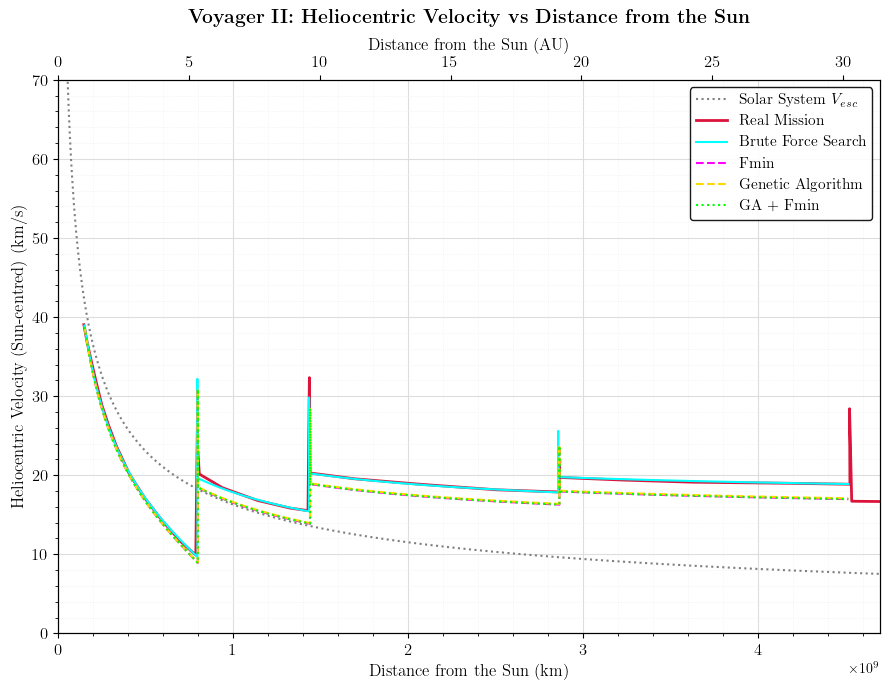

In [206]:
# Define different line styles for each plot
colours = {
    "Real Mission": "crimson",
    "Brute Force Algorithm": "cyan",
    "FMIN": "magenta",
    "GA": "gold",
    "GA + FMIN": "lime",
}

# Distinct line styles to prevent visual merging
line_styles = {
    "Real Mission": "-",              
    "Brute Force Algorithm": "-",    
    "FMIN": "--",                     
    "GA": '--',#(0, (5, 1)),               
    "GA + FMIN": ":",              
}

# Define different line widths for clarity
line_widths = {
    "Real Mission": 2,
    "Brute Force Algorithm": 1.5,
    "FMIN": 1.5,
    "GA": 1.5,
    "GA + FMIN": 1.5,
}

# Setup LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Create figure with primary axis
fig, ax1 = plt.subplots(figsize=(9, 7))

def plot_voyager_trajectory_vs_distance(date_departure, date_flyby_jupiter, date_flyby_saturn, date_flyby_uranus, date_flyby_neptune, method, plotlabel):
    flag = False  # Don't show individual plots
    print("Method:", method)

    # Earth to Jupiter
    planet1 = "earth"
    planet2 = "jupiter"
    days1, positions1, velocities1, v1, v2, tof_to_jupiter, r1, r2, v1_p_sc, v2_p_sc = plot_transfer_velocity(
        date1 = date_departure, 
        date2 = date_flyby_jupiter,
        planet1 = "earth", 
        planet2 = "jupiter",
        current_tof = 0,
        show_plot = flag, 
        num_points = 100
    )
    
    print(f"[{planet1} to {planet2}] Initial velocity: {np.linalg.norm(v1):.2f} km/s")
    print(f"[{planet1} to {planet2}] Final velocity: {np.linalg.norm(v2):.2f} km/s")
    print(f"[{planet1} to {planet2}] Initial Sun Distance: {np.linalg.norm(r1):.2e} km")
    print(f"[{planet1} to {planet2}] Final Sun Distance: {np.linalg.norm(r2):.2e} km")

    # Jupiter to Saturn
    planet1 = "jupiter"
    planet2 = "saturn"
    days2, positions2, velocities2, v1, v2, tof_to_saturn, r1, r2, v1_p_sc_jupiter, v2_p_sc_saturn = plot_transfer_velocity(
        date1 = date_flyby_jupiter, 
        date2 = date_flyby_saturn,
        planet1 = "jupiter", 
        planet2 = "saturn",
        current_tof = tof_to_jupiter,
        show_plot = flag, 
        num_points = 100
    )
    
    print(f"\n[{planet1} to {planet2}] Initial velocity: {np.linalg.norm(v1):.2f} km/s")
    print(f"[{planet1} to {planet2}] Final velocity: {np.linalg.norm(v2):.2f} km/s")
    print(f"[{planet1} to {planet2}] Initial Sun Distance: {np.linalg.norm(r1):.2e} km")
    print(f"[{planet1} to {planet2}] Final Sun Distance: {np.linalg.norm(r2):.2e} km")
    
    # Saturn to Uranus (added for Voyager 2)
    planet1 = "saturn"
    planet2 = "uranus"
    days3, positions3, velocities3, v1, v2, tof_to_uranus, r1, r2, v1_p_sc_saturn, v2_p_sc_uranus = plot_transfer_velocity(
        date1 = date_flyby_saturn, 
        date2 = date_flyby_uranus,
        planet1 = "saturn", 
        planet2 = "uranus",
        current_tof = tof_to_jupiter + tof_to_saturn,
        show_plot = flag, 
        num_points = 100
    )
    
    print(f"\n[{planet1} to {planet2}] Initial velocity: {np.linalg.norm(v1):.2f} km/s")
    print(f"[{planet1} to {planet2}] Final velocity: {np.linalg.norm(v2):.2f} km/s")
    print(f"[{planet1} to {planet2}] Initial Sun Distance: {np.linalg.norm(r1):.2e} km")
    print(f"[{planet1} to {planet2}] Final Sun Distance: {np.linalg.norm(r2):.2e} km")
    
    # Uranus to Neptune (added for Voyager 2)
    planet1 = "uranus"
    planet2 = "neptune"
    days4, positions4, velocities4, v1, v2, tof_to_neptune, r1, r2, v1_p_sc_uranus, v2_p_sc_neptune = plot_transfer_velocity(
        date1 = date_flyby_uranus, 
        date2 = date_flyby_neptune,
        planet1 = "uranus", 
        planet2 = "neptune",
        current_tof = tof_to_jupiter + tof_to_saturn + tof_to_uranus,
        show_plot = flag, 
        num_points = 100
    )
    
    print(f"\n[{planet1} to {planet2}] Initial velocity: {np.linalg.norm(v1):.2f} km/s")
    print(f"[{planet1} to {planet2}] Final velocity: {np.linalg.norm(v2):.2f} km/s")
    print(f"[{planet1} to {planet2}] Initial Sun Distance: {np.linalg.norm(r1):.2e} km")
    print(f"[{planet1} to {planet2}] Final Sun Distance: {np.linalg.norm(r2):.2e} km")
    print("--------------------------------------------------------")
    
    # Calculate distances from the Sun in km
    distances1_km = np.array([np.linalg.norm(pos) for pos in positions1])
    distances2_km = np.array([np.linalg.norm(pos) for pos in positions2])
    distances3_km = np.array([np.linalg.norm(pos) for pos in positions3])
    distances4_km = np.array([np.linalg.norm(pos) for pos in positions4])
    
    # Concatenate distances and velocities - in km
    distances_final = (distances1_km.tolist() + 
                      [np.linalg.norm(positions1[-1])] + 
                      distances2_km.tolist() + 
                      [np.linalg.norm(positions2[-1])] + 
                      distances3_km.tolist() + 
                      [np.linalg.norm(positions3[-1])] + 
                      distances4_km.tolist())
    
    velocities_final = (velocities1 + 
                       [v1_p_sc_jupiter] + 
                       velocities2 + 
                       [v1_p_sc_saturn] + 
                       velocities3 +
                       [v1_p_sc_uranus] +
                       velocities4)
    
    # Plot velocity vs distance
    ax1.plot(distances_final, velocities_final,
             color=colours[method], 
             label=plotlabel,
             linestyle=line_styles[method],
             linewidth=line_widths[method])
    
    # Return for potential further use
    return distances_final, velocities_final

ax1.plot(r_esc, v_esc, ':', label="Solar System $V_{esc}$", color='gray', linewidth=1.5)

# Execute plotting for each mission
# If using actual NASA data for Voyager 2, use this block instead of the plot_voyager_trajectory_vs_distance call
ax1.plot(V2_NASA_distance_from_Sun_km, V2_NASA_velocity,
         color=colours["Real Mission"], 
         label="Real Mission",
         linestyle=line_styles["Real Mission"],
         linewidth=line_widths["Real Mission"])

# Plot other optimisation methods
plot_voyager_trajectory_vs_distance(
    date_departure_BRUTE_MIN,
    date_flyby_jupiter_BRUTE_MIN,
    date_flyby_saturn_BRUTE_MIN,
    date_flyby_uranus_BRUTE_MIN,
    date_flyby_neptune_BRUTE_MIN,
    method="Brute Force Algorithm",
    plotlabel="Brute Force Search"
)

plot_voyager_trajectory_vs_distance(
    date_departure_FMIN,
    date_flyby_jupiter_FMIN,
    date_flyby_saturn_FMIN,
    date_flyby_uranus_FMIN,
    date_flyby_neptune_FMIN,
    method="FMIN",
    plotlabel="Fmin"
)

plot_voyager_trajectory_vs_distance(
    date_departure_GA,
    date_flyby_jupiter_GA,
    date_flyby_saturn_GA,
    date_flyby_uranus_GA,
    date_flyby_neptune_GA,
    method="GA",
    plotlabel="Genetic Algorithm"
)

plot_voyager_trajectory_vs_distance(
    date_departure_GA_FMIN_COMBINED,
    date_flyby_jupiter_GA_FMIN_COMBINED,
    date_flyby_saturn_GA_FMIN_COMBINED,
    date_flyby_uranus_GA_FMIN_COMBINED,
    date_flyby_neptune_GA_FMIN_COMBINED,
    method="GA + FMIN",
    plotlabel="GA + Fmin"
)

# Add planet positions
earth_distance = 1.5e8     # Earth's distance from Sun in km
jupiter_distance = 7.78e8  # Jupiter's distance from Sun in km
saturn_distance = 1.43e9   # Saturn's distance from Sun in km
uranus_distance = 2.88e9   # Uranus's distance from Sun in km
neptune_distance = 4.50e9  # Neptune's distance from Sun in km

# # Add vertical lines at planet positions
# ax1.axvline(x=earth_distance, linestyle='--', color='lightgray', alpha=0.6)
# ax1.axvline(x=jupiter_distance, linestyle='--', color='lightgray', alpha=0.6)
# ax1.axvline(x=saturn_distance, linestyle='--', color='lightgray', alpha=0.6)
# ax1.axvline(x=uranus_distance, linestyle='--', color='lightgray', alpha=0.6)
# ax1.axvline(x=neptune_distance, linestyle='--', color='lightgray', alpha=0.6)

# # Add planet labels
# ax1.text(earth_distance, 42, 'Earth', fontsize=10, ha='center')
# ax1.text(jupiter_distance, 40, 'Jupiter', fontsize=10, ha='center')
# ax1.text(saturn_distance, 38, 'Saturn', fontsize=10, ha='center')
# ax1.text(uranus_distance, 36, 'Uranus', fontsize=10, ha='center')
# ax1.text(neptune_distance, 34, 'Neptune', fontsize=10, ha='center')

# Primary x-axis (Distance in km)
ax1.set_xlabel("Distance from the Sun (km)", fontsize=12)
ax1.set_ylabel("Heliocentric Velocity (Sun-centred) (km/s)", fontsize=12)
ax1.set_ylim(0, 70)

# Adjust the x-axis limits to show relevant range from Earth to Neptune
ax1.set_xlim(0, 4.7e9)

# Create secondary x-axis (Distance in AU)
ax2 = ax1.twiny()
ax2.set_xlabel("Distance from the Sun (AU)", fontsize=12)

# Set tick positions based on AU
km_to_AU = 1 / 149597870.691  # Conversion factor
ax2.set_xlim(ax1.get_xlim()[0] * km_to_AU, ax1.get_xlim()[1] * km_to_AU)

# Improve legend
ax1.legend(loc="best", fontsize=11, frameon=True, framealpha=0.9, edgecolor='black')

# Improve grid and ticks
ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax1.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax1.minorticks_on()

# Customize tick parameters
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.title(r'\textbf{Voyager II: Heliocentric Velocity vs Distance from the Sun}', fontsize=14, pad=10)
plt.tight_layout()

# Save the figure with high resolution
output_figures.save_file('Voyager_II_Heliocentric_Velocity_vs_Distance.png', dpi=500, bbox_inches="tight")

plt.show()

Figure saved to: Voyager 2 - Figures/Voyager_II_Brute_Force_Algorithm_Comparison.png


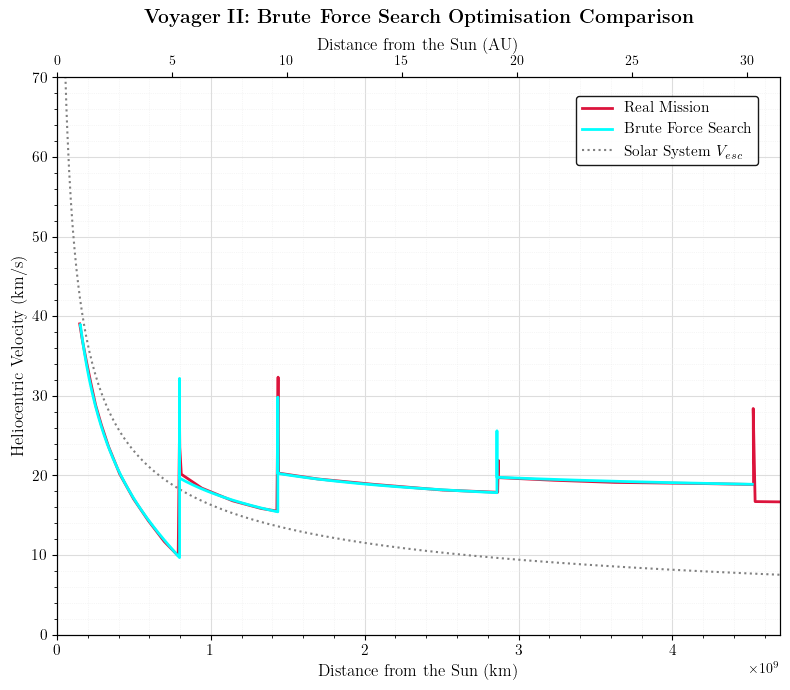

Figure saved to: Voyager 2 - Figures/Voyager_II_FMIN_Comparison.png


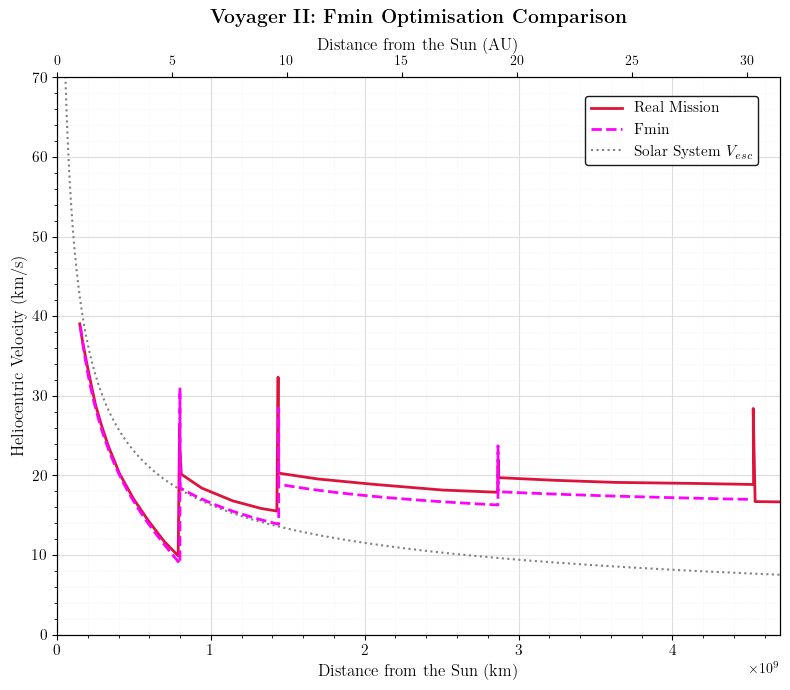

Figure saved to: Voyager 2 - Figures/Voyager_II_GA_Comparison.png


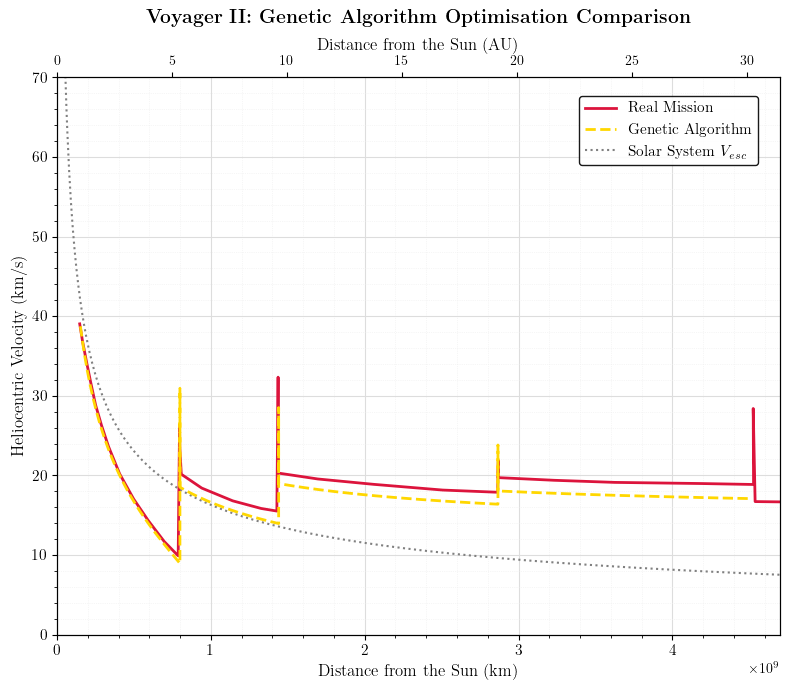

Figure saved to: Voyager 2 - Figures/Voyager_II_GA_+_FMIN_Comparison.png


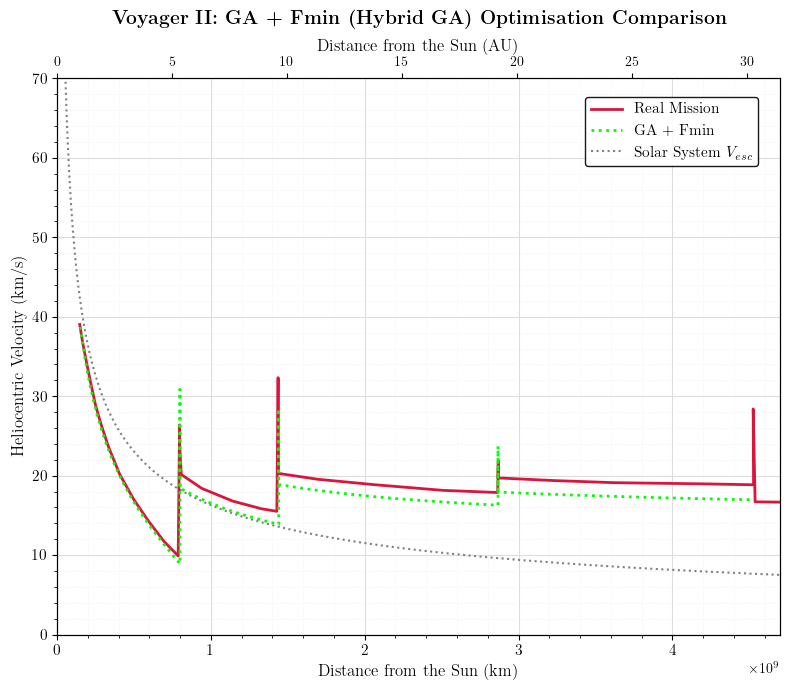

All four figures have been created and saved.


In [207]:
# Define different line styles for each plot
colours = {
    "Real Mission": "crimson",
    "Brute Force Algorithm": "cyan",
    "FMIN": "magenta",
    "GA": "gold",
    "GA + FMIN": "lime",
}

# Distinct line styles to prevent visual merging
line_styles = {
    "Real Mission": "-",              
    "Brute Force Algorithm": "-",    
    "FMIN": "--",                     
    "GA": '--',#(0, (5, 1)),               
    "GA + FMIN": ":",              
}

# Define different line widths for clarity
line_widths = {
    "Real Mission": 2,
    "Brute Force Algorithm": 2,
    "FMIN": 2,
    "GA": 2,
    "GA + FMIN": 2,
}

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

figure_titles = [
    r"\textbf{Voyager II: Brute Force Search Optimisation Comparison}",
    r"\textbf{Voyager II: Fmin Optimisation Comparison}",
    r"\textbf{Voyager II: Genetic Algorithm Optimisation Comparison}",
    r"\textbf{Voyager II: GA + Fmin (Hybrid GA) Optimisation Comparison}"
]

# Methods and their labels for each figure
methods = ["Brute Force Algorithm", "FMIN", "GA", "GA + FMIN"]
method_labels = ["Brute Force Search", "Fmin", "Genetic Algorithm", "GA + Fmin"]

def plot_voyager_trajectory_vs_distance(ax, date_departure, date_flyby_jupiter, date_flyby_saturn, 
                                      date_flyby_uranus, date_flyby_neptune, method, plotlabel):
    flag = False  # Don't show individual plots
    
    # Earth to Jupiter
    planet1 = "earth"
    planet2 = "jupiter"
    days1, positions1, velocities1, v1, v2, tof_to_jupiter, r1, r2, v1_p_sc, v2_p_sc = plot_transfer_velocity(
        date1 = date_departure, 
        date2 = date_flyby_jupiter,
        planet1 = "earth", 
        planet2 = "jupiter",
        current_tof = 0,
        show_plot = flag, 
        num_points = 100
    )
    
    # Jupiter to Saturn
    planet1 = "jupiter"
    planet2 = "saturn"
    days2, positions2, velocities2, v1, v2, tof_to_saturn, r1, r2, v1_p_sc_jupiter, v2_p_sc_saturn = plot_transfer_velocity(
        date1 = date_flyby_jupiter, 
        date2 = date_flyby_saturn,
        planet1 = "jupiter", 
        planet2 = "saturn",
        current_tof = tof_to_jupiter,
        show_plot = flag, 
        num_points = 100
    )
    
    # Saturn to Uranus
    planet1 = "saturn"
    planet2 = "uranus"
    days3, positions3, velocities3, v1, v2, tof_to_uranus, r1, r2, v1_p_sc_saturn, v2_p_sc_uranus = plot_transfer_velocity(
        date1 = date_flyby_saturn, 
        date2 = date_flyby_uranus,
        planet1 = "saturn", 
        planet2 = "uranus",
        current_tof = tof_to_jupiter + tof_to_saturn,
        show_plot = flag, 
        num_points = 100
    )
    
    # Uranus to Neptune
    planet1 = "uranus"
    planet2 = "neptune"
    days4, positions4, velocities4, v1, v2, tof_to_neptune, r1, r2, v1_p_sc_uranus, v2_p_sc_neptune = plot_transfer_velocity(
        date1 = date_flyby_uranus, 
        date2 = date_flyby_neptune,
        planet1 = "uranus", 
        planet2 = "neptune",
        current_tof = tof_to_jupiter + tof_to_saturn + tof_to_uranus,
        show_plot = flag, 
        num_points = 100
    )
    
    # Calculate distances from the Sun in km
    distances1_km = np.array([np.linalg.norm(pos) for pos in positions1])
    distances2_km = np.array([np.linalg.norm(pos) for pos in positions2])
    distances3_km = np.array([np.linalg.norm(pos) for pos in positions3])
    distances4_km = np.array([np.linalg.norm(pos) for pos in positions4])
    
    # Concatenate distances and velocities - in km
    distances_final = (distances1_km.tolist() + 
                      [np.linalg.norm(positions1[-1])] + 
                      distances2_km.tolist() + 
                      [np.linalg.norm(positions2[-1])] + 
                      distances3_km.tolist() + 
                      [np.linalg.norm(positions3[-1])] + 
                      distances4_km.tolist())
    
    velocities_final = (velocities1 + 
                       [v1_p_sc_jupiter] + 
                       velocities2 + 
                       [v1_p_sc_saturn] + 
                       velocities3 +
                       [v1_p_sc_uranus] +
                       velocities4)
    
    # Plot velocity vs distance for this method
    ax.plot(distances_final, velocities_final,
            color=colours[method], 
            label=plotlabel,
            linestyle=line_styles[method],
            linewidth=line_widths[method])
    
    # Return for potential further use
    return distances_final, velocities_final

# Create and configure each figure separately
for i, (method, label, title) in enumerate(zip(methods, method_labels, figure_titles)):
    # Create a new figure for each method
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111)
    
    # Plot escape velocity curve
    ax.plot(r_esc, v_esc, ':', label="Solar System $V_{esc}$", color='gray', linewidth=1.5)
    
    # Plot real mission data
    ax.plot(V2_NASA_distance_from_Sun_km, V2_NASA_velocity,
            color=colours["Real Mission"], 
            label="Real Mission",
            linestyle=line_styles["Real Mission"],
            linewidth=line_widths["Real Mission"])
    
    # Plot the specific optimization method
    if method == "Brute Force Algorithm":
        plot_voyager_trajectory_vs_distance(
            ax,
            date_departure_BRUTE_MIN,
            date_flyby_jupiter_BRUTE_MIN,
            date_flyby_saturn_BRUTE_MIN,
            date_flyby_uranus_BRUTE_MIN,
            date_flyby_neptune_BRUTE_MIN,
            method=method,
            plotlabel=label
        )
    elif method == "FMIN":
        plot_voyager_trajectory_vs_distance(
            ax,
            date_departure_FMIN,
            date_flyby_jupiter_FMIN,
            date_flyby_saturn_FMIN,
            date_flyby_uranus_FMIN,
            date_flyby_neptune_FMIN,
            method=method,
            plotlabel=label
        )
    elif method == "GA":
        plot_voyager_trajectory_vs_distance(
            ax,
            date_departure_GA,
            date_flyby_jupiter_GA,
            date_flyby_saturn_GA,
            date_flyby_uranus_GA,
            date_flyby_neptune_GA,
            method=method,
            plotlabel=label
        )
    elif method == "GA + FMIN":
        plot_voyager_trajectory_vs_distance(
            ax,
            date_departure_GA_FMIN_COMBINED,
            date_flyby_jupiter_GA_FMIN_COMBINED,
            date_flyby_saturn_GA_FMIN_COMBINED,
            date_flyby_uranus_GA_FMIN_COMBINED,
            date_flyby_neptune_GA_FMIN_COMBINED,
            method=method,
            plotlabel=label
        )
    
    # Add planet positions
    earth_distance = 1.5e8     # Earth's distance from Sun in km
    jupiter_distance = 7.78e8  # Jupiter's distance from Sun in km
    saturn_distance = 1.43e9   # Saturn's distance from Sun in km
    uranus_distance = 2.88e9   # Uranus's distance from Sun in km
    neptune_distance = 4.50e9  # Neptune's distance from Sun in km
    
    # # Add subtle vertical lines at planet positions
    # for dist, name in [(earth_distance, 'Earth'), 
    #                   (jupiter_distance, 'Jupiter'), 
    #                   (saturn_distance, 'Saturn'),
    #                   (uranus_distance, 'Uranus'),
    #                   (neptune_distance, 'Neptune')]:
    #     ax.axvline(x=dist, linestyle='--', color='lightgray', alpha=0.4)
    #     ax.text(dist, 5, name, fontsize=9, ha='center', rotation=90, alpha=0.7)
    
    # Configure axes and labels
    ax.set_xlim(0, 4.7e9)
    ax.set_ylim(0, 70)
    ax.set_xlabel("Distance from the Sun (km)", fontsize=12)
    ax.set_ylabel("Heliocentric Velocity (km/s)", fontsize=12)
    
    # Create secondary x-axis (Distance in AU)
    ax2 = ax.twiny()
    ax2.set_xlabel("Distance from the Sun (AU)", fontsize=12)
    km_to_AU = 1 / 149597870.691  # Conversion factor
    ax2.set_xlim(ax.get_xlim()[0] * km_to_AU, ax.get_xlim()[1] * km_to_AU)
    ax2.tick_params(axis='x', which='major', labelsize=10)
    
    # Improve grid and ticks
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.tick_params(axis='both', which='minor', labelsize=9)
    
    # Reorder legend to put Real Mission first
    handles, labels = ax.get_legend_handles_labels()
    if len(handles) > 2:  # Make sure we have all three expected curves
        new_order = [1, 2, 0]  # Real Mission, Method, Escape Velocity
        handles = [handles[i] for i in new_order]
        labels = [labels[i] for i in new_order]
    ax.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.98, 0.98), 
              fontsize=11, frameon=True, framealpha=0.9, edgecolor='black')
    
    # Set the figure title
    plt.title(title, fontsize=14, pad=10)
    
    plt.tight_layout()
    
    # Save each figure with high resolution
    filename = f"Voyager_II_{method.replace(' ', '_').replace('-->', 'to')}_Comparison.png"
    output_figures.save_file(filename, dpi=500, bbox_inches="tight")
    
    plt.show()
    # Close the figure to prevent memory issues
    plt.close(fig)

print("All four figures have been created and saved.")